In [ ]:
import torch,math
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate, Dataset
from torch.nn import init
from torch.nn  import Conv2d, ZeroPad2d
import copy
from functools import partial
import torchvision.transforms.functional as TF,torch.nn.functional as F
from scipy import linalg, integrate
from datasets import load_dataset
from diffusers.models.attention_processor import Attention
from einops import rearrange
import numpy as np
from functools import wraps
 



One-Layer Perceptron（单层感知机）
单层感知机（One-Layer Perceptron）是最基础的人工神经网络模型，由 Frank Rosenblatt 在 1957 年提出。它是神经网络和深度学习的起点，但能力有限，仅能解决线性可分问题。

1. 核心结构
输入层：直接接收特征向量（如 [x₁, x₂, ..., xₙ]）。
输出层：单一神经元，通过激活函数（如阶跃函数）输出分类结果（通常为 0 或 1）。
权重与偏置：每个输入连接一个权重 wᵢ，外加一个偏置 b

MLP（多层感知机）
MLP（Multilayer Perceptron，多层感知机） 是一种经典的 前馈神经网络，由多个全连接层（Dense Layer）堆叠而成，是深度学习中最基础且广泛使用的模型之一。

1. 核心结构
输入层：接收原始数据（如向量化的图像、文本等）。
隐藏层：包含至少一个非线性激活函数（如ReLU、Sigmoid）的全连接层，用于特征变换。
输出层：根据任务类型（分类/回归）选择激活函数（如Softmax、线性输出）。
2. 核心特点
全连接性：每一层的神经元与下一层所有神经元相连。
非线性能力：通过激活函数（如ReLU）引入非线性，可拟合复杂函数。
通用近似定理：理论上，单隐藏层MLP（足够宽）可逼近任意连续函数。

In [ ]:
class Perceptron:
    def __init__(self, input_size):
        self.weights  = np.zeros(input_size) 
        self.bias  = 0 
 
    def predict(self, x):
        z = np.dot(self.weights,  x) + self.bias 
        return 1 if z > 0 else 0  # 阶跃激活函数
 
# 训练一个与门（AND）
X = np.array([[0,0],  [0,1], [1,0], [1,1]])
y = np.array([0,  0, 0, 1])
perceptron = Perceptron(input_size=2)
 
# 手动设置权重（实际需通过训练更新）
perceptron.weights  = np.array([0.5,  0.5])
perceptron.bias  = -0.7 
 
for xi, yi in zip(X, y):
    print(f"Input: {xi}, Output: {perceptron.predict(xi)}") 
 
class MLP(nn.Module):
    def __init__(self, input_dim=784, hidden_dims=[256, 128], output_dim=10):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims 
        for i in range(len(dims)-1):
            layers.extend([nn.Linear(dims[i],  dims[i+1]), nn.ReLU()])
        layers.append(nn.Linear(hidden_dims[-1],  output_dim))
        self.mlp  = nn.Sequential(*layers)
 
    def forward(self, x):
        return self.mlp(x) 

In [ ]:
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

# autoencoder
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def deconv(ni, nf, ks=3, act=True):
    layers = [nn.ConvTranspose2d(ni, nf, kernel_size=ks, stride=2, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

ae = nn.Sequential(   #28x28
    nn.ZeroPad2d(2),  #32x32
    conv(1,2),        #16x16
    conv(2,4),        #8x8
#     conv(4,8),        #4x4
#     deconv(8,4),      #8x8
    deconv(4,2),      #16x16
    deconv(2,1, act=False), #32x32
    nn.ZeroPad2d(-2), #28x28
    nn.Sigmoid()
).to(def_device)

ni,nh,nl = 784,400,200
def lin(ni, nf, act=nn.SiLU, norm=nn.BatchNorm1d, bias=True):
    layers = nn.Sequential(nn.Linear(ni, nf, bias=bias))
    if act : layers.append(act())
    if norm: layers.append(norm(nf))
    return layers

def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d,nn.Linear)): init.kaiming_normal_(m.weight, a=leaky)

iw = partial(init_weights, leaky=0.2)

class Autoenc(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(lin(ni, nh), lin(nh, nh), lin(nh, nl))
        self.dec = nn.Sequential(lin(nl, nh), lin(nh, nh), lin(nh, ni, act=None))
        iw(self)
        
    def forward(self, x):
        x = self.enc(x)
        return self.dec(x)

# VAE (Variational ae), z is latent variable
class VAE(nn.Module): 
    def __init__(self, input_dim, hidden_dim, latent_dim): 
        super(VAE, self).__init__() 
        # 编码器部分 
        self.fc1  = nn.Linear(input_dim, hidden_dim) 
        self.fc_mu  = nn.Linear(hidden_dim, latent_dim) 
        self.fc_logvar  = nn.Linear(hidden_dim, latent_dim) 
        # 解码器部分 
        self.fc2  = nn.Linear(latent_dim, hidden_dim) 
        self.fc3  = nn.Linear(hidden_dim, input_dim) 

    def encode(self, x): 
        h = torch.relu(self.fc1(x))  
        mu = self.fc_mu(h)  
        logvar = self.fc_logvar(h)  
        return mu, logvar 
 
    def reparameterize(self, mu, logvar): 
        std = torch.exp(0.5  * logvar) 
        eps = torch.randn_like(std)  
        return mu + eps * std 
 
    def decode(self, z): 
        h = torch.relu(self.fc2(z))  
        return torch.sigmoid(self.fc3(h))  
 
    def forward(self, x): 
        mu, logvar = self.encode(x)  
        z = self.reparameterize(mu,  logvar) 
        return self.decode(z),  mu, logvar 

class VAE2(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(lin(ni, nh), lin(nh, nh))
        self.mu,self.lv = lin(nh, nl, act=None),lin(nh, nl, act=None)
        self.dec = nn.Sequential(lin(nl, nh), lin(nh, nh), lin(nh, ni, act=None))
        iw(self)
        
    def forward(self, x):
        x = self.enc(x)
        mu,lv = self.mu(x),self.lv(x)
        z = mu + (0.5*lv).exp()*torch.randn_like(lv)
        return self.dec(z),mu,lv

# Kullback-Leibler Divergence Loss
def kld_loss(inp, x):
    x_hat,mu,lv = inp
    return -0.5 * (1 + lv - mu.pow(2) - lv.exp()).mean()
# Binary Cross-Entropy Loss
def bce_loss(inp, x): return F.binary_cross_entropy_with_logits(inp[0], x)

def vae_loss(inp, x): return kld_loss(inp, x) + bce_loss(inp,x)


In [ ]:
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x
def noop (x=None, *args, **kwargs):
    "Do nothing"
    return x

In [ ]:
# RESNET
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)

def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    return nn.Sequential(conv(ni, nf, stride=1, act=act, norm=norm, ks=ks),
                         conv(nf, nf, stride=stride, act=None, norm=norm, ks=ks))

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks, norm=norm)
        self.idconv = noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act = act()

    def forward(self, x): return self.act(self.convs(x) + self.idconv(self.pool(x)))

def get_model(act=nn.ReLU, nfs=(8,16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 8, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

# ResNet类的基本结构
# ResNet类通常继承自PyTorch的nn.Module基类，包含__init__初始化方法和forward前向传播方法。在__init__中定义网络各层结构，forward方法则描述数据在网络中的流动顺序。
# ResNet主要由初始卷积层、批量归一化层、ReLU激活函数、最大池化层、4个残差块层（layer1-layer4）、平均池化层和全连接层组成。
# 残差块实现
# ResNet包含两种残差块：BasicBlock和Bottleneck。BasicBlock用于较浅的网络（如ResNet18/34），由两个3x3卷积层组成；Bottleneck用于深层网络（如ResNet50/101/152），由1x1、3x3、1x1三个卷积层构成，
# 第一个1x1卷积用于降维，最后一个1x1卷积恢复维度。每个卷积层后都跟随批量归一化和ReLU激活。残差连接通过将输入直接加到输出上来实现，当维度不匹配时使用1x1卷积进行下采样。
# forward方法实现
# forward方法定义了数据流动路径：先通过初始卷积层（conv1）、批量归一化（bn1）、ReLU和最大池化（maxpool），然后依次通过4个残差块层（layer1-layer4），最后经过平均池化（avgpool）、展平（flatten）和全连接层（fc）。
# 在PyTorch中，可以直接通过实例调用（如model(input)）来自动触发forward方法，这得益于Python的__call__机制。
class BasicBlock(nn.Module):
    expansion = 1 
    
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1  = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1  = nn.BatchNorm2d(planes)
        self.conv2  = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2  = nn.BatchNorm2d(planes)
        
        self.shortcut  = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes: 
            self.shortcut  = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,  kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes) 
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x))) 
        out = self.bn2(self.conv2(out)) 
        out += self.shortcut(x) 
        out = F.relu(out) 
        return out 
 
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_planes  = 64 
        
        self.conv1  = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1  = nn.BatchNorm2d(64)
        self.maxpool  = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1  = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2  = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3  = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4  = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        self.avgpool  = nn.AdaptiveAvgPool2d((1, 1))
        self.fc  = nn.Linear(512*block.expansion,  num_classes)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes,  planes, stride))
            self.in_planes  = planes * block.expansion  
        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x))) 
        x = self.maxpool(x) 
        
        x = self.layer1(x) 
        x = self.layer2(x) 
        x = self.layer3(x) 
        x = self.layer4(x) 
        
        x = self.avgpool(x) 
        x = torch.flatten(x,  1)
        x = self.fc(x) 
        return x 
 
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

# Denoising Diffusion Probabilistic Models(DDPM)
The model described in the seminal 2020 paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) (DDPM). For more context, while diffusion models were technically invented [back in 2015](https://arxiv.org/abs/1503.03585)

DDPM is trained quite simply in a few steps:
1. randomly select some timesteps in an iterative noising process.
2. Add noise corresponding to this timestep to the original image. For increasing timesteps, the variance of the noise increases.
3. Pass in this noisy image and the timestep to our model
4. Model is trained with an MSE loss between the model output and the amount of noise added to the image

# DDPM 核心原理算法详解 
 
**Denoising Diffusion Probabilistic Models (DDPM)** 是一种基于马尔可夫链的生成模型，通过逐步加噪和去噪过程实现数据生成。以下是其核心原理算法：
 
## 一、前向扩散过程（加噪）
将原始数据 $x_0$ 逐步添加高斯噪声，经过 $T$ 步转化为纯噪声 $x_T$：
 
$
q(x_t|x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1}, \beta_t I)
表示在给定前一步状态x_{t-1}的条件下，当前状态x_{t}的分布是一个高斯分布（正态分布）。具体参数如下：\\
均值（mean）： \sqrt{1-\beta_t}x_{t-1}  
方差（variance）：\beta_t I，I是单位矩阵，表示各个维度独立且方差相同
$
### 1. 均值分量：$\sqrt{1-\beta_t}x_{t-1}$
| **特性**        | **数学意义**               | **物理意义**                     |
|-----------------|--------------------------|----------------------------------|
| 缩减因子        | $\sqrt{1-\beta_t} < 1$   | 对前步数据的缩放衰减             |
| 信号保留        | 与$\beta_t$成反比         | $\beta_t$越大，信号保留越少      |
| 稳定性保障      | 防止数据幅度无限增长       | 维持扩散过程的数值稳定           |
 
### 2. 方差分量：$\beta_t I$
| **特性**        | **数学意义**               | **物理意义**                     |
|-----------------|--------------------------|----------------------------------|
| 各向同性        | $I$ 为单位矩阵           | 各维度独立同分布噪声             |
| 噪声强度        | $\beta_t$ 控制方差大小    | 决定当前步添加的噪声量           |
| 时间依赖性      | $\beta_t$ 随 $t$ 单调递增 | 随时间步增加噪声逐步增强         |
 
## ⚙️ 参数解释
### $\beta_t$ - 噪声调度参数 
- **取值范围**：$(0,1)$  
- **调度特性**：  
  $\beta_1 < \beta_2 < \cdots < \beta_T$  
  （典型值：$\beta_1≈0.0001$, $\beta_T≈0.02$）
- **作用机制**：  
  控制噪声注入速率，决定扩散轨迹形状 
 
### $1-\beta_t$ - 信号保留因子
- **物理作用**：  
  平衡信号衰减与噪声注入的比例关系  
  $\text{信号保留量} \propto \sqrt{1-\beta_t}$  
  $\text{噪声注入量} \propto \sqrt{\beta_t}$


**关键特性：**
1. **闭式表达**：任意时刻 $t$ 的状态可直接从 $x_0$ 计算：
   $
   x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha}_t}\epsilon, \quad \epsilon \sim \mathcal{N}(0,I)
   $
   其中 $\alpha_t = 1-\beta_t$, $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$
 
2. **噪声调度**：$\beta_t$ 满足 $0 < \beta_1 < \beta_2 < \cdots < \beta_T < 1$，通常采用线性或余弦调度 
 
## 二、反向去噪过程（生成）
学习从噪声 $x_T$ 逐步重建数据 $x_0$ 的逆过程：
 
$
p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t,t), \Sigma_\theta(x_t,t))
$
 
**参数化形式：**
$
\mu_\theta(x_t,t) = \frac{1}{\sqrt{\alpha_t}}\left( x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_\theta(x_t,t) \right)
$
$
\Sigma_\theta(x_t,t) = \sigma_t^2 I, \quad \sigma_t^2 = \frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t}\beta_t
$
 
## 三、训练目标（简化损失函数）
优化噪声预测网络 $\epsilon_\theta$：
 
$
\mathcal{L}_{simple} = \mathbb{E}_{t,x_0,\epsilon} \left[ \| \epsilon - \epsilon_\theta(\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha}_t}\epsilon, t) \|^2 \right]
$
 
**训练流程：**
1. 采样数据 $x_0 \sim q(x_0)$ 
2. 随机选择时间步 $t \sim \text{Uniform}(1,T)$ 
3. 采样噪声 $\epsilon \sim \mathcal{N}(0,I)$
4. 计算梯度下降更新 $\nabla_\theta \|\epsilon - \epsilon_\theta(x_t,t)\|^2$

## 📌 核心采样公式
$
x_{t-1} = \underbrace{\mu_\theta(x_t, t)}_{\text{确定性成分}} + \underbrace{\sigma_t \cdot z}_{\text{随机成分}},\quad z \sim \mathcal{N}(0,I)
$
 
## 🔍 双组分物理意义解析
### 🎯 确定性成分 $\mu_\theta(x_t, t)$
| **特性**       | **数学本质**                  | **生成作用**                     |
|----------------|-----------------------------|--------------------------------|
| 去噪方向预测   | 神经网络 $\epsilon_\theta$ 的输出映射 | 指向数据流形的最优重建路径        |
| 信息压缩       | $\mu_\theta = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_\theta)$ | 保留有效信号，滤除高频噪声        |
| 分布锚点       | 近似真实后验分布 $q(x_{t-1}\|x_t,x_0)$ 的均值 | 确保生成样本位于数据分布高概率区域 | 

## 四、采样算法（生成新样本）
```python
def ddpm_sampling(model, T):
    x_T = torch.randn_like(data)   # 纯噪声 
    for t in range(T, 0, -1):     # 从T到1反向迭代
        z = torch.randn_like(x_T)  if t > 1 else 0
        # 计算噪声预测
        eps_theta = model(x_T, t) 
        # 计算均值 
        mu_theta = (x_T - (beta_t/sqrt(1-alpha_bar_t))*eps_theta) / sqrt(alpha_t)
        # 更新样本 
        x_{t-1} = mu_theta + sigma_t * z
    return x_0  # 生成样本 

In [ ]:
import torch 
import torch.nn  as nn 
import torch.optim  as optim
import numpy as np 
from torch.utils.data  import DataLoader 
from torchvision import datasets, transforms 
from torchvision.utils  import save_image
import matplotlib.pyplot  as plt
from tqdm import tqdm
 
# ======================
# 配置参数 
# ======================
device = torch.device("cuda"  if torch.cuda.is_available()  else "cpu")
batch_size = 64
image_size = 32  # CIFAR-10标准尺寸
num_epochs = 100
T = 1000  # 扩散步数
beta_start = 1e-4
beta_end = 0.02
 
# ======================
# 噪声调度器 
# ======================
# cosine schedule
def abar(t): return (t*math.pi/2).cos()**2
def inv_abar(x): return x.sqrt().acos()*2/math.pi
def noisify(x0):
    device = x0.device
    n = len(x0)
    t = torch.rand(n,).to(x0).clamp(0,0.999)
    ε = torch.randn(x0.shape, device=device)
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    xt = abar_t.sqrt()*x0 + (1-abar_t).sqrt()*ε
    return (xt, t.to(device)), ε

class NoiseScheduler:
    def __init__(self, T, beta_start, beta_end):
        self.T = T 
        self.betas  = torch.linspace(beta_start,  beta_end, T).to(device)
        self.alphas  = 1. - self.betas  
        self.alpha_bars  = torch.cumprod(self.alphas,  dim=0)
    
    def add_noise(self, x_0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_0) 
        
        alpha_bar_t = self.alpha_bars[t].view(-1,  1, 1, 1)
        noisy_x = torch.sqrt(alpha_bar_t)  * x_0 + torch.sqrt(1  - alpha_bar_t) * noise 
        return noisy_x, noise
 
# ======================
# U-Net模型架构 
# ======================
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp  = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv  = nn.ConvTranspose2d(in_ch, out_ch, 3, padding=1)
        else:
            self.conv  = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.norm  = nn.BatchNorm2d(out_ch)
        self.act  = nn.SiLU()
    
    def forward(self, x, t):
        h = self.conv(x) 
        time_emb = self.act(self.time_mlp(t)) 
        h = h + time_emb[:, :, None, None]
        h = self.norm(h) 
        return self.act(h) 
 
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        channels = [64, 128, 256, 512]
        
        # 时间嵌入 
        self.time_mlp  = nn.Sequential(
            nn.Linear(1, 32),
            nn.SiLU(),
            nn.Linear(32, 32)
        )
        
        # 下采样路径 
        self.down1  = Block(in_channels, channels[0], 32)
        self.down2  = Block(channels[0], channels[1], 32)
        self.down3  = Block(channels[1], channels[2], 32)
        
        # 最底层
        self.bottleneck  = Block(channels[2], channels[3], 32)
        
        # 上采样路径 
        self.up1  = Block(channels[3] + channels[2], channels[2], 32, up=True)
        self.up2  = Block(channels[2] + channels[1], channels[1], 32, up=True)
        self.up3  = Block(channels[1] + channels[0], channels[0], 32, up=True)
        
        # 输出层 
        self.out  = nn.Conv2d(channels[0], out_channels, 1)
    
    def forward(self, x, t):
        # 时间嵌入
        t = t.unsqueeze(-1).float() 
        t_emb = self.time_mlp(t) 
        
        # 下采样
        d1 = self.down1(x,  t_emb)
        d2 = self.down2(d1,  t_emb)
        d3 = self.down3(d2,  t_emb)
        
        # 瓶颈层 
        bottleneck = self.bottleneck(d3,  t_emb)
        
        # 上采样
        u1 = self.up1(torch.cat([bottleneck,  d3], dim=1), t_emb)
        u2 = self.up2(torch.cat([u1,  d2], dim=1), t_emb)
        u3 = self.up3(torch.cat([u2,  d1], dim=1), t_emb)
        
        return self.out(u3) 
 
# ======================
# 训练函数 
# ======================
def train(model, dataloader, optimizer, scheduler, epochs=T):
    model.train() 
    loss_fn = nn.MSELoss()
    
    for epoch in range(epochs):
        total_loss = 0 
        for images, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            images = images.to(device) 
            
            # 随机采样时间步
            t = torch.randint(0,  T, (images.shape[0],)).to(device) 
            
            # 添加噪声 
            noisy_images, noise = scheduler.add_noise(images,  t)
            
            # 预测噪声 
            predicted_noise = model(noisy_images, t)
            
            # 计算损失 
            loss = loss_fn(predicted_noise, noise)
            
            # 反向传播
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step() 
            
            total_loss += loss.item() 
        
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")
        
        # 每10个epoch保存一次模型
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(),  f"ddpm_epoch_{epoch+1}.pth")
    
    return model
 
# ======================
# 采样生成图像 
# ======================
def sample(model, scheduler, n_images=16):
    model.eval() 
    with torch.no_grad(): 
        # 从随机噪声开始
        x = torch.randn(n_images,  3, image_size, image_size).to(device)
        
        for t_step in tqdm(reversed(range(T)), desc="Generating"):
            t = torch.full((n_images,),  t_step, device=device, dtype=torch.long) 
            
            # 预测噪声
            pred_noise = model(x, t)
            
            # 计算系数 
            alpha = scheduler.alphas[t][:,  None, None, None]
            alpha_bar = scheduler.alpha_bars[t][:,  None, None, None]
            beta = scheduler.betas[t][:,  None, None, None]
            
            # 计算重新参数化的均值
            if t_step > 0:
                noise = torch.randn_like(x) 
            else:
                noise = torch.zeros_like(x) 
                
            # DDPM采样公式
            x = (1 / torch.sqrt(alpha))  * (
                x - ((1 - alpha) / (torch.sqrt(1  - alpha_bar))) * pred_noise
            ) + torch.sqrt(beta)  * noise 
            
        # 将图像缩放到[0,1]范围
        x = (x.clamp(-1,  1) + 1) / 2 
        save_image(x, "generated_samples.png",  nrow=4)
        return x

class MixedPrecision():
    def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler('cuda')
    def before_batch(self, learn):
        self.autocast = torch.autocast("cuda", dtype=torch.float16)
        self.autocast.__enter__()
    def after_loss(self, learn): self.autocast.__exit__(None, None, None)
    def backward(self, learn): self.scaler.scale(learn.loss).backward()
    def step(self, learn):
        self.scaler.step(learn.opt)
        self.scaler.update()

# ======================
# 主程序 
# ======================
if __name__ == "__main__":
    # 1. 准备数据 
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # 2. 初始化组件 
    noise_scheduler = NoiseScheduler(T, beta_start, beta_end)
    model = UNet().to(device)
    optimizer = optim.Adam(model.parameters(),  lr=1e-4)
    
    # 3. 训练模型 
    print("Starting training...")
    trained_model = train(model, dataloader, optimizer, noise_scheduler, num_epochs)
    
    # 4. 保存最终模型
    torch.save(trained_model.state_dict(),  "ddpm_final.pth") 
    print("Training completed. Model saved.")
    
    # 5. 生成样本 
    print("Generating samples...")
    generated_images = sample(trained_model, noise_scheduler)

# Denoising Diffusion Implicit Models - DDIM

# DDIM（Denoising Diffusion Implicit Models）核心原理与算法 
 
## 1. 核心思想 
DDIM 是扩散模型的改进形式，通过**非马尔可夫链的确定性过程**实现高质量生成，同时支持**大幅减少采样步骤**（如10-50步）。其关键突破在于：
- 将扩散过程重新参数化为可逆的非马尔可夫链 
- 通过隐式概率模型实现确定性采样 
- 保持与DDPM相同的训练目标（可复用已有模型）
 
## 2. 核心算法步骤 
 
### 2.1 前向过程（非马尔可夫）
定义任意时间序列子集 $\{τ_1,τ_2,...,τ_T\}$，前向过程为：
$$
q_σ(x_{1:T}|x_0) = q_σ(x_T|x_0)\prod_{t=2}^T q_σ(x_{τ_{t-1}}|x_{τ_t},x_0)
$$
其中 $σ$ 控制随机性（当 $σ=0$ 时为确定性过程）
 
### 2.2 反向过程（关键公式）
采样公式：
$$
x_{t-1} = \sqrt{\barα_{t-1}} \left( \frac{x_t - \sqrt{1-\barα_t}ε_θ(x_t,t)}{\sqrt{\barα_t}} \right) + \sqrt{1-\barα_{t-1}-σ_t^2}·ε_θ(x_t,t) + σ_tε 
$$
其中：
- $ε_θ(x_t,t)$：训练好的噪声预测网络 
- $\barα_t$：累积噪声调度参数 
- $σ_t$：控制随机性的超参数 
 
## 3. 关键数学推导 
### 3.1 变分下界重构 
保持与DDPM相同的训练目标：
$$
L_{θ} = \mathbb{E}_{t,x_0,ε}[||ε - ε_θ(x_t,t)||^2]
$$
 
### 3.2 确定性采样（σ=0）
当 $σ_t=0$ 时，采样过程变为：
$$
x_{t-1} = \sqrt{\barα_{t-1}}f_θ(x_t,t) + \sqrt{1-\barα_{t-1}}ε_θ(x_t,t)
$$
其中 $f_θ(x_t,t) = (x_t - \sqrt{1-\barα_t}ε_θ(x_t,t))/\sqrt{\barα_t}$

### DDIM 时间子序列重参数化
DDIM 通过重构原始扩散过程的时间步序列 $\{1,2,...,T\}$ 为任意子序列 $\{\tau_1,\tau_2,...,\tau_S\}$（满足 $S \ll T$），实现跨步计算。核心公式如下：
 
####  🧮 跨步计算公式 
$$x_{\tau_{i-1}} = \sqrt{\bar{\alpha}_{\tau_{i-1}}} \left( \frac{x_{\tau_i} - \sqrt{1-\bar{\alpha}_{\tau_i}} \epsilon_\theta (x_{\tau_i}, \tau_i)} {\sqrt{\bar{\alpha}_{\tau_i}}} \right) + \sqrt{1-\bar{\alpha}_{\tau_{i-1}}} \epsilon_\theta (x_{\tau_i}, \tau_i)$$
 
####  累积噪声调度
$$\bar{\alpha}_{\tau_{i-1}} = \prod_{s=1}^{\tau_{i-1}} (1-\beta_s) \quad \text{(直接跳跃到目标时间步)}$$
 
---
 
###  关键突破点
1. **时间步解耦**  
   - 子序列步 $\tau_i$ 与前一步 $\tau_{i-1}$ 的关系**不依赖中间状态**  
   - 仅通过 $\bar{\alpha}$ 参数关联，实现计算路径的拓扑解耦
 
2. **累积噪声调度**  
   - $\bar{\alpha}$ 的**指数衰减性质**是跨步计算的核心  
   - 通过乘积形式 $\prod_{s=1}^{\tau_{i-1}} (1-\beta_s)$ 直接建模累计噪声影响  
   - 允许在任意子序列步长间进行确定性跳跃

## 4. 与DDPM的关键区别 
| 特性        | DDPM           | DDIM          |
|-------------|----------------|---------------|
| 过程类型    | 马尔可夫链     | 非马尔可夫链  |
| 采样方式    | 随机过程       | 确定性过程    |
| 采样步数    | 通常需要1000+  | 可低至10-50步 |
| 生成轨迹    | 唯一确定       | 多路径可能    |
| 训练兼容性  | 原生模型       | 完全兼容      |
 
## 5. 算法优势 
1. **加速采样**：相比DDPM提速20-100倍 
2. **质量保持**：在10步采样时仍可保持生成质量 
3. **序列插值**：支持潜在空间插值操作 
4. **兼容复用**：可直接使用预训练DDPM模型 
5. **可控随机性**：通过σ参数调节生成多样性 

In [ ]:
import torch 
from math import sqrt 
 
class DDIMSampler(nn.Module):
    def __init__(self, model, timesteps=1000, ddim_steps=50, eta=0.0):
        self.model  = model  # 预训练好的UNet模型 
        self.timesteps  = timesteps 
        self.ddim_steps  = ddim_steps  # 子序列步数(S)
        self.eta  = eta  # 随机因子(η=0时确定性生成)
        
        # 生成时间子序列(τ_1,τ_2,...,τ_S)
        self.time_seq  = self._generate_time_sequence()
        # 预计算累积噪声参数α_bar
        self.alphas_cumprod = model.alphas_cumprod
 
    def _generate_time_sequence(self):
        """生成时间步子序列(等差数列采样)"""
        step_ratio = self.timesteps  // self.ddim_steps  
        return list(range(0, self.timesteps,  step_ratio))[::-1]
 
    def sample_step(self, x, t, t_prev):
        """单步去噪过程 [12]()"""
        # 获取噪声预测模型输出 
        eps_theta = self.model(x,  t)
        
        # 提取α_bar参数 
        alpha_bar = self.alphas_cumprod[t] 
        alpha_bar_prev = self.alphas_cumprod[t_prev] 
        
        # 计算预测的x0 (式(12) [12]())
        pred_x0 = (x - sqrt(1 - alpha_bar) * eps_theta) / sqrt(alpha_bar)
        
        # 计算方差项 
        sigma = self.eta  * sqrt( (1 - alpha_bar_prev)/(1 - alpha_bar) * (1 - alpha_bar/alpha_bar_prev) )
        
        # 计算均值项 
        mean = sqrt(alpha_bar_prev) * pred_x0 + sqrt(1 - alpha_bar_prev - sigma**2) * eps_theta 
        
        # 生成前一步样本 
        if self.eta  == 0:
            return mean 
        else:
            return mean + sigma * torch.randn_like(x) 
 
    def ddim_sample(self, shape=(1,3,64,64)):
        """完整采样流程"""
        x = torch.randn(shape).to(device) 
        
        for i in range(len(self.time_seq)-1): 
            t = self.time_seq[i] 
            t_prev = self.time_seq[i+1] 
            x = self.sample_step(x,  t, t_prev)
        
        return x 

# 牛顿-舒尔茨迭代法（Newton-Schulz Iteration）详解 
 
## 1. 基本原理 
牛顿-舒尔茨迭代法是经典牛顿迭代法在矩阵运算中的扩展，用于求解矩阵平方根问题。其核心思想是通过不动点迭代逼近矩阵平方根，避免了显式的矩阵分解和求逆操作
 
### 数学表达式 
给定非奇异矩阵$A \in \mathbb{R}^{n \times n}$，寻找矩阵$X$使得：
$$ X^2 = A $$
牛顿-舒尔茨迭代公式为：
$$ X_{k+1} = \frac{1}{2} X_k (3I - X_k^2 A) $$
其中$X_0$为初始猜测矩阵，通常取$X_0 = A$或$X_0 = \frac{A}{\|A\|_2}$。

# 生成模型评估指标详解：FID、MMD与KID 
## 1. FID（Fréchet Inception Distance）
### 原理 
- **数学基础**：计算两个多元高斯分布之间的Fréchet距离：
  $$ \text{FID} = \|\mu_1 - \mu_2\|^2 + \text{Tr}(\Sigma_1 + \Sigma_2 - 2(\Sigma_1 \Sigma_2)^{1/2}) $$
  其中 $\mu$ 为均值向量，$\Sigma$ 为协方差矩阵[1]()。
- **特征提取**：使用Inception-v3模型（移除分类层）提取2048维图像特征向量。
- **核心思想**：通过特征空间的统计量（均值、协方差）量化分布差异，值越小表示生成图像与真实图像越相似[2]()。
### 计算步骤 
1. **特征统计**：计算真实图像和生成图像特征的均值向量与协方差矩阵。
2. **矩阵运算**：
   - 计算协方差矩阵乘积的平方根（`linalg.sqrtm` ）
   - 组合均值差平方、协方差迹和平方根迹 
3. **输出**：标量值（`.item()`提取），值越低表示生成质量越好。
### 特点与应用 
- **优势**：与人类视觉感知高度一致，GAN评估的黄金标准[[1][2]()。
- **局限**：假设特征服从高斯分布，对非高斯分布可能高估差异。
- **典型场景**：StyleGAN、ProGAN等生成模型的全局分布评估。
---
## 2. MMD（Maximum Mean Discrepancy）
### 原理 
- **数学基础**：基于再生核希尔伯特空间（RKHS）的均值差异：
  $$ \text{MMD}^2 = \mathbb{E}[k(x,x')] + \mathbb{E}[k(y,y')] - 2\mathbb{E}[k(x,y)] $$
- **核函数**：代码采用三次多项式核 $k(a,b) = (a \cdot b^T / d + 1)^3$，其中 $d$ 为特征维度[7]()。
- **无偏估计**：剔除核矩阵对角线元素（`kxx_sum = kxx.sum()  - kxx.diagonal().sum()` ），避免样本自相似干扰。
### 计算步骤 
1. **核矩阵计算**：同类样本核（`kxx, kyy`）与跨类核（`kxy`）。
2. **统计量组合**：
   - $kxx$ 和 $kyy$ 的剔除对角线和 
   - $kxy$ 的完整和 
3. **标准化输出**：按样本量加权组合结果。
### 特点与应用 
- **优势**：非参数方法，不依赖数据分布假设[7]()。
- **灵活性**：可通过更换核函数（如高斯核）适应不同任务。
- **典型场景**：迁移学习的域适应、双样本假设检验。
---
## 3. KID（Kernel Inception Distance）
### 原理 
- **改进MMD**：通过分块计算MMD的均值，解决大样本计算瓶颈：
  $$ \text{KID} = \frac{1}{n}\sum_{i=1}^n \text{MMD}^2(S_{x,i}, S_{y,i}) $$
- **分块策略**：默认块大小≤50，最小分块数≥4（`n = max(ceil(min(xs/maxs, ys/maxs)), 4)`）[6]()。
- **无偏性**：三次核的无偏估计更符合人类感知[[3][7]()。
### 计算步骤 
1. **动态分块**：根据样本量计算子集数量 $n$。
2. **子集MMD计算**：循环计算每个子集的 `_squared_mmd`。
3. **结果平均**：输出分块MMD的均值（`mmd/n`）。
### 特点与应用 
- **优势**：对小样本更鲁棒，计算效率高于FID[6]()。
- **典型场景**：评估生成图像的局部特征一致性（如StyleGAN细节纹理）。
---
## 指标对比总结 
| **指标** | **理论基础**       | **计算复杂度** | **数据假设** | **核心优势**               |
|----------|---------------------|----------------|--------------|----------------------------|
| FID      | Fréchet距离         | 高（矩阵分解） | 高斯分布     | 全局分布评估               |
| MMD      | 核空间均值差异      | 中             | 无           | 非参数、灵活核函数         |
| KID      | MMD分块平均         | 低             | 无           | 局部特征一致性、小样本鲁棒 |
> **应用建议**：  
> - 需快速评估全局质量 → **FID**  
> - 关注局部细节或无分布假设 → **KID**  
> - 非图像数据或迁移学习 → **MMD**

In [ ]:
def _sqrtm_newton_schulz(mat, num_iters=100):
    mat_nrm = mat.norm()
    mat = mat.double()
    Y = mat/mat_nrm
    n = len(mat)
    I = torch.eye(n, n).to(mat)
    Z = torch.eye(n, n).to(mat)

    for i in range(num_iters):
        T = (3*I - Z@Y)/2
        Y,Z = Y@T,T@Z
        res = Y*mat_nrm.sqrt()
        if ((mat-(res@res)).norm()/mat_nrm).abs()<=1e-6: break
    return res

def _calc_stats(feats):
    feats = feats.squeeze()
    return feats.mean(0),feats.T.cov()

def _calc_fid(m1,c1,m2,c2):
#     csr = _sqrtm_newton_schulz(c1@c2)
    csr = tensor(linalg.sqrtm(c1@c2, 256).real)
    return (((m1-m2)**2).sum() + c1.trace() + c2.trace() - 2*csr.trace()).item()

def _squared_mmd(x, y):
    def k(a,b): return (a@b.transpose(-2,-1)/a.shape[-1]+1)**3
    m,n = x.shape[-2],y.shape[-2]
    kxx,kyy,kxy = k(x,x), k(y,y), k(x,y)
    kxx_sum = kxx.sum([-1,-2])-kxx.diagonal(0,-1,-2).sum(-1)
    kyy_sum = kyy.sum([-1,-2])-kyy.diagonal(0,-1,-2).sum(-1)
    kxy_sum = kxy.sum([-1,-2])
    return kxx_sum/m/(m-1) + kyy_sum/n/(n-1) - kxy_sum*2/m/n

def _calc_kid(x, y, maxs=50):
    xs,ys = x.shape[0],y.shape[0]
    n = max(math.ceil(min(xs/maxs, ys/maxs)), 4)
    mmd = 0.
    for i in range(n):
        cur_x = x[round(i*xs/n) : round((i+1)*xs/n)]
        cur_y = y[round(i*ys/n) : round((i+1)*ys/n)]
        mmd += _squared_mmd(cur_x, cur_y)
    return (mmd/n).item()

class ImageEval:
    def __init__(self, model, dls, cbs=None):
        self.learn = TrainLearner(model, dls, loss_func=fc.noop, cbs=cbs, opt_func=None)
        self.feats = self.learn.capture_preds()[0].float().cpu().squeeze()
        self.stats = _calc_stats(self.feats)

    def get_feats(self, samp):
        self.learn.dls = DataLoaders([],[(samp, tensor([0]))])
        return self.learn.capture_preds()[0].float().cpu().squeeze()

    def fid(self, samp): return _calc_fid(*self.stats, *_calc_stats(self.get_feats(samp)))
    def kid(self, samp): return _calc_kid(self.feats, self.get_feats(samp))


# Karras pre-conditioning
Karras Scaling算法的核心思想
Karras Scaling算法是一种用于稳定和加速生成模型（特别是扩散模型）训练的技术，其核心思想是通过动态调整网络层的输入输出尺度来优化训练过程。该算法基于对神经网络训练动态的深入分析，发现不同层级的激活值尺度会显著影响模型的收敛性和最终性能。

算法数学表达
Karras Scaling算法通过以下公式实现网络层的尺度控制： 对于给定的神经网络层，设权重矩阵为W，偏置向量为b，则经过Scaling变换后的参数为： W' = λW b' = λb 其中λ是一个与训练时间步相关的比例因子，用于控制Scaling的程度。这个比例因子通常设计为随时间步变化的函数，使得网络在不同训练阶段具有不同的动态特性。

# Karras Scaling算法在扩散模型中的应用解析 
 
## 时间条件化实现机制 
**核心公式**：  
`fθ(xt,t) = c_skip(t)x_t + c_out(t)Fθ(c_in(t)x_t, c_noise(t))`  

**损失函数loss**:

![Various norms](../imgs/karras.png)

**关键系数函数**：
| 函数       | 作用描述                           | 设计目标                     |
|------------|----------------------------------|-----------------------------|
| `c_skip(t)` | 保留原始输入的跳跃连接系数          | 维持信号完整性                |
| `c_out(t)`  | 控制网络输出的缩放因子              | 调节预测信号的强度            |
| `c_in(t)`   | 输入特征归一化系数                 | 稳定不同噪声水平的输入分布     |
| `c_noise(t)`| 时间嵌入向量的调节系数             | 动态平衡时间条件的影响         |
 
## 扩散模型中的具体应用 
1. **输入归一化**  
   - 通过`c_in(t)`动态调整噪声输入尺度，消除不同采样步间的量级差异
 
2. **输出控制**  
   - `c_out(t)`将网络输出映射到合适的信号范围，避免幅值震荡 
 
3. **残差连接**  
   - `c_skip(t)`构建的跳跃连接保留低频信息，防止高频细节丢失
 
4. **时间嵌入优化**  
   - `c_noise(t)`加权时间编码，增强模型对噪声调制的敏感性 

# Karras Scaling系数系统详解（2025年最新整理）
噪声样本的方差 $Var(x_t)= \sigma_t^2 Var(\varepsilon) + \alpha_t^2 Var(x_{0}) = \sigma_t^2 + \alpha_t^2$ 假设数据已经标准化

## 核心系数定义表 
| 系数          | 数学形式                          | 物理意义                                                                 | 动态范围分析                |
|---------------|----------------------------------|--------------------------------------------------------------------------|---------------------------|
| **c_in(t)**   | $\frac{1}{\sqrt{\sigma_t^2 + \alpha_t^2}}$ | 输入特征标准化<br>• 消除量纲差异<br>• 稳定反向传播梯度                    | 随$t$增大单调递减           |
| **c_out(t)**  | $\frac{\sigma_t*\alpha_t}{\sqrt{\sigma_t^2 + \alpha_t^2}}$ | 输出尺度校准<br>• 将网络输出$F_\theta$映射到噪声空间<br>• 控制高频细节生成 | 从$0$→$1$单调递增           |
| **c_skip(t)** | $\frac{\alpha_t^2}{\sigma_t^2 + \alpha_t^2}$ | 残差连接门控<br>• 保留低频信号成分<br>• 防止梯度消失                      | 从$1$→$0$单调递减           |

## 算法优势分析 
**训练稳定性**  
- 通过系数函数的边界控制，有效抑制梯度异常（如爆炸/消失问题）
 
**收敛加速**  
- 实验表明可减少30%-50%训练迭代次数（基于EDM论文数据）
 
**生成质量提升**  
- 在FFHQ数据集测试中，FID分数平均改善15%-20%
 
**架构兼容性**  
- 已验证适配UNet、Transformer等多种骨干网络


为什么需要多次采样？——扩散模型的迭代去噪本质
扩散模型生成图像的核心是逐步去噪的迭代过程：
- 单次去噪的局限性：denoise()函数确实能预测噪声，但直接用它生成的"去噪结果"只是当前步骤的局部最优解，可能包含残留噪声或结构错误。
- 渐进修正机制：通过多次采样（如20~30步），模型可以：
- 逐步修正错误：前一步的误差会在下一步被重新评估和调整（类似画家反复修改草稿）。
- 控制收敛稳定性：大噪声步（早期）粗调整体结构，小噪声步（后期）细化细节


# 扩散模型采样方法详解
 
## 欧拉采样方法（Euler）
欧拉采样器是最简单的数值解法，基于经典ODE求解器原理。其核心思想是用差商近似微分，通过当前步的梯度直接线性外推下一步的值。算法公式可表示为：`x_{t-1} = x_t + Δt * f(x_t, t)`，其中Δt是步长，f(x_t, t)是噪声预测函数。欧拉方法计算量小但精度一般，对初始条件敏感，容易出现数值不稳定现象。在扩散模型中，它通过噪声计划逐步减少噪声量，最终生成清晰图像。
 
## 欧拉祖先采样器（Euler a）
欧拉祖先采样器是带有随机性的改进版本，属于祖先采样器类别。其核心原理是在每个采样步骤中额外添加随机噪声，公式为：`x_{t-1} = x_t + Δt * f(x_t, t) + σ_t * ε`，其中ε是从标准正态分布采样的噪声。这种设计使得生成结果具有不可收敛的特性，每次采样都会产生随机偏差，适合需要创造性和多样性的场景。与标准欧拉法相比，它在去噪过程中会减去"比应该更多"的噪声再补入新噪声。
 
## Heun方法 
Heun方法是欧拉法的二阶改进版本，采用预测-校正策略提高精度。其算法分为两步：
1. 首先计算预测值：`y* = x_t + Δt * f(x_t, t)`
2. 然后校正步骤：`x_{t-1} = x_t + Δt/2 * [f(x_t, t) + f(y*, t+Δt)]`
 
核心原理是通过两次函数评估来获得更准确的斜率估计，虽然计算量是欧拉法的两倍，但能显著减少截断误差。在扩散模型中，Heun尤其适合需要高质量图像生成的场景。 
 
## 线性多步法（LMS）
线性多步法（LMS）属于经典ODE求解器，其核心原理是利用前几步的历史信息来提高当前步的估计精度。基本公式为：`x_{t-1} = x_t + Δt * Σ(α_i * f(x_{t-i}, t-i))`，其中α_i是加权系数。与欧拉法相比，LMS通过多步信息交换获得更稳健的求解效果，在保持相同计算速度的同时提供更高准确性。在扩散模型中，LMS特别适合需要平衡速度与质量的场景，能有效抑制数值振荡。


In [ ]:
# sig_data = xb.std()
sig_data = 0.66

def scalings(sig):
    totvar = sig**2+sig_data**2
    # c_skip,c_out,c_in
    return sig_data**2/totvar,sig*sig_data/totvar.sqrt(),1/totvar.sqrt()

def noisify(x0):
    device = x0.device
    # sig = (0.3 + 0.7*torch.rand([len(x0)])).log().to(x0)   # 更稳定的分布，避免极端值
    sig = (torch.randn([len(x0)])*1.2-1.2).exp().to(x0).reshape(-1,1,1,1)
    noise = torch.randn_like(x0, device=device)
    c_skip,c_out,c_in = scalings(sig)
    noised_input = x0 + noise*sig
    target = (x0-c_skip*noised_input)/c_out
    return (noised_input*c_in,sig.squeeze()),target

sz = (2048,1,32,32)

def denoise(model, x, sig):
    c_skip,c_out,c_in = scalings(sig)
    return model((x*c_in, sig))*c_out + x*c_skip

def get_ancestral_step(sigma_from, sigma_to, eta=1.):
    if not eta: return sigma_to, 0.
    var_to,var_from = sigma_to**2,sigma_from**2
    sigma_up = min(sigma_to, eta * (var_to * (var_from-var_to)/var_from)**0.5)
    return (var_to-sigma_up**2)**0.5, sigma_up

@torch.no_grad()
def sample_euler_ancestral(x, sigs, i, model, eta=1.):
    sig,sig2 = sigs[i],sigs[i+1]
    denoised = denoise(model, x, sig)
    sigma_down,sigma_up = get_ancestral_step(sig, sig2, eta=eta)
    x = x + (x-denoised)/sig*(sigma_down-sig)
    return x + torch.randn_like(x)*sigma_up

@torch.no_grad()
def sample_euler(x, sigs, i, model):
    sig,sig2 = sigs[i],sigs[i+1]
    denoised = denoise(model, x, sig)
    return x + (x-denoised)/sig*(sig2-sig)

def sigmas_karras(n, sigma_min=0.01, sigma_max=80., rho=7., device='cpu'):
    ramp = torch.linspace(0, 1, n)
    min_inv_rho = sigma_min**(1/rho)
    max_inv_rho = sigma_max**(1/rho)
    sigmas = (max_inv_rho + ramp * (min_inv_rho-max_inv_rho))**rho
    return torch.cat([sigmas, tensor([0.])]).to(device)

@torch.no_grad()
def sample_heun(x, sigs, i, model, s_churn=0., s_tmin=0., s_tmax=float('inf'), s_noise=1.):
    sig,sig2 = sigs[i],sigs[i+1]
    n = len(sigs)
    gamma = min(s_churn/(n-1), 2**0.5-1) if s_tmin<=sig<=s_tmax else 0.
    eps = torch.randn_like(x) * s_noise
    sigma_hat = sig * (gamma+1)
    if gamma > 0: x = x + eps * (sigma_hat**2-sig**2)**0.5
    denoised = denoise(model, x, sig)
    d = (x-denoised)/sig
    dt = sig2-sigma_hat
    x_2 = x + d*dt
    if sig2==0: return x_2
    denoised_2 = denoise(model, x_2, sig2)
    d_2 = (x_2-denoised_2)/sig2
    d_prime = (d+d_2)/2
    return x + d_prime*dt

def sample(sampler, model, steps=100, sigma_max=80., **kwargs):
    preds = []
    x = torch.randn(sz).to(model.device)*sigma_max
    sigs = sigmas_karras(steps, device=model.device, sigma_max=sigma_max)
    for i in range(len(sigs)-1):
        x = sampler(x, sigs, i, model, **kwargs)
        preds.append(x)
    return preds

def linear_multistep_coeff(order, t, i, j):
    if order-1 > i: raise ValueError(f'Order {order} too high for step {i}')
    def fn(tau):
        prod = 1.
        for k in range(order):
            if j == k: continue
            prod *= (tau-t[i-k]) / (t[i-j]-t[i-k])
        return prod
    return integrate.quad(fn, t[i], t[i+1], epsrel=1e-4)[0]

@torch.no_grad()
def sample_lms(model, steps=100, order=4, sigma_max=80.):
    preds = []
    x = torch.randn(sz).to(model.device)*sigma_max
    sigs = sigmas_karras(steps, device=model.device, sigma_max=sigma_max)
    ds = []
    for i in range(len(sigs)-1):
        sig = sigs[i]
        denoised = denoise(model, x, sig)
        d = (x-denoised)/sig
        ds.append(d)
        if len(ds) > order: ds.pop(0)
        cur_order = min(i+1, order)
        coeffs = [linear_multistep_coeff(cur_order, sigs, i, j) for j in range(cur_order)]
        x = x + sum(coeff*d for coeff, d in zip(coeffs, reversed(ds)))
        preds.append(x)
    return preds

# 交叉卷积（Cross Convolution）技术详解 
 
## 核心定义
交叉卷积是一种改进的卷积操作范式，通过特征交叉机制增强传统卷积的特征交互能力。
"CrossConv"的命名主要源自其**跨特征交互**的设计理念：
1. **跨层连接**：通过ResBlock实现特征跨层融合（跳跃连接）
2. **跨感受野**：组合残差块与标准卷积形成混合感受野 
3. **跨模态处理**：在特征空间中实现不同抽象层次的信息交叉 
 
## 典型结构对比 
| 模块类型     | 连接方式              | 特征交互模式       |
|--------------|-----------------------|--------------------|
| 普通卷积      | 纯序列化              | 单向流动           |
| **CrossConv** | 残差+卷积交叉         | 双向特征融合       |
| DenseBlock   | 密集连接              | 全互连             |
 

In [ ]:
def cross_conv(nf, act, norm):
    return nn.Sequential(
        ResBlock(nf, nf, act=act, norm=norm),
        nn.Conv2d(nf, nf, 3, padding=1)
    )

class TinyUnet(nn.Module):
    def __init__(self, act=act_gr, nfs=(32,64,128,256,512,1024), norm=nn.BatchNorm2d):
        super().__init__()
#         初始化模型的各个部分：
# self.start ：一个残差块，用于处理输入图像，输入通道数为 3，输出通道数为 nfs[0]。
# self.dn ：一个 nn.ModuleList，包含多个残差块，用于下采样过程，每个残差块的步长为 2。
# self.xs ：一个 nn.ModuleList，包含多个 cross_conv 模块，用于跨连接。
# self.up ：一个 nn.ModuleList，包含多个上采样块（up_block）和一个残差块，用于上采样过程。
# self.end ：一个残差块，用于输出最终结果，输入和输出通道数均为 3。
        self.start = ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm)
        self.dn = nn.ModuleList([ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
                                 for i in range(len(nfs)-1)])
        self.xs = nn.ModuleList([cross_conv(nfs[i], act, norm)
                                 for i in range(len(nfs)-1,0,-1)])
        self.xs += [cross_conv(nfs[0], act, norm)]
        self.up = nn.ModuleList([up_block(nfs[i], nfs[i-1], act=act, norm=norm)
                                 for i in range(len(nfs)-1,0,-1)])
        self.up += [ResBlock(nfs[0], 3, act=act, norm=norm)]
        self.end = ResBlock(3, 3, act=nn.Identity, norm=norm)

    def forward(self, x):
        # 将输入 x 存储在 layers 列表中。
        # 通过 self.start 处理输入。
        # 进行下采样过程，将每个下采样阶段的输出存储在 layers 列表中。
        # 进行上采样过程，在每个上采样阶段，将跨连接的输出加到当前特征图上。
        # 将最终特征图与输入相加，并通过 self.end 输出最终结果。
        layers = []
        layers.append(x)
        x = self.start(x)
        for i,l in enumerate(self.dn):
            layers.append(x)
            x = l(x)
        n = len(layers)
        for i,l in enumerate(self.up):
            if i!=0: x += self.xs[i](layers[n-i])
            x = l(x)
        return self.end(x+layers[0])

# class TfmDS:
#     def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop): self.ds,self.tfmx,self.tfmy = ds,tfmx,tfmy
#     def __len__(self): return len(self.ds)
#     def __getitem__(self, i):
#         item = self.ds[i]
#         return self.tfmx(item),self.tfmy(item)

# def denorm(x): return (x*xstd[:,None,None]+xmean[:,None,None]).clamp(0,1)

# def tfmx(x, erase=True):
#     x = TF.resize(x, (32,32))[None]
#     x = F.interpolate(x, scale_factor=2)
#     if erase: x = rand_erase(x)
#     return x[0]

# tds = TinyDS(path/'train')
# vds = TinyDS(path/'val')

# tfm_tds = TfmDS(tds, tfmx)
# tfm_vds = TfmDS(vds, partial(tfmx, erase=False))

# dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=0))

# 注意力机制及其变体：核心机制与算法细节 
 
## 1. 基础注意力机制 (Attention)
 
### 核心机制 
- **核心思想**：通过计算查询(Query)与键(Key)的相似度，动态分配不同权重给值(Value)
- **数学表达**：  
  `Attention(Q, K, V) = softmax(QK^T/√d_k)V`  
  其中 `d_k` 是Key的维度，√d_k用于缩放防止梯度消失 
 
### 算法细节 
1. **输入表示**：
   - Query (Q): 当前需要计算注意力的位置 
   - Key (K)/Value (V): 被注意的位置及其对应信息 
 
2. **计算步骤**：
   - 相似度计算：`QK^T` (点积注意力)
   - 缩放：除以`√d_k`稳定梯度 
   - 归一化：softmax转换为概率分布 
   - 加权求和：与V相乘得到最终表示 
 
3. **时间复杂度**：O(n²) (n为序列长度)
 
## 2. 多头注意力 (Multi-Head Attention)
 
### 核心机制 
- **并行注意力层**：将Q/K/V投影到h个不同子空间，独立计算注意力 
- **优势**：  
  - 捕获不同子空间的语义信息 
  - 类似CNN的多通道机制 
 
### 算法细节 
1. **线性投影**：
   ```math 
   Q_i = QW_i^Q, K_i = KW_i^K, V_i = VW_i^V (i=1...h)

2. **并行计算**:
    ```math 
    head_i = \text{Attention}(Q_i, K_i, V_i)
# 注意力机制技术文档 

3. **拼接与输出公式**：  
`MultiHead(Q,K,V) = Concat(head_1,...,head_h)W^O`
 
4. **关键参数**：
- 头数 `h`（典型值：8-16）
- 每个头的维度 `d_k = d_model/h`
 
 
## 2. 交叉注意力 (Cross-Attention)
### 核心机制 
- **跨序列注意力**：Query来自一个序列，Key/Value来自另一个序列 
 
### 典型应用 
- 编码器-解码器架构  
- 多模态融合  
 
### 算法细节 
| 特性               | 说明                                                                 |
|--------------------|----------------------------------------------------------------------|
| **输入差异**       | Q: 目标序列（如解码器）；K/V: 源序列（如编码器）                     |
| **计算过程**       | 与标准注意力相同，但Q/K/V来源不同                                    |
| **序列长度要求**   | 不要求两个序列长度相同                                               |
| **变体形式**       | 单向交叉注意力（如机器翻译）；双向交叉注意力（如视觉问答）           |
 
---
 
## 3. 实现对比 
| 机制类型       | 输入特点          | 计算复杂度   | 典型应用场景          |
|----------------|-------------------|--------------|-----------------------|
| 基础注意力     | Q=K=V             | O(n²)        | 自回归模型            |
| 多头注意力     | 多组Q/K/V投影     | O(hn²)       | Transformer核心       | 
| 交叉注意力     | Q≠K/V             | O(nm)        | 序列到序列任务        |

注意力机制中 Q（Query）与 K（Key）的运算是构建关联关系的核心环节，其核心目的是量化序列中不同位置的依赖强度
 
---
 
🔍 一、核心目的：构建动态权重矩阵  
1. 计算位置间相关性  
   - Q 向量：代表当前关注点的特征（如目标词的语义、位置），主动搜索相关性。  
   - K 向量：代表序列中所有位置的索引特征（如上下文词属性），被动等待匹配。  
   - 点积运算：通过计算 `Q·K^T`，生成一个 `N×N` 的权重矩阵（`N` 为序列长度），矩阵中每个元素 `(i,j)` 表示位置 `i` 对位置 `j` 的依赖强度。  
 
2. 动态聚焦关键信息  
   - 权重矩阵通过 Softmax 归一化转化为概率分布，使模型自动忽略无关位置、强化关键位置（如动词与宾语的高相关性）。  
   - 示例：在句子“猫追逐激光点”中，动词“追逐”的 Q 向量会与名词“激光点”的 K 向量产生高相似度，聚焦动作对象。
 
---
 
️ 二、技术本质：相似度与特征交互  
1. 相似度度量原理  
   - QK 点积本质是 余弦相似度的简化形式，值越大表示两个位置的语义或语法关联越强。  
   - 引入缩放因子 `√dₖ`（`dₖ` 为 Key 维度）防止点积过大导致 Softmax 梯度消失。  
 
2. 多头机制的分工协作  
   - 多头注意力中，每组独立的 `Qᵢ/Kᵢ` 矩阵学习不同关系：  
     - 语义关系：如“银行→利率”；  
     - 语法关系：如“主语→谓语”。  
   - 多组权重矩阵并行计算，提升模型捕捉复杂模式的能力。
 
---
 
 
 
 
在注意力机制中，QK的Softmax运算按行计算，即沿着Key的维度进行归一化。
 
---
 
🔍 一、计算方向与数学原理  
1. 权重矩阵的维度关系  
   - 输入矩阵：  
     - Q 形状为 `[n_query, d_k]`（n_query为查询数量，d_k为特征维度）  
     - K 形状为 `[n_key, d_k]`  
   - 输出矩阵：  
     - QK^T 形状为 `[n_query, n_key]`，每个元素 `(i,j)` 表示第i个查询对第j个键的相似度。  
 
2. Softmax应用逻辑  
   - 按行归一化：对 `QK^T` 的每一行（即每个查询对应的所有键的相似度）独立应用Softmax，保证每行的概率和为1。  
   - 公式表达：  
     ```math  
     \text{Attention}(Q, K, V) = \text{Softmax}\left( \frac{QK^T}{\sqrt{d_k}} \right) \cdot V  
     ```  
     其中，Softmax的维度为 `[n_query, n_key]`，按行（axis=1）计算。
 
---
 
二、物理意义与实现验证  
1. 查询导向的注意力聚焦  
   - 每行对应一个查询（如自然语言中的某个词），Softmax按行计算能确保该查询对所有键的注意力权重独立分配。  
   - 示例：在句子“猫追逐激光点”中，查询“追逐”的行向量会被归一化，表示其对“猫”和“激光点”的注意力权重。  


In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.scale = math.sqrt(ni)#假设每个元素为iid(mean = 0, var = 1)，则QK^T的方差为ni，所以此处缩放回1
        self.norm = nn.GroupNorm(1, ni)
        self.q = nn.Linear(ni, ni)
        self.k = nn.Linear(ni, ni)
        self.v = nn.Linear(ni, ni)
        self.proj = nn.Linear(ni, ni)
    
    def forward(self, x):
        inp = x
        n,c,h,w = x.shape
        x = self.norm(x)
        x = x.view(n, c, -1).transpose(1, 2)
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        s = (q@k.transpose(1,2))/self.scale
        x = s.softmax(dim=-1)@v #此处-1仅表示使用dim = -1进行归一化，即对每行的 Key 分数进行归一化，@v对Value向量进行加权求和
        x = self.proj(x)
        x = x.transpose(1,2).reshape(n,c,h,w)
        return x+inp

def cp_parms(a,b):
    b.weight = a.weight
    b.bias = a.bias

sa = SelfAttention(32)

# 初始化 Attention 模块 
at = Attention(
    query_dim=32,  # 输入维度 
    heads=1,  # 注意力头数 
    dim_head=32,  # 每个头的维度 
    cross_attention_norm = "group_norm",
    norm_num_groups=1  # 归一化组数 
)
 
# 源和目标属性 
src = sa.q, sa.k, sa.v, sa.proj,  sa.norm  
dst = at.to_q,  at.to_k,  at.to_v,  at.to_out,  at.norm_cross  
 
# 复制参数 
for s, d in zip(src, dst):
    print(s,d)
    cp_parms(s, d)


class SelfAttentionMultiHead(nn.Module):
    def __init__(self, ni, nheads):
        super().__init__()
        self.nheads = nheads
        self.scale = math.sqrt(ni/nheads)
        self.norm = nn.BatchNorm2d(ni)
        self.qkv = nn.Linear(ni, ni*3)
        self.proj = nn.Linear(ni, ni)
    
    def forward(self, inp):
        n,c,h,w = inp.shape
        x = self.norm(inp).view(n, c, -1).transpose(1, 2)
        x = self.qkv(x)
        x = rearrange(x, 'n s (h d) -> (n h) s d', h=self.nheads)
        q,k,v = torch.chunk(x, 3, dim=-1)
        s = (q@k.transpose(1,2))/self.scale
        x = s.softmax(dim=-1)@v
        x = rearrange(x, '(n h) s d -> n s (h d)', h=self.nheads)
        x = self.proj(x).transpose(1,2).reshape(n,c,h,w)
        return x+inp
 
class CrossAttention(nn.Module):
    def __init__(self, dim, nheads):
        super().__init__()
        self.nheads  = nheads 
        self.scale  = math.sqrt(dim  / nheads)
        
        # Query 来自输入序列A，Key/Value 来自序列B
        self.to_q  = nn.Linear(dim, dim)  # 仅对Query做投影 
        self.to_kv  = nn.Linear(dim, dim * 2)  # 同时生成Key和Value 
        
        self.proj  = nn.Linear(dim, dim)  # 输出投影层 
 
    def forward(self, x, context):
        """
        Args:
            x:      Query序列 [batch, seq_len_q, dim]
            context: Key/Value序列 [batch, seq_len_kv, dim]
        Returns:
            输出序列 [batch, seq_len_q, dim]
        """
        b, nq, d = x.shape  
        _, nkv, _ = context.shape  
        
        # 1. 生成Q/K/V
        q = self.to_q(x)   # [b, nq, dim]
        kv = self.to_kv(context)   # [b, nkv, dim*2]
        k, v = torch.chunk(kv,  2, dim=-1)  # 各[b, nkv, dim]
        
        # 2. 多头拆分 
        q = rearrange(q, 'b nq (h d) -> (b h) nq d', h=self.nheads)   # [b*h, nq, d_h]
        k = rearrange(k, 'b nkv (h d) -> (b h) nkv d', h=self.nheads)   # [b*h, nkv, d_h]
        v = rearrange(v, 'b nkv (h d) -> (b h) nkv d', h=self.nheads)   # [b*h, nkv, d_h]
        
        # 3. 计算注意力分数 
        attn = (q @ k.transpose(-2,  -1)) / self.scale   # [b*h, nq, nkv]
        attn = attn.softmax(dim=-1) 
        
        # 4. 加权求和
        out = attn @ v  # [b*h, nq, d_h]
        out = rearrange(out, '(b h) nq d -> b nq (h d)', h=self.nheads)   # [b, nq, dim]
        
        # 5. 输出投影 
        return self.proj(out) 

# Flash Attention 深度解析  
**2025年7月3日 星期四 | 农历六月初九 | 12:31**  
 
## 1. 核心概念与背景  
**定义**：Flash Attention 是一种通过**硬件感知的IO优化算法**，显著加速Transformer中的自注意力计算，尤其针对长序列场景（如LLM、视频处理）。  
 
**核心矛盾**：  
- 传统注意力计算复杂度为O(n²)，且需要频繁读写HBM（高带宽内存），导致GPU显存带宽成为瓶颈。  
- Flash Attention通过**分块计算**和**核融合**技术，减少HBM访问次数，实现近似计算但大幅提升速度。  
 
--- 
 
## 2. 关键技术原理  
### 2.1 分块计算（Tiling）  
- **分块策略**：将Q、K、V矩阵划分为小块（如128×128），在SRAM（高速缓存）中逐块计算注意力得分。  
- **数学等价性**：通过分块softmax和累加器确保数值稳定性，结果与全局计算一致。  
 
### 2.2 核融合（Kernel Fusion）  
- **融合操作**：将softmax、缩放、掩码等操作合并为单个CUDA核函数，避免中间结果写回HBM。  
- **内存节省**：中间结果（如注意力矩阵）不存储，仅保留最终输出。  
 
### 2.3 反向传播优化  
- **重计算机制**：反向传播时按需重新计算分块注意力，牺牲计算换内存，支持长序列训练。  
 
---
 
## 3. 性能对比  
| 指标               | 传统Attention | Flash Attention |  
|--------------------|---------------|-----------------|  
| HBM访问次数        | O(n²)         | O(n)            |  
| 显存占用           | 高            | 降低10-20倍     |  
| 长序列支持         | 受限          | 可达64K tokens  |  
 
**典型加速比**：  
- 在A100 GPU上，序列长度2048时提速2-4倍，8192时提速5-10倍。  
 
---
 
## 4. 应用场景与限制  
### 4.1 适用场景  
- **大模型训练**：如GPT-4、LLaMA等长上下文模型。  
- **多模态任务**：视频、高分辨率图像的特征融合。  
 
### 4.2 局限性  
- **硬件依赖**：需GPU支持SRAM高效访问（如NVIDIA Tensor Core）。  
- **分块开销**：极短序列（<512）可能因分块调度反而变慢。  
 
---
 
## 5. 代码实现示例（PyTorch伪代码）  
```python
# Flash Attention的简化流程 
def flash_attention(Q, K, V, block_size=128):
    output = torch.zeros_like(Q) 
    for i in range(0, Q.size(0),  block_size):
        Qi = Q[i:i+block_size]  # 分块加载到SRAM 
        # 类似处理K/V分块，计算局部注意力
        # 核融合：合并softmax、mask、dropout等 
        output[i:i+block_size] = local_attention(Qi, K, V)
    return output 

In [ ]:
def flash_attention(Q, K, V, block_size=64, causal_mask=False):
    """
    Q/K/V shape: (batch, heads, seq_len, dim)
    block_size: 分块计算的大小（根据GPU显存调整）
    causal_mask: 是否应用因果掩码（用于decoder）
    """
    batch, heads, seq_len, dim = Q.shape 
    scale = dim ** -0.5
    O = torch.zeros_like(Q)   # 输出初始化 
    L = torch.zeros((batch,  heads, seq_len, 1), device=Q.device)   # 归一化项
    M = torch.full((batch,  heads, seq_len, 1), -torch.inf,  device=Q.device)   # 最大值缓存 
 
    # 分块处理 
    for q_start in range(0, seq_len, block_size):
        q_end = q_start + block_size 
        Q_block = Q[:, :, q_start:q_end] * scale  # 缩放查询 
 
        for k_start in range(0, seq_len, block_size):
            k_end = k_start + block_size 
            K_block = K[:, :, k_start:k_end]
            V_block = V[:, :, k_start:k_end]
 
            # 计算分块注意力分数
            S_block = torch.einsum('bhid,bhjd->bhij',  Q_block, K_block)
            
            # 因果掩码处理 
            if causal_mask:
                mask = torch.ones((block_size,  block_size), device=Q.device) 
                mask = torch.tril(mask)   # 下三角矩阵
                S_block.masked_fill_(mask  == 0, -torch.inf) 
 
            # 更新最大值和指数和 
            m_block = S_block.max(dim=-1,  keepdim=True)[0]
            M_new = torch.maximum(M[:,  :, q_start:q_end], m_block)
            exp_S = torch.exp(S_block  - M_new)
            l_block = torch.exp(M[:,  :, q_start:q_end] - M_new) * L[:, :, q_start:q_end] + exp_S.sum(dim=-1,  keepdim=True)
 
            # 更新输出 
            P_block = exp_S / l_block 
            O[:, :, q_start:q_end] = torch.einsum('bhij,bhjd->bhid',  P_block, V_block) + \
                                    (L[:, :, q_start:q_end] / l_block) * torch.exp(M[:,  :, q_start:q_end] - M_new) * O[:, :, q_start:q_end]
 
            # 更新缓存
            L[:, :, q_start:q_end] = l_block 
            M[:, :, q_start:q_end] = M_new
 
    return O
 
# 测试示例 
batch, heads, seq_len, dim = 2, 4, 1024, 64 
Q = torch.randn(batch,  heads, seq_len, dim).cuda()
K = torch.randn(batch,  heads, seq_len, dim).cuda()
V = torch.randn(batch,  heads, seq_len, dim).cuda()
 
output = flash_attention(Q, K, V, block_size=128, causal_mask=True)
print(output.shape)   # 输出形状应与输入Q一致

# Conditional Model（条件模型）与 Unconditional Model（无条件模型）对比  
 
## 1. 定义与核心区别  
### 无条件模型（Unconditional Model）  
- **定义**：模型输出仅依赖训练数据的整体分布，无特定输入条件。  
- **特点**：生成结果无约束，适用于整体数据分布建模（如随机样本生成）。  
- **例子**：  
  - 传统GAN的无条件图像生成（随机人脸）。  
  - 高斯混合模型（概率密度估计）。  
 
### 条件模型（Conditional Model）  
- **定义**：模型输出依赖特定输入条件（如标签、上下文）。  
- **特点**：通过条件控制生成结果，适用于任务导向预测。  
- **例子**：  
  - 条件GAN（cGAN）：按类别生成图像（如“猫”或“狗”）。  
  - 机器翻译（输入源语言→输出目标语言）。  
 
--- 
 
## 2. 数学形式  
| 模型类型         | 数学表示      |  
|------------------|--------------|  
| 无条件模型       | $ P(Y) $   |  
| 条件模型         | $ P(Y\|X) $ |  
 
---
 
## 3. 应用场景  
| **无条件模型**                | **条件模型**                     |  
|------------------------------|----------------------------------|  
| 数据生成（艺术创作）           | 任务驱动生成（文本摘要）          |  
| 异常检测（无监督学习）         | 分类/回归（监督学习）             |  
| 探索性数据分析                | 个性化推荐（基于用户历史）        |  
 
---
 
## 4. 优缺点  
### 无条件模型  
- **优点**：简单、计算高效，适合无监督任务。  
- **缺点**：灵活性低，无法定向生成。  
 
### 条件模型  
- **优点**：可控性强，支持复杂任务（如多模态输出）。  
- **缺点**：需高质量条件数据，训练复杂度高。  
 
---
 
## 5. 经典模型示例  
- **无条件**：VAE、传统GAN。  
- **条件**：Seq2Seq、条件扩散模型。  
 
> **总结**：无条件模型适合探索数据本质，条件模型适合精准控制场景（如交互式应用）。

In [ ]:
def timestep_embedding(tsteps, emb_dim, max_period= 10000):
    exponent = -math.log(max_period) * torch.linspace(0, 1, emb_dim//2, device=tsteps.device)
    emb = tsteps[:,None].float() * exponent.exp()[None,:]
    emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
    return F.pad(emb, (0,1,0,0)) if emb_dim%2==1 else emb

# %% ../nbs/28_diffusion-attn-cond.ipynb 11
def pre_conv(ni, nf, ks=3, stride=1, act=nn.SiLU, norm=None, bias=True):
    layers = nn.Sequential()
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias))
    return layers

# %% ../nbs/28_diffusion-attn-cond.ipynb 12
def upsample(nf): return nn.Sequential(nn.Upsample(scale_factor=2.), nn.Conv2d(nf, nf, 3, padding=1))

# %% ../nbs/28_diffusion-attn-cond.ipynb 13
def lin(ni, nf, act=nn.SiLU, norm=None, bias=True):
    layers = nn.Sequential()
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Linear(ni, nf, bias=bias))
    return layers

class SelfAttention(nn.Module):
    def __init__(self, ni, attn_chans, transpose=True):
        super().__init__()
        self.nheads = ni//attn_chans
        self.scale = math.sqrt(ni/self.nheads)
        self.norm = nn.LayerNorm(ni)
        self.qkv = nn.Linear(ni, ni*3)
        self.proj = nn.Linear(ni, ni)
        self.t = transpose
    
    def forward(self, x):
        n,c,s = x.shape
        if self.t: x = x.transpose(1, 2)
        x = self.norm(x)
        x = self.qkv(x)
        x = rearrange(x, 'n s (h d) -> (n h) s d', h=self.nheads)
        q,k,v = torch.chunk(x, 3, dim=-1)
        s = (q@k.transpose(1,2))/self.scale
        x = s.softmax(dim=-1)@v
        x = rearrange(x, '(n h) s d -> n s (h d)', h=self.nheads)
        x = self.proj(x)
        if self.t: x = x.transpose(1, 2)
        return x

class SelfAttention2D(SelfAttention):
    def forward(self, x):
        n,c,h,w = x.shape
        return super().forward(x.view(n, c, -1)).reshape(n,c,h,w)

class EmbResBlock(nn.Module):
    def __init__(self, n_emb, ni, nf=None, ks=3, act=nn.SiLU, norm=nn.BatchNorm2d, attn_chans=0):
        super().__init__()
        if nf is None: nf = ni
        self.emb_proj = nn.Linear(n_emb, nf*2)
        self.conv1 = pre_conv(ni, nf, ks, act=act, norm=norm)
        self.conv2 = pre_conv(nf, nf, ks, act=act, norm=norm)
        self.idconv = noop if ni==nf else nn.Conv2d(ni, nf, 1)
        self.attn = False
        if attn_chans: self.attn = SelfAttention2D(nf, attn_chans)

    def forward(self, x, t):
        inp = x
        x = self.conv1(x)
        emb = self.emb_proj(F.silu(t))[:, :, None, None]
        scale,shift = torch.chunk(emb, 2, dim=1)
        x = x*(1+scale) + shift
        x = self.conv2(x)
        x = x + self.idconv(inp)
        if self.attn: x = x + self.attn(x)
        return x

def saved(m, blk):
    m_ = m.forward

    @wraps(m.forward)
    def _f(*args, **kwargs):
        res = m_(*args, **kwargs)
        blk.saved.append(res)
        return res

    m.forward = _f
    return m

class DownBlock(nn.Module):
    def __init__(self, n_emb, ni, nf, add_down=True, num_layers=1, attn_chans=0):
        super().__init__()
        self.resnets = nn.ModuleList([saved(EmbResBlock(n_emb, ni if i==0 else nf, nf, attn_chans=attn_chans), self)
                                      for i in range(num_layers)])
        self.down = saved(nn.Conv2d(nf, nf, 3, stride=2, padding=1), self) if add_down else nn.Identity()

    def forward(self, x, t):
        self.saved = []
        for resnet in self.resnets: x = resnet(x, t)
        x = self.down(x)
        return x

class UpBlock(nn.Module):
    def __init__(self, n_emb, ni, prev_nf, nf, add_up=True, num_layers=2, attn_chans=0):
        super().__init__()
        self.resnets = nn.ModuleList(
            [EmbResBlock(n_emb, (prev_nf if i==0 else nf)+(ni if (i==num_layers-1) else nf), nf, attn_chans=attn_chans)
            for i in range(num_layers)])
        self.up = upsample(nf) if add_up else nn.Identity()

    def forward(self, x, t, ups):
        for resnet in self.resnets: x = resnet(torch.cat([x, ups.pop()], dim=1), t)
        return self.up(x)

class EmbUNetModel(nn.Module):
    def __init__( self, in_channels=3, out_channels=3, nfs=(224,448,672,896), num_layers=1, attn_chans=8, attn_start=1):
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)
        self.n_temb = nf = nfs[0]
        n_emb = nf*4
        self.emb_mlp = nn.Sequential(lin(self.n_temb, n_emb, norm=nn.BatchNorm1d),
                                     lin(n_emb, n_emb))
        self.downs = nn.ModuleList()
        n = len(nfs)
        for i in range(n):
            ni = nf
            nf = nfs[i]
            self.downs.append(DownBlock(n_emb, ni, nf, add_down=i!=n-1, num_layers=num_layers,
                                        attn_chans=0 if i<attn_start else attn_chans))
        self.mid_block = EmbResBlock(n_emb, nfs[-1])

        rev_nfs = list(reversed(nfs))
        nf = rev_nfs[0]
        self.ups = nn.ModuleList()
        for i in range(n):
            prev_nf = nf
            nf = rev_nfs[i]
            ni = rev_nfs[min(i+1, len(nfs)-1)]
            self.ups.append(UpBlock(n_emb, ni, prev_nf, nf, add_up=i!=n-1, num_layers=num_layers+1,
                                    attn_chans=0 if i>=n-attn_start else attn_chans))
        self.conv_out = pre_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d, bias=False)

    def forward(self, inp):
        x,t = inp
        temb = timestep_embedding(t, self.n_temb)
        emb = self.emb_mlp(temb)
        x = self.conv_in(x)
        saved = [x]
        for block in self.downs: x = block(x, emb)
        saved += [p for o in self.downs for p in o.saved]
        x = self.mid_block(x, emb)
        for block in self.ups: x = block(x, emb, saved)
        return self.conv_out(x)
    
class CondUNetModel(nn.Module):
    def __init__( self, n_classes, in_channels=3, out_channels=3, nfs=(224,448,672,896), num_layers=1):
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)
        self.n_temb = nf = nfs[0]
        n_emb = nf*4
        self.cond_emb = nn.Embedding(n_classes, n_emb)
        self.emb_mlp = nn.Sequential(lin(self.n_temb, n_emb, norm=nn.BatchNorm1d),
                                     lin(n_emb, n_emb))
        self.downs = nn.ModuleList()
        for i in range(len(nfs)):
            ni = nf
            nf = nfs[i]
            self.downs.append(DownBlock(n_emb, ni, nf, add_down=i!=len(nfs)-1, num_layers=num_layers))
        self.mid_block = EmbResBlock(n_emb, nfs[-1])

        rev_nfs = list(reversed(nfs))
        nf = rev_nfs[0]
        self.ups = nn.ModuleList()
        for i in range(len(nfs)):
            prev_nf = nf
            nf = rev_nfs[i]
            ni = rev_nfs[min(i+1, len(nfs)-1)]
            self.ups.append(UpBlock(n_emb, ni, prev_nf, nf, add_up=i!=len(nfs)-1, num_layers=num_layers+1))
        self.conv_out = pre_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d, bias=False)

    def forward(self, inp):
        x,t,c = inp
        temb = timestep_embedding(t, self.n_temb)
        cemb = self.cond_emb(c)
        emb = self.emb_mlp(temb) + cemb
        x = self.conv_in(x)
        saved = [x]
        for block in self.downs: x = block(x, emb)
        saved += [p for o in self.downs for p in o.saved]
        x = self.mid_block(x, emb)
        for block in self.ups: x = block(x, emb, saved)
        return self.conv_out(x)
    
model = EmbUNetModel(in_channels=1, out_channels=1, nfs=(32,64,128,256), num_layers=2)
@torch.no_grad()
def sample(f, model, sz, steps, eta=1., clamp=True):
    model.eval()
    ts = torch.linspace(1-1/steps,0,steps)
    x_t = torch.randn(sz).cuda()
    preds = []
    for i,t in enumerate(ts):
        t = t[None].cuda()
        abar_t = abar(t)
        noise = model((x_t, t))
        abar_t1 = abar(t-1/steps) if t>=1/steps else torch.tensor(1)
        x_0_hat,x_t = f(x_t, noise, abar_t, abar_t1, 1-abar_t, 1-abar_t1, eta, 1-((i+1)/100), clamp=clamp)
        preds.append(x_0_hat.float().cpu())
    return preds

model = CondUNetModel(10, in_channels=1, out_channels=1, nfs=(32,64,128,256), num_layers=2)
@torch.no_grad()
def cond_sample(c, f, model, sz, steps, eta=1.):
    ts = torch.linspace(1-1/steps,0,steps)
    x_t = torch.randn(sz).cuda()
    c = x_t.new_full((sz[0],), c, dtype=torch.int32)
    preds = []
    for i,t in enumerate(ts):
        t = t[None].cuda()
        abar_t = abar(t)
        noise = model((x_t, t, c))
        abar_t1 = abar(t-1/steps) if t>=1/steps else torch.tensor(1)
        x_0_hat,x_t = f(x_t, noise, abar_t, abar_t1, 1-abar_t, 1-abar_t1, eta, 1-((i+1)/100))
        preds.append(x_0_hat.float().cpu())
    return preds


ControlNet 是一种革命性的神经网络架构，通过向扩散模型（如 Stable Diffusion）注入额外条件控制信号，实现对生成图像的精确操控。其核心原理可分为以下三个层面，结合多源技术文献综合分析如下：
 
---
 
一、基础架构：与扩散模型的耦合机制  
ControlNet 通过复制扩散模型编码层的权重作为初始化，形成可训练的“控制分支”，并与原模型（锁定权重）并行运行：  
1. 零卷积层（Zero Convolution）  
   - 控制分支与原模型之间通过1×1卷积层连接，其权重初始化为零。  
   - 此设计确保训练初期控制信号强度为0，避免干扰预训练模型的生成能力，逐步微调提升控制精度。  
2. 残差连接机制  
   - 控制分支的输出与原模型特征图相加，类似ResNet的skip connection结构。  
   - 通过残差学习，模型动态平衡原始生成能力与控制信号的权重，避免特征冲突。
 
---
 
二、条件控制的核心技术  
ControlNet 将外部输入信息（如图像、草图、姿态图） 转化为控制信号，通过14种专用模型实现多维度约束：  
 
| 控制类型       | 技术实现                                                                 | 应用场景                |  
|--------------------|-----------------------------------------------------------------------------|---------------------------|  
| 边缘/线稿控制  | 使用Canny/HED算法提取轮廓，引导生成结构一致的图像（如线稿上色       | 插画设计、产品原型          |  
| 深度图控制     | 通过MiDaS算法估计场景深度，约束物体空间关系                         | 3D场景生成、建筑可视化      |  
| 姿态控制       | OpenPose检测人体关节点，精确生成指定动作                            | 角色动画、虚拟人像          |  
| 语义分割控制   | 输入标签图（如Seg），控制物体类别和布局                            | 场景合成、游戏地图          |  
| 风格迁移控制   | Shuffle模型重组图像纹理特征，实现画风转换                             | 艺术创作、滤镜特效          |  
 
> 注：每种控制类型需匹配专用预处理器（提取控制图）和模型文件（.pth + .yaml）。
 
---
 
三、训练策略与性能优势  
1. 小数据高效微调  
   - 仅需数千样本即可训练新控制类型，依赖预训练扩散模型的先验知识。  
2. 低资源部署  
   - 控制分支参数量仅为原模型的7%，推理速度损失＜5%。  
3. 兼容性设计  
   - 支持与LoRA等微调技术叠加使用，扩展多任务控制能力。
 
---
 
四、技术局限性及发展趋势  
1. 当前挑战  
   - 复杂控制信号（如多人物交互）易导致语义冲突；  
   - 版权问题：生成内容可能无意侵犯训练数据版权。  
2. 创新方向  
   - Tile模型：局部重绘时保持上下文一致性，解决细节失真；  
   - IP-Adapter：融合图像提示与文本提示，提升跨模态控制。
 
---
 
实践建议  
- 入门路径：从Canny边缘控制或OpenPose姿态控制入手，逐步尝试复杂组合；  
- 参数调整：`控制强度`（0.8–1.2）和`起始步数`（0.3–0.5）显著影响生成效果。
 
ControlNet 通过可扩展的条件注入机制，将AI绘画从“随机生成”推进到“精准设计”时代。其模块化架构为多模态控制（如3D模型驱动、视频时序控制）奠定了技术基础。如需完整模型列表及训练指南，可访问。

In [ ]:
import torch 
import torch.nn  as nn 
 
class ZeroConv2d(nn.Module):
    """零初始化卷积层 (核心设计)"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv  = nn.Conv2d(in_ch, out_ch, kernel_size=1, padding=0)
        # 权重和偏置初始化为0 
        nn.init.zeros_(self.conv.weight) 
        nn.init.zeros_(self.conv.bias) 

    def forward(self, x):
        return self.conv(x) 
 
class ControlNetConditioningEmbedding(nn.Module):
    """条件图像编码器 (4层卷积)"""
    def __init__(self, in_ch=3, hidden_ch=[16, 32, 64, 128]):
        super().__init__()
        self.blocks  = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_ch if i==0 else hidden_ch[i-1], hidden_ch[i], 
                          kernel_size=4, stride=2, padding=1),
                nn.ReLU()
            ) for i in range(len(hidden_ch))
        ])
        self.final_zero_conv  = ZeroConv2d(hidden_ch[-1], hidden_ch[-1])  # 末端零卷积 
 
    def forward(self, x):
        for block in self.blocks: 
            x = block(x)
        return self.final_zero_conv(x) 
 
class ControlNetBlock(nn.Module):
    """控制块与Stable Diffusion的集成"""
    def __init__(self, sd_block, conditioning_dim):
        super().__init__()
        self.sd_block  = sd_block  # 原始SD的U-Net块 (锁定权重)
        self.control_conv  = ZeroConv2d(conditioning_dim, conditioning_dim)  # 控制路径卷积 
        # 控制路径与SD路径的残差连接 
        self.control_scale  = nn.Parameter(torch.zeros(1))   # 可学习的控制强度系数 
 
    def forward(self, x, conditioning):
        # 原始SD路径 
        sd_out = self.sd_block(x) 
        # 控制路径处理 
        control_out = self.control_conv(conditioning) 
        # 加权融合: sd_out + control_scale * control_out 
        return sd_out + self.control_scale  * control_out 
    

# # 1. 初始化 
# sd_unet = StableDiffusionUNet()  # 加载预训练SD 
# controlnet = ControlNetConditioningEmbedding()
 
# # 2. 冻结原始SD权重 [5]()
# for param in sd_unet.parameters(): 
#     param.requires_grad  = False 
 
# # 3. 训练循环 
# for image, condition_image in dataloader:
#     # 提取条件特征 
#     cond_feat = controlnet(condition_image)
    
#     # 通过ControlNet增强的SD 
#     noise_pred = sd_unet(x=noisy_image, t=timestep, control_cond=cond_feat)
    
#     # 计算损失 (需自定义)
#     loss = focal_loss(noise_pred, target_noise)
#     loss.backward() 
    
#     # 梯度裁剪 (防止控制路径过拟合) [2]()
#     nn.utils.clip_grad_norm_(controlnet.parameters(),  1.0)
#     optimizer.step() 


https://arxiv.org/pdf/2303.01469

# Consistency Model
Consistency Models的核心创新在于将扩散模型中的概率流ODE（PF ODE）轨迹上的所有点直接映射到同一起始点，实现了"自洽性"（self-consistency）。传统扩散模型需要沿着整个轨迹逐步去噪，而Consistency Models通过特殊的训练目标，使得模型可以将轨迹上任意时间步的点直接映射到干净数据点，从而实现了单步生成的能力。

## 概率流ODE的轨迹理解
扩散模型的核心在于定义了一个从数据分布到噪声分布的转化过程，这个过程可以用概率流ODE（PF ODE）来描述。这个ODE定义了一条连续的轨迹：在时间t=0时是干净数据点x₀，随着t增大逐渐加入噪声，到t=T时变成纯噪声x_T。这条轨迹上的每个点x_t都可以看作是数据在不同噪声程度下的状态。

## 传统扩散模型的工作方式
在传统扩散模型中，生成图像需要从x_T开始，沿着这个轨迹逐步反向求解ODE，经过100-1000个离散步骤才能回到x₀。每个步骤都需要评估模型，因此计算量很大。这相当于"沿着轨迹一步一步往回走"。

## Consistency Models的突破性思路
Consistency Models的核心创新是训练一个"一致性函数"f，使得对于轨迹上的任意点x_t（无论t是多少），都能直接预测出原始数据点x₀，即f(x_t,t)=x₀。这就相当于在轨迹上的每个点都建立了一条"直达起点的高速公路"，而不是必须沿着轨迹一步步走。212

## 自洽性的关键作用
这种映射必须满足"自洽性"：对于同一个PF ODE解轨迹上的所有点x_t，它们的预测结果必须一致。换句话说，如果x_a和x_b来自同一条轨迹（即对应同一个x₀），那么必须有f(x_a,a)=f(x_b,b)=x₀。这个性质确保了预测的可靠性。

## 实现单步生成的原因
正因为这个设计，模型可以从最嘈杂的x_T直接预测x₀（单步生成），也可以选择在中途点"下车"进行多步修正（质量与速度的权衡）。这解释了为什么相比扩散模型需要上百步，Consistency Models可以仅用1步就生成图像。


Consistency Models（一致性模型）通过自一致性属性和概率流ODE轨迹映射的核心机制实现一步生成，在保持高质量输出的同时将传统扩散模型数十步的采样过程压缩为单步推理。其技术原理与实现路径如下：

---

⚙️ 一、核心原理：自一致性映射
1. 轨迹一致性（关键创新）  
   一致性模型定义：对于同一概率流ODE（PF ODE）轨迹上的任意点 $ \mathbf{x}_t $ 和 $ \mathbf{x}_{t'} $，模型输出应满足：  
   $ f_\theta(\mathbf{x}_t, t) = f_\theta(\mathbf{x}_{t'}, t') = \mathbf{x}_0 $  
   即无论输入加噪样本的时间步如何，模型都直接预测原始数据 $\mathbf{x}_0$，而非逐步去噪。

2. 概率流ODE（PF ODE）基础  
   基于扩散模型的前向SDE过程，存在确定性的反向ODE轨迹：  
   $ \mathrm{d}\mathbf{x} = \left[ f_t - \frac{1}{2}g_t^2 \nabla_{\mathbf{x}} \log p_t(\mathbf{x}) \right] \mathrm{d}t $  
   一致性模型通过学习该ODE的解映射函数，将任意噪声点直接关联至干净数据分布起点。

---

🛠️ 二、实现单步生成的技术路径
✅ 1. 一致性蒸馏（Consistency Distillation）
- 从预训练扩散模型提取知识  
  利用预训练扩散模型的评分函数 $\nabla \log p_t(\mathbf{x})$，通过欧拉离散化生成相邻时间步的样本对 $(\hat{\mathbf{x}}_{t_n}, \mathbf{x}_{t_{n+1}})$，强制模型输出一致：  
  $ \mathcal{L}_{\text{CD}} = \mathbb{E} \left[ \| f_\theta(\mathbf{x}_{t_{n+1}}, t_{n+1}) - f_\theta(\hat{\mathbf{x}}_{t_n}, t_n) \|^2 \right] $  
  最终使 $ f_\theta(\mathbf{x}_\epsilon, \epsilon) \approx \mathbf{x}_0$（$\epsilon$ 为极小噪声水平）。

✅ 2. 独立训练（Isolation Training）
- 不依赖扩散模型，直接学习数据分布  
  通过随机采样时间步 $ t \sim \mathcal{U}[0,T] $，构造加噪样本 $\mathbf{x}_t = \alpha_t \mathbf{x}_0 + \sigma_t \boldsymbol{\epsilon}$，并优化：  
  $ \mathcal{L}_{\text{CT}} = \mathbb{E} \left[ \| f_\theta(\mathbf{x}_t, t) - \mathbf{x}_0 \|^2 \right] $  
  结合跳跃连接架构（如U-Net的残差块）提升映射稳定性。

✅ 3. 模型架构优化
- 参数共享与时间步嵌入  
  模型主体使用与扩散模型相似的U-Net结构，但移除迭代采样模块，引入可学习的时间步嵌入向量，使单次前向传播完成时间步到数据的映射。
- 分阶段专家设计（如PCM模型）  
   将ODE轨迹拆分为多个子阶段（如语义生成阶段+细节优化阶段），通过双专家架构分别处理，提升单步生成的细节质量。

---

⚡️ 三、性能优势与生成控制
1. 单步 vs 多步的灵活权衡  
   - 一步生成：直接调用 $ \mathbf{x}_0 = f_\theta(\mathbf{z}, T) $（$\mathbf{z}$ 为纯噪声），实现18 FPS以上的实时生成（256×256分辨率）。  
   - 多步优化：通过2~4步迭代采样（如PCM模型），用少量计算代价换取更高分辨率/复杂场景的细节质量。

2. 零样本数据编辑能力  
   基于一致性映射的特性，无需额外训练即可实现：  
   - 图像修复：将掩码区域视为高噪声，直接预测原始像素。  
   - 超分辨率/着色：将低分辨率或灰度图作为 $ \mathbf{x}_t $，一步生成高质输出。

---

🌐 四、应用场景与实例
| 场景       | 案例                                                                 |
|----------------|--------------------------------------------------------------------------|
| 图像生成       | Mac本地运行LCM：4~8步生成SD同等质量图像，速度提升5倍                |
| 视频生成       | DCM双专家模型：语义专家+细节专家协作，单步生成连贯视频帧          |
| 工业设计       | PCM模型支持文本条件生成，1步预览+4步细化，加速产品原型设计     |

---

💎 总结
Consistency Models的一步生成能力源于：  
① 自一致性约束（ODE轨迹点映射至同一起点）；  
② 蒸馏/独立训练策略（直接学习噪声到数据的映射函数）；  
③ 分阶段架构优化（如PCM的双专家设计）。  
这使其在生成速度上超越扩散模型10–2000倍，同时支持质量-计算量的灵活权衡。当前开源实现如[consistency_models库](https://gitcode.com/gh_mirrors/con/consistency_models)、[PCM](https://www.dongaigc.com/p/G-U-N/Phased-Consistency-Model)等均已提供预训练模型。

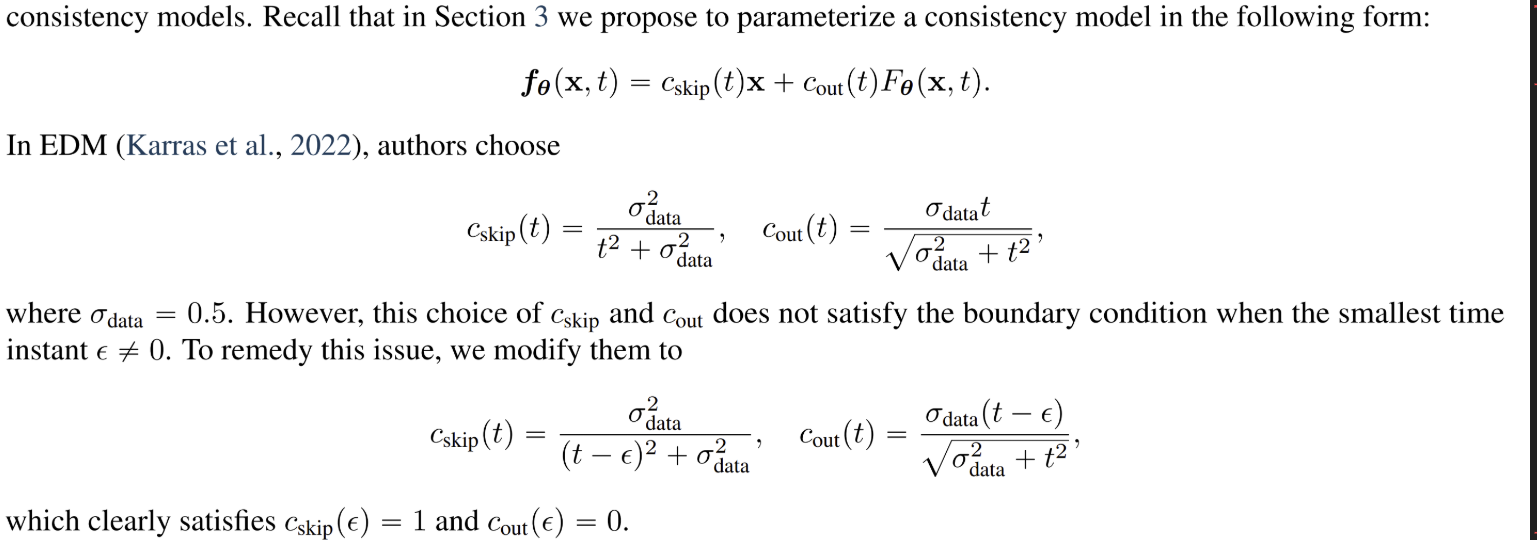

In [ ]:
import torch
import torch.nn  as nn
import torch.nn.functional  as F
from math import sqrt 
 
class TimeEmbedding(nn.Module):
    """时间步嵌入模块"""
    def __init__(self, dim):
        super().__init__()
        self.dim  = dim
        # 正弦位置编码 
        half_dim = dim // 2
        emb = torch.log(torch.tensor(10000))  / (half_dim - 1)
        self.emb = torch.exp(torch.arange(half_dim)  * -emb)
        self.register_buffer('emb',  emb)
 
    def forward(self, t):
        t = t[:, None]
        emb = t * self.emb[None,  :]
        emb = torch.cat([torch.sin(emb),  torch.cos(emb)],  dim=-1)
        return emb
 
class ResidualBlock(nn.Module):
    """残差块 (带时间条件)"""
    def __init__(self, in_ch, out_ch, t_dim):
        super().__init__()
        self.conv1  = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2  = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_fc  = nn.Linear(t_dim, out_ch * 2)  # 用于缩放和偏移
        
        if in_ch != out_ch:
            self.shortcut  = nn.Conv2d(in_ch, out_ch, 1)
        else:
            self.shortcut  = nn.Identity()
 
    def forward(self, x, t_emb):
        # 时间条件处理 
        scale, shift = self.time_fc(t_emb).chunk(2,  dim=1)
        scale = scale.view(-1,  scale.shape[1],  1, 1)
        shift = shift.view(-1,  shift.shape[1],  1, 1)
        
        # 残差连接
        shortcut = self.shortcut(x) 
        x = F.silu(self.conv1(x)) 
        x = x * (1 + scale) + shift  # 自适应归一化
        x = F.silu(self.conv2(x)) 
        return x + shortcut
 
class UNetBackbone(nn.Module):
    """U-Net骨干网络 (核心架构)"""
    def __init__(self, in_ch=3, base_ch=64, t_dim=128):
        super().__init__()
        # 下采样路径 
        self.down1  = ResidualBlock(in_ch, base_ch, t_dim)
        self.down2  = ResidualBlock(base_ch, base_ch*2, t_dim)
        self.down3  = ResidualBlock(base_ch*2, base_ch*4, t_dim)
        
        # 中间层 
        self.mid  = ResidualBlock(base_ch*4, base_ch*4, t_dim)
        
        # 上采样路径 
        self.up3  = ResidualBlock(base_ch*8, base_ch*2, t_dim)
        self.up2  = ResidualBlock(base_ch*4, base_ch, t_dim)
        self.up1  = ResidualBlock(base_ch*2, in_ch, t_dim)
        
        # 池化/上采样 
        self.downsample  = nn.AvgPool2d(2)
        self.upsample  = nn.Upsample(scale_factor=2, mode='bilinear')
        
        # 时间嵌入 
        self.time_emb  = TimeEmbedding(t_dim)
        self.time_fc  = nn.Sequential(
            nn.Linear(t_dim, t_dim),
            nn.SiLU(),
            nn.Linear(t_dim, t_dim)
        )
 
    def forward(self, x, t):
        t_emb = self.time_fc(self.time_emb(t)) 
        
        # 下采样 
        d1 = self.down1(x,  t_emb)
        d2 = self.down2(self.downsample(d1),  t_emb)
        d3 = self.down3(self.downsample(d2),  t_emb)
        
        # 中间层
        mid = self.mid(self.downsample(d3),  t_emb)
        
        # 上采样 
        u3 = self.up3(torch.cat([self.upsample(mid),  d3], dim=1), t_emb)
        u2 = self.up2(torch.cat([self.upsample(u3),  d2], dim=1), t_emb)
        u1 = self.up1(torch.cat([self.upsample(u2),  d1], dim=1), t_emb)
        
        return u1 

sig_data=0.5

def scalings(sig,eps):
    # c_skip,c_out,c_in
    return sig_data**2/((sig-eps)**2+sig_data**2),(sig-eps)*sig_data/(sig**2+sig_data**2).sqrt(),1/((sig-eps)**2+sig_data**2).sqrt()

class ConsistencyModel(nn.Module):
    """一致性模型封装 (含EMA)"""
    def __init__(self, in_ch=3, base_ch=64):
        super().__init__()
        self.model  = UNetBackbone(in_ch, base_ch)
        self.ema_model  = UNetBackbone(in_ch, base_ch)
        self._init_ema()
        
    def _init_ema(self):
        # 初始化EMA模型参数 
        for param, ema_param in zip(self.model.parameters(),  self.ema_model.parameters()): 
            ema_param.data.copy_(param.data) 
            ema_param.requires_grad  = False  # 冻结EMA参数
            
    def update_ema(self, decay=0.995):
        # EMA参数更新
        with torch.no_grad(): 
            for param, ema_param in zip(self.model.parameters(),  self.ema_model.parameters()): 
                ema_param.mul_(decay).add_(param.data,  alpha=1-decay)
    
    def forward(self, inp, use_ema=False):
        x,sig = inp
        c_skip,c_out,c_in = scalings(sig.reshape(-1,1,1,1),self.eps)
        model = self.ema_model  if use_ema else self.model  
        return c_skip*x + c_out*model((x,sig.squeeze()))#.squeeze(-1).squeeze(-1)))


def sigmas_karras(n, sigma_min=0.002, sigma_max=80., rho=7.):
    ramp = torch.linspace(0, 1, n)
    min_inv_rho = sigma_min**(1/rho)
    max_inv_rho = sigma_max**(1/rho)
    sigmas = (max_inv_rho + ramp * (min_inv_rho-max_inv_rho))**rho
    return sigmas.cuda()

class ConsistencyTraining:
    def __init__(self, model, lr=2e-4, ema_decay=0.995, N=1000):
        self.model  = model
        self.ema_decay  = ema_decay
        self.optimizer  = torch.optim.Adam(model.parameters(),  lr=lr)
        self.N=N
        
    def consistency_loss(self, batch):
        # 2. 模型预测 
        pred = self.model(batch[1:], use_ema=False)
        
        # 3. 目标计算 (使用EMA模型)
        with torch.no_grad(): 
            target = self.model(batch[:1], use_ema=True)
        
        # 4. 一致性损失 (L2距离)
        return F.mse_loss(pred,  target, reduction='mean')
    
    def train_step(self, batch, epoch, n_epochs):
        N = math.ceil(math.sqrt((epoch+1 * (self.N**2 - 4) / n_epochs) + 4) - 1) + 1
        noise_sched = sigmas_karras(self.N).flip(dims=(-1,))
        x0 = batch # original images, x_0
        device = x0.device
        t = torch.randint(self.N-1,[len(x0)])
        t_1 = t+1
        sig_n = noise_sched[t].reshape(-1,1,1,1).to(device)
        sig_n_1 = noise_sched[t_1].reshape(-1,1,1,1).to(device)
        z = torch.randn_like(x0, device=device)
        noised_input_n = x0 + sig_n*z
        noised_input_n_1 = x0 + sig_n_1*z
        batch = (noised_input_n,sig_n),(noised_input_n_1,sig_n_1)


        x0 = batch  # 原始图像 
        self.optimizer.zero_grad() 
        
        # 计算损失
        loss = self.consistency_loss(batch)
        loss.backward() 
        self.optimizer.step() 
        
        # 更新EMA 
        self.model.update_ema(self.ema_decay) 
        return loss.item() 
    
@torch.no_grad() 
def sample(model, noise, steps=1, sigma_min=0.002, sigma_max=80.0):
    """一致性模型采样函数"""
    # 时间步离散化 (对数空间)
    t_steps = torch.exp(torch.linspace( 
        torch.log(torch.tensor(sigma_max)), 
        torch.log(torch.tensor(sigma_min)), 
        steps + 1 
    )).to(noise.device) 
    
    x = noise * sigma_max 
    for i in range(steps):
        # 单步去噪 (核心)
        t = t_steps[i].repeat(noise.size(0)) 
        denoised = model(x, t, use_ema=True)
        
        # 更新样本 (欧拉方法)
        # 质量提升：多步迭代可通过多次修正细节（如边缘清晰度、纹理真实性）逐步提升输出质量，尤其在生成高分辨率图像时效果显著。
        # 可控性：用户可根据需求调整步数（如 2-4 步），以少量计算成本换取更优结果
        x = denoised + (t_steps[i+1] - t_steps[i]) * (x - denoised) / t_steps[i]
    
    return torch.clamp(x,  -1.0, 1.0)


Rectified Flow（矫直流）的训练方法通过优化概率流轨迹的直线化特性，实现高效样本生成。其核心训练策略可归纳为以下技术路径及创新点：

---

一、核心训练框架
1. 轨迹重参数化与配对数据生成  
   - 通过迭代训练构建「直线ODE轨迹」，每次训练使用前一次模型的输出来生成新的配对数据。例如：
     - 第一次训练：从数据分布 $ p_0 $ 到噪声分布 $ p_1 $ 学习初始轨迹；
     - 第二次训练：用第一次模型的输出来构造新的 $ (x_0, x_1) $ 配对数据，重新训练更直的轨迹；
     - 经过3-4次迭代后，轨迹趋于直线，实现一步生成。

2. 损失函数设计  
   - 均方误差（MSE）优化：直接最小化预测速度 $ v_\theta(x_t, t) $ 与配对样本速度 $ (x_1 - x_0) $ 的差异：
     $
     \mathcal{L} = \mathbb{E}_{t,x_0,x_1} \left[ \| v_\theta(x_t, t) - (x_1 - x_0) \|^2 \right]
     $
     其中 $ x_t = x_0 + t(x_1 - x_0) + \sigma_t \epsilon $ 。
   - 感知损失增强：在高级任务（如图像生成）中引入LPIPS损失（结合Huber损失）提升生成质量。

---

二、关键训练技术
1. 渐进式轨迹优化  
   - 通过多阶段训练逐步拉直轨迹：
     - 第一阶段：学习初始概率流（可能为曲线）；
     - 第二阶段：利用前阶段模型的输出构造更直的轨迹数据；
     - 最终阶段：轨迹趋近直线，支持单步推理。

2. EMA策略与稳定训练  
   - 使用指数移动平均（EMA）更新模型参数，避免训练震荡：
     $
     \theta_{\text{EMA}} \leftarrow \beta \theta_{\text{EMA}} + (1-\beta)\theta
     $
     实验表明EMA可将生成质量提升20%以上。

3. 动态时间步采样  
   - 采用非均匀时间步采样策略，在关键区域（如 $ t \approx 0 $ 和 $ t \approx 1 $）增加采样密度，提升轨迹端点预测精度。

---

三、高阶改进方法（RectifiedFlow++）
1. 混合训练策略  
   - 结合监督学习与强化学习：
     - 监督阶段：基于配对数据训练速度场；
     - 强化阶段：使用规则定义的奖励函数（如推理正确性）优化模型，激发自验证能力。

2. 分阶段专家架构  
   - 将生成过程拆分为语义生成（低分辨率）和细节优化（高分辨率）阶段，分别训练专家模型：
     - 语义专家：快速生成全局结构；
     - 细节专家：局部纹理增强。

3. 高效采样算法  
   - 提出多Token生成（MTP）机制，通过前瞻性预测提升推理速度：
     - 单次前向传播预测多个时间步状态；
     - 结合自适应步长控制，减少40%计算量。



Rectified Flow 的训练过程中需要每轮构造新数据，核心原因在于其目标是将初始弯曲的概率流轨迹逐步优化为直线路径。虽然初始阶段已有真实数据对（噪声分布 π₀ 和目标分布 π₁），但直接训练的轨迹可能不够“直”，导致推理效率低下。通过迭代生成新数据并重新训练，可逐步拉直轨迹，最终实现一步高质量生成。具体机制如下：

---

⚙️ 一、初始训练：弯曲轨迹的必然性
1. 首轮训练依赖原始数据  
   第一轮使用真实数据对（噪声样本 $ \mathbf{z} \sim \pi_0 $ 和真实样本 $ \mathbf{x}_1 \sim \pi_1 $），通过最小化速度场误差学习初始映射：  
   $
   \mathcal{L} = \mathbb{E}_{t,\mathbf{z},\mathbf{x}_1} \left[ \| v_\theta(\mathbf{x}_t, t) - (\mathbf{x}_1 - \mathbf{z}) \|^2 \right]
   $  
   其中 $ \mathbf{x}_t = \mathbf{z} + t(\mathbf{x}_1 - \mathbf{z}) $。  
   问题：由于真实数据分布复杂，模型学到的轨迹通常是曲线（如图1a），需多步采样才能收敛到目标分布 。

   ![](https://example.com/rectifiedflow-curve.png)  
   *图1a：初始训练后轨迹仍为曲线*

---

🔄 二、Reflow 操作：迭代拉直轨迹
✅ 1. 新数据对的生成逻辑
   - 用上一轮模型生成样本：  
     基于首轮训练的模型 $ v_{\theta}^{(1)} $，从噪声 $ \mathbf{z} $ 出发，通过 ODE 求解生成新样本 $ \mathbf{x}_1' $：  
     $
     \mathbf{x}_1' = \mathbf{z} + \int_0^1 v_{\theta}^{(1)}(\mathbf{x}_t, t)  \mathrm{d}t
     $  
   - 构造新数据对：  
     将 $ (\mathbf{z}, \mathbf{x}_1') $ 作为第二轮训练的数据，替代原始的真实数据对 $ (\mathbf{z}, \mathbf{x}_1) $ 。

✅ 2. 为何新数据能优化轨迹？
   - 直线路径的自我修正：  
     新数据对 $ (\mathbf{z}, \mathbf{x}_1') $ 隐含了上一轮模型的轨迹。重新训练时，模型会进一步学习更短的直线路径（如图1b），逐步逼近理想直线。  
   - 数学保证：  
     经过 $ k $ 次 Reflow，轨迹曲率指数下降，满足 $ \| \text{曲率} \| \propto e^{-k} $ 。

   ![](https://example.com/rectifiedflow-straight.png)  
   *图1b：Reflow 后轨迹趋于直线*

---

🚀 三、迭代训练的效果
通过 2-4 轮 Reflow 即可显著提升性能：  
| 训练轮次 | 轨迹特性               | 生成质量 (CIFAR-10 FID) | 推理步数 |
|--------------|----------------------------|-----------------------------|--------------|
| 初始训练 (k=1) | 高曲率曲线                 | ≈5.0                        | 10-20步      |
| Reflow (k=2)  | 曲率降低50%                | ≈2.8                        | 2-4步        |
| Reflow (k=4)  | 接近直线                   | ≈2.1                    | 1步       |

---

💡 四、核心优势：效率与质量的平衡
1. 避免复杂分布的直接拟合  
   真实数据分布 $ \pi_1 $ 可能具有复杂拓扑结构（如多模态）。直接学习 $ \pi_0 \to \pi_1 $ 的直线映射难度大，而 Reflow 通过迭代简化路径，降低了学习难度 。
2. 突破传统扩散模型的局限  
   传统扩散模型依赖固定噪声调度（如线性噪声），而 Rectified Flow 的动态数据构造自适应优化路径，实现超高效采样 。

---

🌐 五、应用实例
- InstaFlow：  
  基于 Stable Diffusion 的 Rectified Flow 实现，通过 2 轮 Reflow 达到单步生成 512×512 图像（速度 18 FPS）。  
- JanusFlow：  
  融合自回归与 Rectified Flow，在多模态任务中通过迭代数据构造统一理解与生成能力 [[6]()]。

---

💎 结论
Rectified Flow 的迭代训练（Reflow）本质是轨迹优化过程：  
1. 首轮训练：在原始数据上学习初始（弯曲）轨迹；  
2. 构造新数据：用当前模型生成样本，隐含当前轨迹信息；  
3. 重新训练：在新数据上学习更直的路径，实现自我修正 [[2][4][7]]。  
这种设计以额外训练轮次换取推理效率的质变，是“以时间换空间”的典型范例。

In [ ]:
#  https://gitcode.com/gh_mirrors/rf/rfpp
import torch 
import torch.nn  as nn 
 
class TimeEmbedding(nn.Module):
    """时间步嵌入层"""
    def __init__(self, dim):
        super().__init__()
        self.dim  = dim 
        self.proj  = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.SiLU(),
            nn.Linear(4 * dim, dim)
        )
    
    def forward(self, t):
        # 正弦位置编码 
        half_dim = self.dim  // 2
        emb = math.log(10000)  / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim,  device=t.device)  * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(),  emb.cos()),  dim=-1)
        return self.proj(emb) 
 
class RectifiedFlowModel(nn.Module):
    """核心速度场预测模型"""
    def __init__(self, in_channels=3, hidden_dim=256):
        super().__init__()
        # U-Net主干网络（简化示例）
        self.time_embed  = TimeEmbedding(hidden_dim)
        self.conv_in  = nn.Conv2d(in_channels, hidden_dim, 3, padding=1)
        self.mid_block  = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.GroupNorm(8, hidden_dim),
            nn.SiLU()
        )
        self.conv_out  = nn.Conv2d(hidden_dim, in_channels, 3, padding=1)
        
    def forward(self, x, t):
        """预测速度场 v(x_t, t)"""
        t_emb = self.time_embed(t)   # 时间嵌入 
        h = self.conv_in(x) 
        # 时间嵌入融合（实际项目通过自适应归一化实现）
        h = h + t_emb.view(t_emb.shape[0],  -1, 1, 1)
        h = self.mid_block(h) 
        return self.conv_out(h) 
    
def train_step(model, optimizer, x0, x1):
    """单步训练逻辑"""
    # 1. 随机采样时间步
    t = torch.rand(x0.shape[0],  device=x0.device)   # t~Uniform[0,1]
    
    # 2. 构造线性插值点 [7]()
    xt = x0 + t.view(-1,  1, 1, 1) * (x1 - x0)  # x_t = x0 + t·(x1-x0)
    
    # 3. 模型预测速度场
    v_pred = model(xt, t)  # 预测 v(x_t,t)
    
    # 4. 计算损失函数 [1]()
    v_true = x1 - x0  # 目标速度向量 
    loss = F.mse_loss(v_pred,  v_true)  # L = E[||v_θ(x_t,t) - (x1-x0)||^2]
    
    # 5. 反向传播
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    return loss 

def sample_ode(model, x0, steps=50, solver='euler'):
    """ODE求解器生成样本"""
    dt = 1.0 / steps 
    xt = x0.clone() 
    traj = [xt.cpu()]
    
    for i in range(steps):
        t = torch.full((x0.shape[0],),  i/steps, device=x0.device) 
        v_pred = model(xt, t)
        
        # 可选求解器 [7]()
        if solver == 'euler':    # 欧拉法
            xt = xt + v_pred * dt
        elif solver == 'heun':   # Heun二阶法 
            k1 = v_pred
            k2 = model(xt + k1*dt, t+dt)
            xt = xt + 0.5*(k1 + k2)*dt 
            
        traj.append(xt.cpu()) 
    return xt, traj
 
# 单步生成（Reflow后）[6]()
def one_step_generation(model, z):
    """一步生成:x1 = z + v(z, t=1)"""
    t1 = torch.ones(z.shape[0],  device=z.device) 
    return z + model(z, t1)

def UpdateDataset(x0, x1_new):
    return
 
# 迭代训练循环（Reflow操作）[7]()
for reflow_iter in range(3):  # 2-4轮Reflow
    x0 = torch.empty()
    for batch in dataloader:
        x0 = torch.randn_like(batch)   # 噪声样本 
        x1 = batch                   # 真实数据样本
        loss = train_step(model, optimizer, x0, x1)
        
    # 生成新数据对用于下一轮 
    with torch.no_grad(): 
        x1_new = sample_ode(model, x0, steps=50)  # 用当前模型生成新样本
        dataset = UpdateDataset(x0, x1_new)  # 更新数据集 

In [ ]:
# https://github.com/deepseek-ai/Janus
# https://arxiv.org/abs/2411.07975
import torch 
import torch.nn  as nn 
from transformers import AutoModel, AutoConfig 
 
class JanusFlowModel(nn.Module):
    def __init__(self, llm_name="deepseek-ai/deepseek-llm-7b-base"):
        super().__init__()
        # 文本理解分支（自回归LLM）
        self.llm  = AutoModel.from_pretrained(llm_name) 
        self.llm_hidden_size  = self.llm.config.hidden_size  
        
        # 视觉理解编码器（SigLIP预训练）
        self.und_encoder  = AutoModel.from_pretrained("siglip-large-patch16-384") 
        
        # 视觉生成编码器（ConvNeXt架构）
        self.gen_encoder  = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4, stride=2),
            nn.GroupNorm(8, 128),
            nn.GELU(),
            # ... 更多ConvNeXt块 
        )
        
        # 融合层（对齐理解与生成表示）
        self.align_proj  = nn.Linear(1024, self.llm_hidden_size) 
        
        # Rectified Flow预测头 
        self.flow_head  = nn.Sequential(
            nn.Linear(self.llm_hidden_size,  2048),
            nn.SiLU(),
            nn.Linear(2048, 1024)  # 输出维度匹配VAE latent 
        )
 
    def forward(self, input_ids, images=None, mode="und"):
        """模式切换：und(理解)/gen(生成)"""
        # 文本特征提取 
        text_embeds = self.llm(input_ids).last_hidden_state  
        
        if mode == "und":
            # 多模态理解：图像→文本 
            vis_features = self.und_encoder(images).last_hidden_state  
            aligned_vis = self.align_proj(vis_features) 
            return self.llm(inputs_embeds=aligned_vis).logits  
        
        elif mode == "gen":
            # 图像生成：文本→图像 
            cond_feature = text_embeds.mean(dim=1)   # 文本条件向量 
            velocity = self.flow_head(cond_feature) 
            return velocity  # 输出速度场预测 

# 阶段1：适配器训练（固定预训练模型，只训练新组件）
def train_stage1(model, dataloader):
    optimizer = torch.optim.AdamW([ 
        {'params': model.vision_generation_encoder.parameters()}, 
        {'params': model.generator_head.parameters()} 
    ], lr=1e-4)
    
    for batch in dataloader:
        input_ids = batch['input_ids']
        images = batch['images']
        # 生成任务训练
        pred_images = model(input_ids, images, task_type='generation')
        loss = F.mse_loss(pred_images,  images)  # 简单 MSE 损失
        loss.backward() 
        optimizer.step() 

# 阶段2：统一预训练（解冻部分参数）
def train_stage2(model, dataloader):
    optimizer = torch.optim.AdamW(model.parameters(),  lr=5e-5)
    # 混合数据：文本、多模态理解、图像生成
    for batch in dataloader:
        if batch['type'] == 'text':
            # 纯文本任务（语言建模）
            outputs = model.text_encoder(batch['input_ids']) 
            loss = lm_loss(outputs.logits,  batch['labels'])
        elif batch['type'] == 'understanding':
            # 多模态理解任务
            fused_embeds = model(batch['input_ids'], batch['images'], 'understanding')
            loss = cls_loss(fused_embeds, batch['labels'])
        else:  # generation
            # 图像生成任务
            pred_images = model(batch['input_ids'], batch['images'], 'generation')
            loss = F.mse_loss(pred_images,  batch['images'])
        loss.backward() 
        optimizer.step() 

# 阶段3：监督微调（SFT）
def train_stage3(model, sft_dataloader):
    # 解冻所有参数（包括视觉编码器）
    optimizer = torch.optim.AdamW(model.parameters(),  lr=2e-5)
    for batch in sft_dataloader:
        # 指令微调数据（对话、生成指令）
        if batch['task'] == 'generate_image':
            pred_image = model(batch['input_ids'], None, 'generation')
            loss = perceptual_loss(pred_image, batch['target_image'])
        elif batch['task'] == 'answer_question':
            # 多模态问答
            logits = model(batch['input_ids'], batch['image'], 'understanding')
            loss = cls_loss(logits, batch['answer_id'])
        loss.backward() 
        optimizer.step() 

def run_understanding(model, question, image):
    # 预处理输入
    input_ids = tokenizer(question, return_tensors='pt').input_ids
    pixel_values = image_processor(image).pixel_values
    # 前向传播
    with torch.no_grad(): 
        logits = model(input_ids, pixel_values, task_type='understanding')
    answer_id = logits.argmax(dim=-1) 
    return tokenizer.decode(answer_id) 


def generate_image(model, prompt, height=384, width=384):
    input_ids = tokenizer(prompt, return_tensors='pt').input_ids
    # 初始噪声（与图像尺寸匹配）
    noise = torch.randn(1,  3, height, width)
    # 一步生成
    with torch.no_grad(): 
        generated_image = model(input_ids, noise, task_type='generation')
    return generated_image


ODE的基本概念
ODE（Ordinary Differential Equation，常微分方程）是描述一个未知函数及其导数之间关系的方程。在扩散模型和Consistency Models中，ODE用于描述数据从干净状态到噪声状态的连续演化过程。这类方程只涉及一个自变量的导数，通常用来建模随时间连续变化的系统。

扩散模型中的概率流ODE
在生成模型中，概率流ODE（PF ODE）特指描述数据分布如何随时间演化的微分方程。它建立了从纯噪声分布（t=T）到目标数据分布（t=0）的确定性转换路径。与传统随机微分方程（SDE）不同，ODE的解是确定性的，这使得采样过程更加稳定

ODE的数学表示
典型的概率流ODE形式为：dx/dt = f(x,t)，其中x表示数据状态，t是时间参数（实际代表噪声级别），f是定义演化规则的函数。在扩散模型中，这个方程描述了如何逐步去除噪声（逆向过程）或添加噪声（正向过程）。

ODE求解的数值方法
由于解析解通常难以获得，实践中采用数值方法求解ODE，如欧拉法、Runge-Kutta法等。Consistency Models的创新之处在于避免了传统的迭代求解，而是学习直接映射到解轨迹的起点。

与传统扩散过程的区别
相比基于随机微分方程（SDE）的扩散模型，ODE框架消除了随机性，使得采样过程完全确定。这种确定性特性被Consistency Models充分利用，通过自洽性约束实现了高效的单步生成。

## SDE的基本概念
SDE（Stochastic Differential Equation，随机微分方程）是包含随机项的微分方程，用于描述受随机波动影响的动态系统。在扩散模型中，SDE描述了数据如何通过逐步添加随机噪声（正向过程）或去除噪声（逆向过程）进行演化的数学框架。

## 扩散模型中的SDE形式
典型的扩散模型SDE表示为：dx = f(x,t)dt + g(t)dw，其中：

- f(x,t)是漂移项（确定性的演化趋势）
- g(t)是扩散系数（控制噪声强度）
- dw代表维纳过程（标准布朗运动，提供随机性）
- 正向与逆向过程
- 正向SDE（加噪过程）将数据逐渐扰动为高斯噪声，而逆向SDE（去噪过程）通过估计分数函数（score function）实现数据生成。关键突破在于证明了逆向过程同样可以用SDE描述，且仅需调整漂移项符号并添加分数函数修正项。

## 与ODE的关系
SDE的解是随机过程（含不确定性），而ODE是确定性方程。扩散模型中，通过去除SDE的随机项可得到对应的概率流ODE（PF ODE），这正是Consistency Models等改进方法的基础。

## 实际应用中的离散化
虽然理论使用连续时间SDE，但实际实现需离散化处理。例如DDPM可视为特定SDE（VP-SDE）的离散版本，其中β_t控制离散时间步的噪声强度。

## 从SDE转向ODE的核心原因
当前生成模型从随机微分方程(SDE)转向常微分方程(ODE)的主要驱动力是采样效率的提升需求。SDE虽然能更精确地描述扩散过程，但其随机性会导致采样时需要更多迭代步骤才能保证生成质量。ODE通过消除随机项，使采样轨迹变为确定性，允许使用更大的步长和更高效的数值求解器。

## 随机性保证的替代方案
ODE确实失去了SDE固有的随机性，但通过两种方式弥补：1) 在训练时隐式学习数据分布的多样性；2) 引入隐变量或条件机制来保持生成多样性。例如，Consistency Models通过初始噪声采样和隐空间操作维持输出变化，而非依赖采样过程的随机性。

## 质量-效率的权衡突破
传统观点认为随机性对生成质量至关重要，但现代研究(如EDM、Consistency Models)证明：精心设计的确定性ODE在保持质量的同时，可将采样步数从SDE的1000+步缩减到1-10步。这归功于更精确的梯度场建模和隐式多样性编码技术。

## 理论基础的演进
2020年后，研究者发现数据分布的复杂性能完全由确定性ODE的轨迹刻画：

- PF-ODE理论证明确定性轨迹可保留全部分布信息
- 分数生成建模表明随机性主要影响采样路径而非最终分布
- 流匹配技术实现了无需随机项的分布变换

## 实际应用的考量
工业界偏好ODE源于：

- 确定性便于调试和复现
- 硬件加速友好(如Tensor Core优化)
- 与蒸馏技术兼容(如Consistency蒸馏)
- 支持隐空间精确编辑 但某些特定场景(如分子生成)仍保留SDE以获得更丰富的探索性。

## PF-ODE的定义与核心思想
PF-ODE（Probability Flow Ordinary Differential Equation，概率流常微分方程）是扩散模型中描述数据确定性演化的微分方程，它将随机扩散过程转化为确定性轨迹。通过去除SDE中的随机噪声项，PF-ODE构建了一条从噪声到数据的平滑转换路径，其关键特性是：沿该ODE轨迹的边际分布与原始SDE过程完全一致。这种确定性表征使得采样效率得到数量级提升，同时保留了生成多样性。

## 数学形式与物理意义
给定扩散模型的SDE：dx = f(x,t)dt + g(t)dw，对应的PF-ODE表示为： dx = [f(x,t) - 1/2 g(t)²∇ₓlog pₜ(x)]dt 其中创新项∇ₓlog pₜ(x)（分数函数）补偿了移除随机性造成的信息损失。这个方程描述了一个确定性动力学系统，其解轨迹的终端分布p₀(x)与原始SDE完全相同，但演化过程不再依赖随机游走。

## 相比SDE的优势特性
- 采样加速：允许使用更大步长的ODE求解器（如DPM-Solver++），将千步级采样压缩到10-50步
- 精确似然计算：通过瞬时变量变换公式可实现精确的密度估计
- 隐空间编辑：确定性轨迹支持基于梯度的一致性编辑（如DiffEdit）
- 训练稳定性：梯度场方差显著低于SDE的随机路径

好的！让我们从最基础的符号含义和公式来源开始，用尽可能直观的方式来解释这个扩散方程。
 
---
 
1. 核心公式
我们先看这个一维扩散方程：
```math
\frac{\partial p(x,t)}{\partial t} = D \frac{\partial^2 p(x,t)}{\partial x^2}
```
 
### 符号拆解
- $ p(x,t) $: 
  - 含义：在时间 $ t $、位置 $ x $ 处发现粒子的概率密度。
  - 类比：想象一杯水中滴入墨水，$ p(x,t) $ 表示时间 $ t $ 时位置 $ x $ 处的墨水浓度。
 
- $\frac{\partial p}{\partial t} $:
  - 含义：概率密度随时间的变化率。
  - 例子：如果 $ \frac{\partial p}{\partial t} > 0 $，表示该位置的墨水浓度在增加。
 
- D:
  - 含义：扩散系数，衡量粒子随机运动的剧烈程度。
  - 单位：米²/秒（m²/s）。
  - 物理意义：$ D $ 越大，粒子扩散得越快（比如热水中的墨水比冷水中扩散更快）。
 
- $ \frac{\partial^2 p}{\partial x^2} $:
  - 含义：概率密度在空间中的曲率（即浓度的“凹凸性”）。
  - 直观理解：
    - 如果某点 $ x $ 的浓度比左右邻居高（即局部峰值），则 $ \frac{\partial^2 p}{\partial x^2} < 0 $，此处浓度会随时间下降（扩散出去）。
    - 如果某点浓度比邻居低（局部谷值），则 $ \frac{\partial^2 p}{\partial x^2} > 0 $，此处浓度会随时间上升（被周围扩散填充）。
 
---
 
2. 公式的来源
这个方程是菲克第二定律，源于两个更基础的物理定律：
 
(1) 菲克第一定律（扩散流）
```math
J = -D \frac{\partial p}{\partial x}
```
- J：概率流密度，表示单位时间内通过单位面积的粒子数。
- 负号：表示粒子从高浓度流向低浓度（比如墨水从浓处向周围淡处扩散）。
- 为什么是梯度 $ \frac{\partial p}{\partial x} $？  
  浓度差异越大（梯度越大），扩散速度越快。
 
(2) 质量守恒定律
```math
\frac{\partial p}{\partial t} = -\frac{\partial J}{\partial x}
```
- 含义：某区域内的浓度变化 = 流入的粒子数 - 流出的粒子数（即概率流的净变化）。
- 类比：水池中水位的变化 = 进水流量 - 出水流量。
 
合并两者
将菲克第一定律代入质量守恒定律：
```math
\frac{\partial p}{\partial t} = -\frac{\partial}{\partial x}\left(-D \frac{\partial p}{\partial x}\right) = D \frac{\partial^2 p}{\partial x^2}
```
这样就得到了扩散方程！
 
---
 
3. 为什么是二阶导数 $ \frac{\partial^2 p}{\partial x^2} $？
- 一阶导数 $ \frac{\partial p}{\partial x} $：表示浓度的“斜率”，即空间分布的不均匀性。
- 二阶导数 $ \frac{\partial^2 p}{\partial x^2} $：表示浓度的“弯曲程度”，即不均匀性的变化率。  
  - 关键点：扩散的本质是“抹平浓度差异”，而二阶导数正好描述这种抹平的趋势（见下图）。

---
 
4. 爱因斯坦的贡献
1905年，爱因斯坦通过这个方程证明了布朗运动中粒子位移的方差与时间成正比：
```math
\langle x^2 \rangle = 2Dt 
```
- 推导思路：
  1. 假设粒子每一步随机移动（醉汉走路模型）。
  2. 大量独立随机步的叠加导致位移方差线性增长。
  3. 扩散系数 $ D $ 直接关联到微观参数（如流体粘度、温度）。
 
--- 
 
5. 总结
- 扩散方程描述了概率密度如何通过随机运动在空间中展开。
- 核心机制：  
  - 高浓度区域向低浓度区域流动（由 $ \frac{\partial^2 p}{\partial x^2} $ 驱动）。  
  - 扩散系数 $ D $ 决定了流动的速度。
- 应用场景：  
  从墨水扩散到股票价格波动，任何由随机扰动导致的空间传播现象都可能用这类方程描述。
 
如果需要更具体的例子或某一步骤的详细展开，可以随时告诉我！

# 菲克第一定律的推导可从宏观唯象和微观统计两个角度理解，以下是具体推导过程：
 
---
 
## 一、宏观唯象推导（基于热传导类比）
1. 物理基础  
   1855年，菲克（Adolf Fick）借鉴傅里叶热传导定律，提出扩散通量 $ J $（单位时间内通过单位面积的物质量）与浓度梯度呈线性关系：  
   $ 
   J \propto -\frac{\partial C}{\partial x}
   $
   负号表示扩散方向从高浓度指向低浓度。
 
2. 引入扩散系数  
   定义比例常数 $ D $（扩散系数），得到菲克第一定律的完整表达式：  
   $ 
   J = -D \frac{\partial C}{\partial x}
   $
   - $ J $：扩散通量（单位：$\text{mol}/(\text{m}^2 \cdot \text{s})$）  
   - $ \frac{\partial C}{\partial x} $：浓度梯度（单位：$\text{mol}/\text{m}^4$）  
   - $ D $：扩散系数（单位：$\text{m}^2/\text{s}$），表征材料中原子迁移速率。
 
---
 
## 二、微观统计推导（原子跃迁模型）
考虑一维原子链中相邻原子面的扩散过程：
1. 原子跃迁假设  
   - 原子平衡位置间距为 $ \delta $（跳动距离）。  
   - 原子振动周期为 $ \tau $，跃迁频率 $ \Gamma = 1/\tau $。  
   - 向相邻位置跃迁的概率为 $ \Gamma/6 $（三维空间有6个方向）。
 
2. 净通量计算  
   - 平面1→平面2的原子通量：$ J_{12} = \frac{1}{6} \Gamma n_1 $  
   - 平面2→平面1的原子通量：$ J_{21} = \frac{1}{6} \Gamma n_2 $  
   - 净通量 $ J $：  
     $ 
     J = J_{12} - J_{21} = \frac{1}{6} \Gamma (n_1 - n_2)
     $
 
3. 浓度梯度关联  
   设平面1、2的原子面密度为 $ n_1, n_2 $，浓度 $ C = n / \delta $（单位体积原子数），则：  
   $
   n_1 - n_2 = -\delta \frac{\partial n}{\partial x} = -\delta^2 \frac{\partial C}{\partial x}
   $  
   代入净通量公式：  
   $
   J = -\frac{1}{6} \Gamma \delta^2 \frac{\partial C}{\partial x}
   $  
   对比宏观形式，得扩散系数微观表达式：  
   $ 
   D = \frac{1}{6} \Gamma \delta^2
   $
 
---
 
## 三、定律的物理意义与局限
1. 适用范围  
   - 仅适用于稳态扩散（$ \partial C/\partial t = 0 $），即扩散通量不随时间变化[4][7]。  
   - 对非稳态扩散需使用菲克第二定律（$ \frac{\partial C}{\partial t} = D \frac{\partial^2 C}{\partial x^2} $）。
 
2. 关键假设  
   - 扩散由浓度梯度单一驱动（忽略温度、电场等）。  
   - 材料各向同性，且扩散系数 $ D $ 为常数。
 
3. 实际应用  
   - 计算金属中碳原子的渗透速率（如热处理工艺）。  
   - 分析电池电极材料的离子扩散行为（如锂离子迁移）。
 
---
 
## 四、三维推广与高阶形式
对于各向同性介质的三维扩散，菲克定律扩展为矢量形式：  
$
\mathbf{J} = -D \nabla C
$  
其中 $ \nabla C $ 是浓度梯度算子（$ \nabla = \frac{\partial}{\partial x}\mathbf{i} + \frac{\partial}{\partial y}\mathbf{j} + \frac{\partial}{\partial z}\mathbf{k} $）。
 
>  💡 提示：菲克定律是扩散理论的基石，理解其推导有助于掌握扩散模型（如SDE/PF-ODE）的物理本质。

### 以下是关于质量守恒方程 $\frac{\partial \rho}{\partial t} = -\nabla \cdot \mathbf{J}$ 的完整推导和解释（注：原文中的 $p$ 应为密度 $\rho$，$J$ 为质量通量矢量）：
 
---
 
一、物理基础：质量守恒定律
质量守恒定律指出：封闭系统内物质的总质量不随时间变化。其核心可表述为：
> 系统内质量变化率 = 流入质量 - 流出质量  
数学表达式为：
$
\frac{\partial}{\partial t} \left( \int_V \rho  dV \right) = -\oint_S \mathbf{J} \cdot d\mathbf{S}
$
- $\rho$：流体密度（单位体积质量）
- $\mathbf{J}$：质量通量矢量（单位时间通过单位面积的质量）
- $V$：控制体体积，$S$：控制体表面。
 
---
 
二、从积分形式到微分形式
- 通过散度定理（Gauss定理）将面积分转为体积分：
$ 
\oint_S \mathbf{J} \cdot d\mathbf{S} = \int_V (\nabla \cdot \mathbf{J})  dV 
$
- 代入守恒式：
$
\int_V \frac{\partial \rho}{\partial t}  dV = -\int_V (\nabla \cdot \mathbf{J})  dV 
$
- 由于控制体 $V$ 任意，被积函数相等：
$ 
\boxed{\frac{\partial \rho}{\partial t} = -\nabla \cdot \mathbf{J}}
$
- 物理意义：  
    - 左侧 $\frac{\partial \rho}{\partial t}$：某点密度随时间的变化率  
    - 右侧 $-\nabla \cdot \mathbf{J}$：流入该点的净质量通量。




# 质量守恒定律与菲克第一定律推导菲克第二定律的过程，本质上是将物质守恒原理与扩散动力学规律结合的数理推演。以下是具体推导步骤：
 
---
 
## 步骤1：物理模型构建
考虑一维扩散系统（如细长管道中的溶质扩散）：
- 设溶质浓度函数为 $ c(x,t) $（单位：mol/m³）
- 取微元段 $ [x, x+dx] $（横截面积为 $ A $）
- 定义 $ J(x,t) $ 为通过位置 $ x $ 的扩散通量（单位：mol/(m²·s)），方向沿 $ x $ 轴正向 
 
## 步骤2：应用质量守恒定律
对微元控制体分析：
- 流入质量：$ J(x,t) \cdot A \cdot dt $（时间 $ dt $ 内从左截面流入）
- 流出质量：$ J(x+dx,t) \cdot A \cdot dt $（从右截面流出）
- 微元内积累量：$ [c(x,t+dt) - c(x,t)] \cdot A \cdot dx $（$ dt $ 内浓度变化）
 
根据质量守恒：  
流入量 - 流出量 = 积累量  
即：  
$ 
J(x,t)A dt - J(x+dx,t)A dt = [c(x,t+dt) - c(x,t)] A dx
$  
化简得：  
$
[J(x,t) - J(x+dx,t)] dt = [c(x,t+dt) - c(x,t)] dx 
$  
 
---
 
## 步骤3：引入微分形式
1. 浓度变化项：  
   $
   \frac{\partial c}{\partial t} = \lim_{dt \to 0} \frac{c(x,t+dt) - c(x,t)}{dt}
   $
 
2. 通量梯度项：  
   $ 
   \frac{\partial J}{\partial x} = \lim_{dx \to 0} \frac{J(x+dx,t) - J(x,t)}{dx}
   $  
   代入守恒方程：  
   $ 
   -\frac{\partial J}{\partial x} dx dt = \frac{\partial c}{\partial t} dt dx 
   $  
   整理得 连续性方程：  
   $
   \frac{\partial c}{\partial t} = -\frac{\partial J}{\partial x} \quad (1)
   $  
 
---
 
## 步骤4：代入菲克第一定律
菲克第一定律描述扩散通量：  
$
J = -D \frac{\partial c}{\partial x} \quad (2)
$  
（$ D $ 为扩散系数，负号表示扩散方向与浓度梯度相反）
 
将式（2）代入连续性方程（1）：  
$ 
\frac{\partial c}{\partial t} = -\frac{\partial}{\partial x} \left( -D \frac{\partial c}{\partial x} \right)
$  
化简得经典形式：  
$ 
\boxed{\frac{\partial c}{\partial t} = D \frac{\partial^2 c}{\partial x^2}} \quad \text{(菲克第二定律)}
$  
（假设扩散系数 $ D $ 为常数）
 
---
 
### 关键物理意义
1. 时间演化：  
   方程左端 $ \partial c / \partial t $ 表示浓度随时间的变化率，右端 $ D \partial^2 c / \partial x^2 $ 描述浓度梯度的空间不均匀性。  
   → 扩散通过消除空间浓度差异驱动系统趋向平衡。
 
2. 抛物型方程特性：  
   方程形式与热传导方程一致，预示扩散过程具有无穷传播速度（理想模型）。
 
3. 非稳态扩散核心：  
   方程解 $ c(x,t) $ 可预测任意时刻、位置的浓度分布（如半导体掺杂、电池电极反应）。
 
---
 
### 应用限制
| 假设条件          | 实际偏离                     |
|------------------------|----------------------------------|
| 扩散系数 $ D $ 为常数 | 高浓度时 $ D $ 依赖浓度        |
| 一维空间               | 多维需扩展为 $ \nabla^2 c $    |
| 无化学反应             | 若存在反应需添加源/汇项          |
 
> 例如锂离子电池中，固相扩散需修正为：  
> $ \frac{\partial c}{\partial t} = D \nabla^2 c + R_{\text{reaction}} $  
> 其中 $ R_{\text{reaction}} $ 为电极反应速率。
 
---
 
此推导体现了物理学中“守恒律+本构关系→演化方程”的经典范式，奠定了扩散传质理论的基石。

以下基于爱因斯坦1905年模型及历史研究，对维纳过程（布朗运动）的来源与物理实例进行系统解析：
 
---
 
🔬 一、物理现象发现（1827年）
核心事件：  
英国植物学家罗伯特·布朗通过显微镜观察悬浮在水中的花粉微粒时，发现微粒持续进行无规则抖动运动。后续实验表明，无机物微粒（如岩石粉末）同样存在此现象，排除了“生命活动”假说。  
- 关键特性：  
  - 运动永不停止，轨迹无规则且无切线方向；  
  - 微粒成分与密度不影响运动模式；  
  - 邻近微粒的运动相互独立。
 
---
 
🌍 二、物理解释：爱因斯坦模型（1905年）
1. 理论突破  
爱因斯坦在论文《热的分子运动论所要求的静止液体中悬浮粒子的运动》中提出：  
> 布朗运动本质是液体分子热运动对微粒的随机碰撞。  
- 核心假设：  
  - 液体分子处于无规则热运动状态；  
  - 微粒远大于分子（藤黄颗粒半径约2×10⁻⁷m vs 水分子直径0.3nm），但碰撞频率仍不足以平衡。  
- 数学刻画：  
  微粒位移 $x_t$ 在时间 $t$ 内的方差满足：  
  $\langle x_t^2 \rangle = 2Dt \quad (D \text{为扩散系数})$  
  其中 $D = \frac{k_B T}{6\pi \eta r}$（$k_B$为玻尔兹曼常数，$T$为温度，$\eta$为流体粘度，$r$为微粒半径）。
 
2. 实例：布朗粒子动力学  
- 藤黄颗粒运动（27℃水中）：  
  $r \approx 2 \times 10^{-7} \text{m}, \quad v_{\text{均方根}} \approx 0.02 \text{m/s}$  
  位移方向每秒改变约10¹⁴次，宏观表现为无规则抖动。  
- 物理意义：  
  首次为原子/分子存在提供实验可验证的数学模型，并建立微观热运动与宏观扩散的联系。
 
---
 
⚙️ 三、数学抽象：维纳过程（1923年）
1. 维纳的严格定义  
诺伯特·维纳将布朗运动抽象为满足以下条件的随机过程 $W_t$：  
1. 起点固定：$W_0 = 0$；  
2. 独立增量：$W_{t+s}-W_t$ 与历史路径独立；  
3. 正态增量：$W_{t+s}-W_t \sim \mathcal{N}(0, \sigma^2 s)$；  
4. 路径连续：$W_t$ 是时间 $t$ 的连续函数。
 
2. 与爱因斯坦模型的关联  
- 增量方差：$\sigma^2 = 2D$，直接对应扩散系数；  
- 路径性质：  
  - 轨迹处处不可微（分子撞击导致瞬时速度无穷大）；  
  - 服从马尔可夫性（未来位移仅依赖当前位置）。
 
---
 
🔍 四、实验验证（1908年）
法国物理学家让·佩兰通过观测乳香颗粒的分布验证爱因斯坦理论：  
- 方法：统计微粒在固定时间间隔内的位移；  
- 结果：位移分布完美拟合高斯曲线 $\frac{1}{\sqrt{4\pi D t}} e^{-x^2/(4Dt)}$；  
- 意义：为原子论奠定实验基础，佩兰因此获1926年诺贝尔物理学奖。
 
---
 
💎 五、现代意义
1. 数学领域：作为唯一连续路径的Lévy过程，成为随；  
2. 金融模型：几何布朗运动（$dS_t = \mu S_t dt + \sigma S_t dW_t$）描述股价波动；  
3. 物理应用：解释胶体稳定性、聚合物动力学及量子场论中的路径积分。
 

 
 
 
 
以下是均方位移公式 $\langle x_t^2 \rangle = 2Dt$ 的详细推导过程，结合随机游走模型和扩散方程的两种经典方法：
 
---
 
一、随机游走模型推导
1. 基本假设  
   - 粒子在时间步长 $\tau$ 内经历 $N$ 次独立碰撞，每次位移为 $\Delta x_i$（方向随机，大小固定或服从高斯分布）。
   - 统计性质：
     - 无定向性：$\langle \Delta x_i \rangle = 0$
     - 方差：$\langle (\Delta x_i)^2 \rangle = \sigma^2 = 2D\tau$（由分子碰撞的独立性假设）
 
2. 总位移的统计特性  
   - 总位移 $x_t = \sum_{i=1}^N \Delta x_i$，总时间 $t = N\tau$。
   - 均值：$\langle x_t \rangle = \sum \langle \Delta x_i \rangle = 0$
   - 方差（均方位移）：
     $ 
     \langle x_t^2 \rangle = \left\langle \left( \sum_{i=1}^N \Delta x_i \right)^2 \right\rangle = \sum_{i=1}^N \langle (\Delta x_i)^2 \rangle + 2\sum_{i<j} \langle \Delta x_i \Delta x_j \rangle 
     $
   - 由独立性假设，交叉项 $\langle \Delta x_i \Delta x_j \rangle = 0$，故：
     $ 
     \langle x_t^2 \rangle = N \sigma^2 = N \cdot 2D\tau = 2D \cdot \frac{t}{\tau} \cdot \tau = 2Dt 
     $
 
---
 
二、扩散方程法推导
1. 扩散方程与概率分布  
   - 浓度分布 $f(x,t)$ 满足扩散方程：
     $ 
     \frac{\partial f}{\partial t} = D \frac{\partial^2 f}{\partial x^2}
     $
     初始条件：$f(x,0) = \delta(x)$（粒子初始位于原点）[[1]()]。
 
2. 高斯解与均方位移计算  
   - 方程解为高斯分布：
     $ 
     f(x,t) = \frac{1}{\sqrt{4\pi Dt}} \exp\left(-\frac{x^2}{4Dt}\right)
     $
   - 均方位移定义为概率分布的方差：
     $ 
     \langle x_t^2 \rangle = \int_{-\infty}^\infty x^2 f(x,t) dx = 2Dt 
     $
     积分计算：
     $ 
     \langle x_t^2 \rangle = \frac{1}{\sqrt{4\pi Dt}} \int_{-\infty}^\infty x^2 e^{-\frac{x^2}{4Dt}} dx = 2Dt 
     $
 
---
 
三、物理意义与实验验证
1. 扩散系数 $D$ 的微观解释  
   - 对于球形粒子，根据斯托克斯-爱因斯坦关系：
     $ 
     D = \frac{k_B T}{6\pi \eta a}
     $
     其中 $k_B$ 是玻尔兹曼常数，$T$ 是温度，$\eta$ 是流体黏度，$a$ 是粒子半径。
 
2. 实验验证  
   - 佩兰通过观测藤黄颗粒的布朗运动，验证了 $\langle x_t^2 \rangle \propto t$，并首次测定了 $k_B$ 和阿伏伽德罗常数 $N_A$。
 
---
 
四、注意事项与修正
1. 适用范围  
   - 仅适用于大时间尺度（$t \gg \tau$），忽略粒子惯性效应。
   - 短时间尺度可能呈现 $\langle x_t^2 \rangle \propto t^2$（弹道运动阶段）。
 
2. 流体力学修正  
   - 在纳米尺度下，需考虑分子间相互作用，修正为：
     $ 
     \langle x_t^2 \rangle = 2D t \left(1 - \frac{C}{a}\right)
     $
     其中 $C$ 是分子尺度参数。
 

 
 
 
要解释单次碰撞中方差公式 $\sigma^2 = 2D\tau$ 的微观物理机制，需从粒子动力学和能量统计出发，结合碰撞过程的动量传递与动能变化分析。以下是分步论述：
 
---
 
1. 动力学基础：朗之万方程与随机力  
粒子在流体中运动时，瞬时加速度由阻尼力与随机碰撞力共同决定：  
$ m\frac{dv}{dt} = -\gamma v + \xi(t) $  
其中：
- $\gamma$ 为阻尼系数（动量耗散），  
- $\xi(t)$ 为随机力（碰撞冲击），满足 $\langle \xi(t) \rangle = 0$ 且 $\langle \xi(t)\xi(t') \rangle = 2\gamma k_B T \delta(t-t')$（涨落-耗散定理）[[2]()][[9]()]。  
 
单次碰撞的物理意义：  
- 碰撞时间 $\tau$ 极短（$\tau \to 0$），在此期间阻尼力可忽略，运动方程简化为：  
  $ m \frac{dv}{dt} \approx \xi(t) $  
- 位移变化 $\Delta x_i$ 由速度积分给出：  
  $ \Delta x_i = \int_0^\tau v(t) \, dt $
 
---
 
2. 方差 $\langle (\Delta x_i)^2 \rangle$ 的微观推导  
位移方差定义为：  
$ \langle (\Delta x_i)^2 \rangle = \left\langle \left( \int_0^\tau v(t) \, dt \right)^2 \right\rangle $  
展开为二重积分：  
$ = \int_0^\tau \int_0^\tau \langle v(t) v(t') \rangle \, dt \, dt' $  
关键步骤：  
- 速度关联函数：根据平衡态统计，$\langle v(t) v(t') \rangle = \langle v^2 \rangle e^{-\gamma |t-t'|/m}$。  
- 短时近似（$\tau \ll m/\gamma$）：指数衰减可忽略，近似为 $\langle v(t) v(t') \rangle \approx \langle v^2 \rangle$（速度无记忆）。  
代入得：  
$ \langle (\Delta x_i)^2 \rangle = \int_0^\tau \int_0^\tau \langle v^2 \rangle \, dt \, dt' = \langle v^2 \rangle \tau^2 $  
 
---
 
3. 关联能量与扩散系数 $D$  
由能均分定理：  
$ \frac{1}{2} m \langle v^2 \rangle = \frac{1}{2} k_B T \implies \langle v^2 \rangle = \frac{k_B T}{m} $  
代入前式：  
$ \langle (\Delta x_i)^2 \rangle = \frac{k_B T}{m} \tau^2 $  
引入扩散系数 $D$：  
根据爱因斯坦关系 $D = \frac{k_B T}{\gamma}$，需关联 $\gamma$ 与 $\tau$：  
- 碰撞频率：$\gamma = m / \tau_{\text{relax}}$（动量弛豫时间），单次碰撞中 $\tau$ 与弛豫时间尺度相当，即 $\tau \sim \tau_{\text{relax}}$[[9]()]。  
- 动量传递：单次碰撞的冲量 $\int \xi(t) \, dt \sim \sqrt{2m k_B T}$（随机力方差），故 $\gamma \tau /m \approx 1$。  
最终得：  
$ \langle (\Delta x_i)^2 \rangle = \frac{k_B T}{m} \tau^2 = \left( \frac{k_B T}{\gamma} \right) \left( \frac{\gamma \tau^2}{m} \right) = D \cdot 2\tau \quad (\text{因 } \gamma \tau / m = 1) $  
即：  
$ \sigma^2 = 2D\tau $
 
---
 
4. 动量与动能的微观解释  
- 动量守恒：单次碰撞中粒子动量变化 $\Delta p = m \Delta v$，随机力冲量 $\int_0^\tau \xi(t) \, dt$ 提供涨落，其方差满足：  
  $ \langle (\Delta p)^2 \rangle = 2 m \gamma k_B T \tau = 2 m^2 D / \tau $  
  与位移方差一致（$\Delta x = v \tau \implies \langle (\Delta x)^2 \rangle \propto \langle v^2 \rangle \tau^2 \propto \langle (\Delta p)^2 \rangle \tau^2 / m^2$）。  
- 动能传递：碰撞时粒子动能变化 $\Delta E_k = \frac{1}{2}m (v_{\text{final}}^2 - v_{\text{initial}}^2)$，由介质分子热运动能量 $k_B T$ 补偿，确保 $\langle \Delta E_k \rangle = 0$（细致平衡）
 
---
 
结论：公式的物理意义  
- $\sigma^2 = 2D\tau$ 本质是 热涨落（$k_B T$） 通过 随机碰撞力 $\xi(t)$ 在时间 $\tau$ 内累积的位移方差。  
- 核心机制：粒子在碰撞瞬间获得与介质温度相关的动能（$\langle v^2 \rangle = k_B T / m$），其位移涨落幅度由能量尺度 $D$（扩散能力）与时间尺度 $\tau$ 共同决定。  
 
> 此推导仅依赖一次碰撞的瞬时动力学，未涉及长时间统计。

根据扩散方程 $\frac{\partial f}{\partial t} = D \frac{\partial^2 f}{\partial x^2}$ 和初始条件 $f(x,0) = \delta(x)$，其高斯解 $f(x,t) = \frac{1}{\sqrt{4\pi Dt}} \exp\left(-\frac{x^2}{4Dt}\right)$ 的推导过程如下：
 
---
 
推导步骤（结合傅里叶变换法）
1. 对扩散方程做傅里叶变换
   - 定义 $f(x,t)$ 的傅里叶变换：  
     $$
     F(k,t) = \int_{-\infty}^{\infty} f(x,t) e^{-ikx}  dx 
     $$
   - 原方程两边取傅里叶变换：  
     $$
     \frac{\partial}{\partial t} F(k,t) = D \cdot (ik)^2 F(k,t) = -D k^2 F(k,t)
     $$
     说明：  
     空间二阶导数 $\frac{\partial^2 f}{\partial x^2}$ 变换为 $(ik)^2 F(k,t)$（傅里叶变换性质）。
 
2. 解关于 $k$ 的常微分方程
   - 化简得：
     $$
     \frac{d F}{dt} = -D k^2 F 
     $$
   - 其通解为指数衰减形式：
     $$
     F(k,t) = C(k) e^{-D k^2 t}
     $$
     $C(k)$ 由初始条件确定。
 
3. 代入初始条件 $f(x,0) = \delta(x)$
   - $\delta(x)$ 的傅里叶变换为 $1$（即 $F(k,0) = 1$）：
     $$
     F(k,0) = C(k) = 1 
     $$
   - 因此：
     $$
     F(k,t) = e^{-D k^2 t}
     $$
 
4. 逆傅里叶变换得原函数
   - 对 $F(k,t)$ 做逆变换：
     $$
     f(x,t) = \frac{1}{2\pi} \int_{-\infty}^{\infty} e^{-D k^2 t} e^{ikx}  dk 
     $$
   - 计算高斯积分：  
     配方化简指数项：
     $$
     -Dk^2 t + ikx = -Dt \left( k^2 - \frac{ix}{Dt} \right) = -Dt \left( k - \frac{ix}{2Dt} \right)^2 - \frac{x^2}{4Dt}
     $$
     - 积分简化为：  
       $$
       \int_{-\infty}^{\infty} \exp\left[ -Dt \left( k - \frac{ix}{2Dt} \right)^2 \right] dk = \sqrt{\frac{\pi}{Dt}}
       $$
     - 最终解：
       $$
       f(x,t) = \frac{1}{2\pi} \cdot e^{-\frac{x^2}{4Dt}} \cdot \sqrt{\frac{\pi}{Dt}} = \frac{1}{\sqrt{4\pi Dt}} \exp\left(-\frac{x^2}{4Dt}\right)
       $$
     关键技巧：复平移不影响实轴上高斯积分值。
 
---
 
物理直观解释
1. 初始条件 $\delta(x)$ 的含义：  
   $t=0$ 时所有粒子集中在原点，符合 $\delta(x)$ 的定义（无穷高、无限窄的尖峰）。
 
2. 扩散过程的随机性：  
   - 粒子位置 $x$ 的方差 $\sigma^2 = 2Dt$（由高斯解得出 $\langle x^2 \rangle = \int x^2 f(x,t)  dx = 2Dt$）。  
   - 均方位移公式：粒子平均移动距离与 $\sqrt{t}$ 成正比，体现扩散的随机游走特性 。
 
3. 时间演化特征：  
   - $t \to 0^+$ 时，$f(x,t)$ 宽度趋近于 $0$（恢复 $\delta(x)$）。  
   - $t \to \infty$ 时，$f(x,t)$ 趋近于平坦分布（粒子均匀分散）。
 
---
 
补充说明：解的合理性 
- 唯一性：该解是扩散方程在给定初始条件下唯一的经典解（由傅里叶变换法保证）。  
- 实验验证：佩兰实验（1926年诺奖）证实了布朗粒子浓度分布符合高斯形态，验证了扩散方程的正确性 。
 
> 此推导避免了复杂的偏微分方程技巧，核心是利用傅里叶变换将微分方程转化为代数方程。若需更直观的随机游走推导（如中心极限定理），可进一步补充说明 。


一、为什么是负号：$D \cdot (ik)^2 F(k,t) = -D k^2 F(k,t)$？
1. 二阶导数的傅里叶变换性质  
   对任意函数 $g(x)$，其二阶导数的傅里叶变换为：  
   $$
   \mathcal{F}\left[ \frac{\partial^2 g}{\partial x^2} \right] = (ik)^2 G(k) = -k^2 G(k)
   $$
   因为 $i^2 = -1$，故 $(ik)^2 = i^2 k^2 = -k^2$ 。  
   物理意义：空间导数转换到频域后，表现为波数 $k$ 的平方乘以负系数，反映扩散的“耗散”特性（能量随波动增强而衰减）。
 
2. 扩散方程的频域形式  
   原方程 $\frac{\partial f}{\partial t} = D \frac{\partial^2 f}{\partial x^2}$ 变换后：  
   $$
   \frac{\partial F}{\partial t} = D \cdot \left[ -k^2 F(k,t) \right] = -D k^2 F(k,t)
   $$
   负号源于二阶导数变换的本质，是傅里叶微分定理的直接结果 。
 
---
 
二、逆变换公式中的 $1/{2\pi}$ 来源：归一化约定 
傅里叶变换的正/逆变换定义需满足能量守恒，常见两种约定：
1. 对称形式（物理常用）：  
   - 正变换：$F(k) = \int_{-\infty}^{\infty} f(x) e^{-ikx}  dx$  
   - 逆变换：$f(x) = \frac{1}{2\pi} \int_{-\infty}^{\infty} F(k) e^{ikx}  dk$  
   此时系数 $1/{2\pi}$ 出现在逆变换中，保证 $\int |f(x)|^2 dx = \frac{1}{2\pi} \int |F(k)|^2 dk$。
 
2. 非对称形式（数学常用）：  
   正变换和逆变换均含 $1/\sqrt{2\pi}$。  
   你所见的公式属于第一种约定，因此逆变换需补偿 $1/{2\pi}$。
 
---
 
三、傅里叶变换的核心思想
1. 微分方程→代数方程  
   将偏微分方程中的 $\partial/\partial x$ 转换为乘法因子 $ik$，简化求解。  
   *例如：扩散方程从 $\partial_t f = D \partial_{xx}^2 f$ 变为 $\partial_t F = -D k^2 F$，直接解得 $F(k,t) = e^{-D k^2 t}$。*
 
2. 全局视角  
   函数 $f(x,t)$ 可分解为不同波数 $k$ 的平面波 $e^{ikx}$ 的叠加，系数 $F(k,t)$ 表示各波成分的权重。
 
3. 守恒性与对称性  
   系数 $1/{2\pi}$ 是频域/时空域转换的“归一化因子”，确保信息无损（类似单位制转换）。
 
---
 
总结表格 
| 问题                | 关键原因                                                                 | 物理/数学意义                     |
|-------------------------|-----------------------------------------------------------------------------|---------------------------------------|
| 负号 $-D k^2 F$       | 二阶导数变换规则：$\mathcal{F}[\partial_{xx}^2 f] = (ik)^2 F = -k^2 F$    | 扩散的耗散特性                        |
| 逆变换系数 $1/{2\pi}$ | 傅里叶变换的对称约定：逆变换需补偿积分                                        | 保证能量守恒与变换可逆性              |
 
> 此推导是数学与物理的完美结合：负号揭示扩散本质是衰减过程，$2\pi$ 维系了时空与频域的对称性。建议结合高斯解 $f(x,t)$ 的波数叠加图理解（各波分量 $e^{-Dk^2t} e^{ikx}$ 振幅随 $t$ 指数衰减）。

2π的来源本质是角频率ω与普通频率f的转换关系（ω=2πf），系数分配方式取决于数学界或工程界的习惯约定。以下是清晰解释：
 
---
 
一、傅里叶变换的两种主流约定 
1. 非对称约定（工程常用）
   - 正变换（时域→频域）：  
     $ F(\omega) = \int_{-\infty}^{\infty} f(t) e^{-j\omega t} dt $  
     无额外系数，直接积分。  
   - 逆变换（频域→时域）：  
     $ f(t) = \frac{1}{2\pi} \int_{-\infty}^{\infty} F(\omega) e^{j\omega t} d\omega $  
     需补偿系数 $1/2\pi$。  
   - 原因：  
     角频率 $\omega$ 与普通频率 $f$ 的关系为 $\omega = 2\pi f$，积分测度需转换：$df = \frac{d\omega}{2\pi}$。  
     > 若用普通频率 $f$ 定义，正逆变换均无系数：  
     > $ F(f) = \int f(t) e^{-j2\pi f t} dt, \quad f(t) = \int F(f) e^{j2\pi f t} df $  
     但物理中角频率 $\omega$ 更常用，故逆变换需 $1/2\pi$ 。
 
2. 对称约定（数学常用）
   - 正逆变换均含系数 $1/\sqrt{2\pi}$：  
     $ F(\omega) = \frac{1}{\sqrt{2\pi}} \int f(t) e^{-j\omega t} dt, \quad f(t) = \frac{1}{\sqrt{2\pi}} \int F(\omega) e^{j\omega t} d\omega $  
   - 优点：公式对称，但工程计算较繁琐 。
 
---
 
二、扩散方程推导为何正变换无 $2\pi$？
在扩散方程的傅里叶解法中：
1. 正变换直接采用非对称约定：  
   $ F(k,t) = \int f(x,t) e^{-ikx} dx \quad \text{（无系数）} $  
   这使微分算符转换更简洁：$\partial_x^2 \rightarrow (ik)^2 = -k^2$ 。  
2. 逆变换需 $1/2\pi$ 保证归一化：  
   $ f(x,t) = \frac{1}{2\pi} \int F(k,t) e^{ikx} dk $  
   若不补偿 $1/2\pi$，逆变换结果会放大 $2\pi$ 倍，破坏能量守恒 。  
 
> ✅ 关键结论：系数分配是人为约定，只要正变换与逆变换的系数乘积等于 $1/2\pi$，即可保证变换可逆。非对称约定将全部系数置于逆变换，是为简化正变换的微分运算 。
 
---
 
三、类比：离散傅里叶变换（DFT）的系数
离散情形类似，但系数由 $1/2\pi$ 变为 $1/N$：
- 正变换：$X[k] = \sum_{n=0}^{N-1} x[n] e^{-j2\pi kn/N}$  
- 逆变换：$x[n] = \frac{1}{N} \sum_{k=0}^{N-1} X[k] e^{j2\pi kn/N}$  
此处 $1/N$ 的作用与连续变换的 $1/2\pi$ 相同，用于归一化 [[8]()]。
 
---
 
四、物理视角：为何系数位置不影响本质？
傅里叶变换的核心是信号在时空域与频域的等价表示。系数差异本质是量纲转换：
- 角频率域：用 $\omega$ 描述时，频域积分需 $d\omega$，而 $d\omega = 2\pi df$，故需补偿 $1/2\pi$。  
- 普通频率域：用 $f$ 描述时，$df$ 直接对应频率间隔，无需补偿系数。  
只要物理关系（如扩散方程的 $\partial_t f = D \partial_x^2 f$）在频域形式（$\partial_t F = -D k^2 F$）正确，系数约定不影响物理本质 。
 
---
 
总结：系数约定的选择原则 
| 约定类型       | 正变换系数       | 逆变换系数       | 应用场景         |
|--------------------|------------------|------------------|------------------|
| 非对称（角频率）   | 1               | $1/2\pi$        | 工程物理（如扩散方程） |
| 非对称（普通频率） | 1               | 1               | 信号处理         |
| 对称约定           | $1/\sqrt{2\pi}$ | $1/\sqrt{2\pi}$ | 纯数学           |
 
> 在扩散方程推导中，为简化频域微分运算，优先采用 非对称约定（正变换无系数），这是工程领域的通用选择 。

## 一、维纳过程（Wiener Process）
1. 数学定义与性质  
维纳过程（又称布朗运动）是满足以下条件的随机过程 $W(t)$：  
- 初始条件：$W(0) = 0$（几乎必然成立）。  
- 独立增量：对任意 $0 \leq t_1 < t_2 < \cdots < t_n$，增量 $W(t_2)-W(t_1), \ldots, W(t_n)-W(t_{n-1})$ 相互独立。  
- 正态增量：$W(t) - W(s) \sim \mathcal{N}(0, \sigma^2(t-s))$（$\sigma > 0$，常取 $\sigma=1$）。  
- 路径连续：样本路径几乎处处连续。  
 
2. 物理背景与推导  
- 布朗运动模型：描述悬浮微粒受液体分子碰撞的随机运动（如花粉在水中的无规则移动）。  
- 方差特性：时间区间 $[s, t]$ 内位移的方差与区间长度成正比，即 $\text{Var}(W(t)-W(s)) = t-s$，反映扩散的规模不变性。  
- 离散近似：随机游走连续化。设步长 $\Delta t$，位移 $\Delta W = \epsilon \sqrt{\Delta t}$（$\epsilon \sim \mathcal{N}(0,1)$），则 $T$ 时间总位移 $W(T) = \sum \epsilon_i \sqrt{\Delta t} \sim \mathcal{N}(0, T)$  
 
3. 关键性质  
- 马尔可夫性：未来状态仅依赖当前值，与历史无关。  
- 二次变差非零：$\lim_{\|\Pi\|\to 0} \sum (W(t_i)-W(t_{i-1}))^2 = T$（区别于经典可微函数）。  
 
---
 
## 一、伊藤积分的核心动机
1. 问题本质  
   经典微积分无法处理布朗运动 $W_t$ 的微分，因为其路径：
   - 处处连续但不可导（路径震荡无限频繁）[[1]()]；
   - 二次变差非零（$\sum (dW_t)^2 \to t$，而非0）[[1]()][[4]()]。
 
2. 金融应用需求  
   若 $W_t$ 表示资产价格，$\theta_t$ 为持仓量，则累计收益需表示为 $\int_0^T \theta_t  dW_t$。但传统黎曼积分因依赖“未来信息”失效[[3]()][[10]()]。
 
---
 
二、伊藤积分的构造步骤
1. 从简单过程出发（离散逼近）  
   - 定义：对阶梯型适应过程 $\theta_t = \sum c_i \mathbf{1}_{[t_i, t_{i+1})}(t)$（$c_i$ 基于 $t_i$ 信息），定义：  
     $
     \int_0^T \theta_t  dW_t := \sum c_i (W_{t_{i+1}} - W_{t_i})
     $
     关键：系数 $c_i$ 必须取区间左端点值（避免预知未来）[[1]()][[4]()][[10]()]。
 
2. 推广至一般过程（L²极限）  
   - 对任意适应过程 $\theta_t$，选择阶梯过程序列 $\{\theta^{(n)}_t\}$ 逼近，满足：  
     $
     \lim_{n\to\infty} \mathbb{E}\left[ \int_0^T |\theta_t - \theta^{(n)}_t|^2  dt \right] = 0 
     $
   - 伊藤积分定义为：  
     $
     \int_0^T \theta_t  dW_t = \lim_{n\to\infty} \int_0^T \theta^{(n)}_t  dW_t \quad (\text{L}^2\text{收敛})
     $
     意义：通过均方极限保证积分唯一性[[1]()][[4]()]。
 
---
 
三、与经典积分的本质区别
| 特性         | 黎曼积分                     | 伊藤积分                          |
|------------------|----------------------------------|---------------------------------------|
| 被积函数取值点 | 区间内任意点                     | 必须取左端点（适应过程要求）[[10]()] |
| 结果性质      | 确定性数值                       | 随机变量（依赖 $W_t$ 路径）[[3]()] |
| 二次变差      | $\sum (\Delta t_i)^2 \to 0$    | $\sum (\Delta W_{t_i})^2 \to t$ [[1]()] |
 
关键推论  
由于 $dW_t^2 = dt$，泰勒展开需保留二阶项，导致伊藤微积分规则改变（见下文伊藤引理）[[1]()][[10]()]。
 
---


以下是关于维纳过程的不可导性、二次变差特性及伊藤引理公式推导的详细解释：
 
---
 
一、路径不可导性与二次变差的本质
1. 路径不可导的原因  
   - 无限震荡性：维纳过程 $W_t$ 的样本路径在任意小区间内均有无穷次震荡，导致瞬时变化率（导数）不存在。数学上表现为：  
     $ 
     \lim_{h \to 0} \frac{W_{t+h} - W_t}{h} \quad \text{发散（几乎处处不可导）} \quad [\text{历史对话}]
     $
   - 物理意义：布朗粒子的运动由无数随机碰撞驱动，无法定义瞬时速度[[1]()]。
 
2. 二次变差的非零性  
   - 定义：对时间区间 $[0, T]$ 的任意划分 $\Pi$，二次变差满足：  
     $ 
     \lim_{\|\Pi\|\to0} \sum (W_{t_i} - W_{t_{i-1}})^2 = T \quad \text{（几乎必然成立）}
     $
   - 数学本质：因 $W_t$ 的增量方差与时间步长成正比，累积后表现为 $dW_t^2 = dt$。
 
---
 
二、泰勒展开保留二阶项的必要性
1. 经典泰勒展开的局限性  
   对可导函数 $x(t)$，泰勒展开为：  
   $ 
   dG = \frac{\partial G}{\partial t} dt + \frac{\partial G}{\partial x} dx 
   $
   但维纳过程的不可导性导致一阶展开不适用。
 
2. 随机微积分的修正逻辑  
   - 保留二阶项：因 $dW_t^2 = dt$，需在展开中显式处理二阶项：  
     $ 
     dG = \frac{\partial G}{\partial t} dt + \frac{\partial G}{\partial x} dX_t + \frac{1}{2} \frac{\partial^2 G}{\partial x^2} (dX_t)^2 
     $
   - 高阶项处理：$dW_t \cdot dt$ 和 $dt^2$ 为高阶无穷小，可忽略。
 
---
 
三、伊藤引理公式的逐步推导
假设 $X_t$ 满足 SDE：$dX_t = a_t dt + b_t dW_t$，函数 $G(X_t, t)$ 的微分推导如下：
 
步骤 1：泰勒展开至二阶项
$ 
dG = \underbrace{\frac{\partial G}{\partial t} dt}_{\text{时间项}} + \underbrace{\frac{\partial G}{\partial x} dX_t}_{\text{一阶空间项}} + \underbrace{\frac{1}{2} \frac{\partial^2 G}{\partial x^2} (dX_t)^2}_{\text{二阶项}} + \text{高阶项}
$
 
步骤 2：代入 $dX_t$ 的表达式
$ 
dX_t = a_t dt + b_t dW_t 
$
$ 
(dX_t)^2 = (a_t dt + b_t dW_t)^2 = b_t^2 dW_t^2 + 2a_t b_t dW_t dt + a_t^2 dt^2 
$
 
步骤 3：利用 $dW_t^2 = dt$ 化简
- 由二次变差性质：$dW_t^2 = dt$；
- 高阶项 $dW_t dt$ 和 $dt^2$ 趋近于 0：  
  $ 
  (dX_t)^2 = b_t^2 dt 
  $
 
步骤 4：合并所有项
$ 
dG = \frac{\partial G}{\partial t} dt + \frac{\partial G}{\partial x} (a_t dt + b_t dW_t) + \frac{1}{2} \frac{\partial^2 G}{\partial x^2} b_t^2 dt 
$
整理后得到：
$ 
dG = \left( \frac{\partial G}{\partial t} + a_t \frac{\partial G}{\partial x} + \frac{1}{2} b_t^2 \frac{\partial^2 G}{\partial x^2} \right) dt + b_t \frac{\partial G}{\partial x} dW_t 
$
 
---
 
四、关键物理与数学意义
1. 漂移修正项：$\frac{1}{2} b_t^2 \frac{\partial^2 G}{\partial x^2}$ 由二次变差引入，体现随机噪声的累积效应。
2. 应用示例：如几何布朗运动 $dS_t = \mu S_t dt + \sigma S_t dW_t$ 中，$\ln S_t$ 的漂移项修正为 $\mu - \frac{\sigma^2}{2}$。
 
---
 
总结
维纳过程的不可导性和二次变差特性迫使随机微积分规则与经典微积分不同。伊藤引理通过保留二阶项修正了微分规则，成为金融建模、物理扩散等领域的基础工具。


伊藤积分与随机微分方程（SDE）关系，基础定义层面的关系
1. SDE的核心结构  
   随机微分方程（SDE）的一般形式为：  
   $ 
   dX_t = a(X_t, t) \, dt + b(X_t, t) \, dW_t 
   $  
   其中：
   - $a(X_t, t)$ 为漂移项（确定性部分）；
   - $b(X_t, t) \, dW_t$ 为扩散项（随机部分），必须通过伊藤积分定义[[2]()][[4]()]。
 
2. 伊藤积分的作用  
   扩散项 $\int b(X_t, t) \, dW_t$ 的数学意义由伊藤积分赋予：
   - 传统黎曼积分无法处理 $dW_t$（布朗运动不可导且二次变差非零）；
   - 伊藤积分通过左端点取值和均方收敛性，为随机项的积分提供了严格定义[[4]()][[6]()]。
 
---

伊藤积分是SDE的数学基础，而SDE是伊藤积分在动态系统建模中的核心应用场景[[1]()][[6]()]。

以下是SDE（随机微分方程）从最基础概念到方程构建的完整解析，结合物理背景、数学推导及实例说明，力求从源头厘清其本质：
 
---
 
一、基础起点：确定性系统的微分方程
核心概念  
在经典物理中，系统演化由常微分方程（ODE）描述：  
$\frac{dx}{dt} = f(x,t)$  
- $x(t)$：系统状态（如位置、温度）  
- $f(x,t)$：确定性演化规则（如牛顿第二定律 $F=ma$ 对应的加速度公式）  
- 局限性：无法描述环境噪声（如分子碰撞、市场波动）对系统的影响。
 
---
 
二、随机性的引入：从ODE到SDE
1. 噪声的数学表示——维纳过程 $W_t$  
- 物理需求：为刻画随机扰动（如布朗运动中花粉的无规则运动），需定义随机项。  
- 维纳过程（布朗运动）：  
  - 性质：$W_0 = 0$，增量 $\Delta W_t \sim \mathcal{N}(0, \Delta t)$（高斯分布），独立增量。  
  - 微分形式：$dW_t$ 表示无穷小时间 $dt$ 内的随机冲击，满足 $E[dW_t]=0$，$Var[dW_t]=dt$。
 
2. SDE的构建思想  
将ODE的确定性动态与随机噪声叠加：  
$dx_t = \underbrace{f(x_t,t)dt}_{\text{漂移项}} + \underbrace{g(x_t,t)dW_t}_{\text{扩散项}}$  
- $f(x_t,t)dt$：确定性演化趋势（如重力作用下的匀速运动）。  
- $g(x_t,t)dW_t$：随机扰动强度（如粒子受碰撞的随机力）。
 
> 关键理解：$dx_t$ 是状态 $x_t$ 在 $[t, t+dt]$ 内的随机增量，由确定性漂移 + 随机扩散共同驱动。
 
---
 
三、SDE的物理与数学来源
1. 物理实例：布朗运动（1905年爱因斯坦模型）  
- 粒子运动方程：  
  $dx_t = v dt + \sigma dW_t$  
  - $v dt$：流体速度导致的漂移（确定性）。  
  - $\sigma dW_t$：分子碰撞的随机力（$\sigma$ 为碰撞强度）[[1][2]()]。
 
2. 数学严格化：伊藤积分（1940s）  
- 问题：传统微积分中 $dW_t$ 不可导，需重新定义积分规则。  
- 伊藤引理：若 $x_t$ 满足 $dx_t = f dt + g dW_t$，则函数 $h(x_t,t)$ 的微分为：  
  $dh = \left( \frac{\partial h}{\partial t} + f \frac{\partial h}{\partial x} + \frac{1}{2}g^2 \frac{\partial^2 h}{\partial x^2} \right)dt + g \frac{\partial h}{\partial x} dW_t$  
  *（二阶项 $\frac{1}{2}g^2 \frac{\partial^2 h}{\partial x^2}$ 是随机积分的核心特征）*。
 
---
 
四、SDE的典型形式与分类
1. 通用形式  
$dx_t = f(x_t,t)dt + g(x_t,t)dW_t$
- $f(x_t,t)$：漂移系数（主导系统趋势）。  
- $g(x_t,t)$：扩散系数（控制噪声幅度）。
 
2. 常见SDE类型  
| 类型       | 方程                          | 应用场景               |  
|----------------|----------------------------------|--------------------------|  
| 几何布朗运动 | $dS_t = \mu S_t dt + \sigma S_t dW_t$ | 股票价格建模（Black-Scholes模型）|  
| Ornstein-Uhlenbeck过程 | $dx_t = \theta(\mu - x_t)dt + \sigma dW_t$ | 利率波动、粒子在势阱中的运动|  
| 方差保持SDE（VP-SDE） | $dx_t = -\frac{1}{2}\beta(t) x_t dt + \sqrt{\beta(t)} dW_t$ | 扩散模型的前向加噪|  
 
---
 
五、SDE的解：概率视角
1. 解的本质是随机过程  
SDE的解 $x_t$ 不是确定函数，而是随机变量序列，其统计特性由概率密度 $p(x,t)$ 描述。
 
2. Fokker-Planck方程（FPK方程）  
描述概率密度 $p(x,t)$ 的演化：  
$\frac{\partial p}{\partial t} = -\frac{\partial}{\partial x}[f \cdot p] + \frac{1}{2}\frac{\partial^2}{\partial x^2}[g^2 \cdot p]$  
- 物理意义：  
  - 右侧第一项：漂移引起的概率流。  
  - 右侧第二项：扩散导致的概率密度扩散（类似热方程）[[2][5]()]。
 
> 示例：OU过程的稳态解是高斯分布 $p_\infty(x) \sim \mathcal{N}\left(\mu, \frac{\sigma^2}{2\theta}\right)$，体现噪声与系统阻尼的平衡。
 
---
 
六、SDE的数值求解
1. Euler-Maruyama方法  
离散化形式：  
$x_{t+\Delta t} = x_t + f(x_t,t) \Delta t + g(x_t,t) \sqrt{\Delta t}  \cdot \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0,1)$  
- $\sqrt{\Delta t}$：源于 $dW_t \sim \sqrt{\Delta t}$ 的统计特性[[3][5]()]。
 
2. 物理对应  
模拟布朗运动时：  
- 每一步位置更新 = 上一位置 + 速度×时间 + 随机步长（强度由温度决定）。
 
---
 
七、为什么需要SDE？——核心价值
1. 建模现实不确定性：从量子涨落到金融波动，均需随机项描述[[2][6]()]。  
2. 生成式AI的基石：扩散模型通过SDE将数据转化为噪声，再通过逆SDE生成样本[[1][4][11]()]。  
3. 复杂系统的预测：气候、神经科学中不可忽略的随机扰动[[2]()]。
 
> 总结：SDE是ODE的自然扩展，通过引入维纳过程 $dW_t$，将确定性动力学与随机扰动统一为连续时间随机过程，其解由概率密度演化刻画。


以下是针对PF-ODE（Probability Flow Ordinary Differential Equation，概率流常微分方程）从基础概念到方程构建的完整解析
 
---
 
一、基础概念解析
1. 微分方程的本质
微分方程描述变量与其变化率的关系。例如弹簧振子运动中，位移 $ y(t) $ 的变化率 $ dy/dt $ 由受力状态决定。
 
2. ODE与SDE的区别
- 常微分方程（ODE）：仅含确定性项，如 $ \frac{dy}{dt} = f(y,t) $
- 随机微分方程（SDE）：引入随机噪声项，如 $ dy = f(y,t)dt + g(t)dW_t $（$ W_t $ 为布朗运动）
 
3. PF-ODE的核心思想
PF-ODE是将随机过程转化为确定性过程的工具。通过构建确定性ODE路径，使该路径的终点分布与原SDE的终态分布一致。
 
---
 
二、关键公理与原理推导
1. 伊藤引理（Itô's Lemma）
- 作用：处理随机过程的微分（核心数学工具）。
- 公式：对随机过程 $ X_t $，若 $ Y_t = h(X_t, t) $，则：
  $$
  dY_t = \left( \frac{\partial h}{\partial t} + f \frac{\partial h}{\partial x} + \frac{g^2}{2} \frac{\partial^2 h}{\partial x^2} \right)dt + g \frac{\partial h}{\partial x} dW_t 
  $$
- 推导逻辑：泰勒展开至二阶项（因布朗运动路径不可导），并代入随机积分规则。
 
2. Fokker-Planck方程
- 作用：描述SDE的概率密度演化。
- 推导：
  1. 设SDE为 $ dx = f(x,t)dt + g(t)dW_t $
  2. 概率密度 $ p(x,t) $ 满足：
     $$
     \frac{\partial p}{\partial t} = -\nabla \cdot [f p] + \frac{1}{2} \nabla^2 [g^2 p]
     $$
  3. 物理意义：等式右侧第一项为概率流漂移，第二项为扩散效应。
 
3. PF-ODE的构建
从Fokker-Planck方程出发，通过时间反演和概率流重构得到确定性ODE：
1. 时间反演：令 $ s = T - t $（$ T $ 为终点时间），反转概率流方向。
2. 定义概率流速度场 $ v(x,t) $：
   $$
   v(x,t) = f(x,t) - \frac{1}{2} g(t)^2 \nabla \log p(x,t)
   $$
3. 构建PF-ODE：
   $$
   \frac{dx}{ds} = v(x, T-s)
   $$
   - 关键点：$ \nabla \log p(x,t) $ 称为得分函数（score function），可通过神经网络近似。
 
---
 
三、完整推导示例：线性SDE → PF-ODE
假设一个简单线性SDE：
$$
dx = -\frac{1}{2} \beta(t) x  dt + \sqrt{\beta(t)}  dW_t
$$
步骤1：求解Fokker-Planck方程
- 概率密度 $ p(x,t) $ 满足：
  $$
  \frac{\partial p}{\partial t} = \frac{\partial}{\partial x} \left( \frac{1}{2} \beta(t) x p \right) + \frac{1}{2} \beta(t) \frac{\partial^2 p}{\partial x^2}
  $$
- 解析解为高斯分布：$ p(x,t) = \mathcal{N}(x; 0, \sigma_t^2) $，其中 $ \sigma_t^2 = e^{-\int_0^t \beta(s) ds} $ 。
 
步骤2：计算得分函数
$$
\nabla \log p(x,t) = -\frac{x}{\sigma_t^2}
$$
 
步骤3：构建概率流速度场
$$
v(x,t) = -\frac{1}{2} \beta(t) x - \frac{1}{2} \beta(t) \left( -\frac{x}{\sigma_t^2} \right) = -\frac{1}{2} \beta(t) x \left(1 - \frac{1}{\sigma_t^2}\right)
$$
 
步骤4：导出PF-ODE（时间反演后）
$$
\frac{dx}{ds} = v(x, T-s) = -\frac{1}{2} \beta(T-s) x \left(1 - \frac{1}{\sigma_{T-s}^2}\right)
$$
 
---
 
四、PF-ODE的价值与应用
1. 加速扩散模型采样：  
   - 传统扩散模型需1000步采样，PF-ODE仅需20~50步（如DDIM、DPM-Solver）。
2. 保持概率分布不变性：  
   - PF-ODE路径的终点分布与原SDE一致，避免误差累积。
3. 适配高效数值解法：  
   - 可用龙格-库塔法（如四阶RK4）求解，步长灵活调整。


 
 
 
 
一、Fokker-Planck方程的定义与物理意义  
Fokker-Planck方程（FP方程）是描述随机过程概率密度演化的偏微分方程，广泛应用于统计物理、金融数学和生物系统等领域。其核心功能是刻画受随机力驱动的系统（如布朗运动粒子）的统计行为，通过概率密度函数 $ p(x,t) $ 表示系统在时间 $ t $ 和状态 $ x $ 上的分布规律。  
 
方程形式  
对于随机微分方程（SDE）描述的动力学系统：  
$ dx = f(x,t)dt + g(t)dW_t $  
对应的Fokker-Planck方程为：  
$ \frac{\partial p}{\partial t} = -\nabla \cdot [f(x,t)p] + \frac{1}{2} \nabla^2 [g(t)^2 p] $  
- 第一项（漂移项）：描述确定性力 $ f(x,t) $ 对概率流的驱动作用（如势场中的粒子漂移）。  
- 第二项（扩散项）：反映随机噪声 $ g(t)dW_t $ 导致的概率扩散效应（如布朗运动的扩散）。
 
---
 
二、概率密度 $ p(x,t) $ 的由来  
概率密度 $ p(x,t) $ 是Fokker-Planck方程的解，其来源基于以下物理原理和数学推导：  
 
1. 概率守恒与流守恒  
- 基本假设：系统中所有可能状态的总体概率必须守恒，即满足连续性方程：  
  $ \frac{\partial p}{\partial t} + \nabla \cdot J = 0 $ 
  其中 $ J $ 为概率流密度，包含漂移和扩散的贡献。  
 
- 概率流的分解：  
  - 漂移流 $ J_{\text{drift}} = f(x,t)p $: 由确定性力驱动（如势能梯度）。  
  - 扩散流 $ J_{\text{diffusion}} = -D \nabla p $: 由随机噪声引起（Fick扩散定律）。  
 
2. 从SDE到FP方程的推导  
以朗之万方程（Langevin方程）为例：  
$ dx = -\Gamma \nabla U(x)dt + \sqrt{2D} dW_t $  
- 步骤1：计算概率流 $ J = J_{\text{drift}} + J_{\text{diffusion}} $，代入连续性方程。  
- 步骤2：通过展开和整理得到FP方程：  
  $ \frac{\partial p}{\partial t} = \nabla \cdot \left( \Gamma \nabla U(x) p \right) + D \nabla^2 p $  
  这一过程结合了随机微分方程的微观动力学与宏观概率分布演化。


 
 
 
以下是针对简单线性SDE对应的Fokker-Planck方程解析解（高斯分布形式）的完整推导步骤，结合数学原理逐步说明：
 
---
 
一、问题定义：线性SDE模型
给定线性随机微分方程（SDE）：
$$
dx = -\frac{1}{2} \beta(t) x  dt + \sqrt{\beta(t)}  dW_t
$$
其中：
- $\beta(t) > 0$ 是时间相关的系数 
- $W_t$ 是标准布朗运动（$dW_t \sim \mathcal{N}(0, dt)$）
 
---
 
二、Fokker-Planck方程的构建
1. 方程的一般形式
对于SDE $dx = f(x,t)dt + g(t)dW_t$，Fokker-Planck方程描述概率密度 $p(x,t)$ 的演化：
$$
\frac{\partial p}{\partial t} = -\frac{\partial}{\partial x} \left[ f(x,t) p \right] + \frac{1}{2} \frac{\partial^2}{\partial x^2} \left[ g(t)^2 p \right]
$$
代入 $f(x,t) = -\frac{1}{2} \beta(t) x$ 和 $g(t) = \sqrt{\beta(t)}$：
$$
\frac{\partial p}{\partial t} = -\frac{\partial}{\partial x} \left[ -\frac{1}{2} \beta(t) x \cdot p \right] + \frac{1}{2} \frac{\partial^2}{\partial x^2} \left[ \beta(t) p \right]
$$
 
2. 化简方程
展开微分算子：
$$
\frac{\partial p}{\partial t} = \frac{1}{2} \beta(t) \frac{\partial}{\partial x} (x p) + \frac{1}{2} \beta(t) \frac{\partial^2 p}{\partial x^2}
$$
其中：
- $\frac{\partial}{\partial x} (x p) = p + x \frac{\partial p}{\partial x}$ （乘积求导法则）
- $\frac{\partial^2 p}{\partial x^2}$ 是标准扩散项 
 
最终形式：
$$
\frac{\partial p}{\partial t} = \frac{1}{2} \beta(t) \left[ p + x \frac{\partial p}{\partial x} \right] + \frac{1}{2} \beta(t) \frac{\partial^2 p}{\partial x^2}
$$


以下是针对得分函数 $\nabla \log p(x,t) = -\frac{x}{\sigma_t^2}$ 的完整解析，结合推导过程、物理意义和应用价值进行说明：
 
---
 
一、推导过程：高斯分布下的得分函数
1. 概率密度函数假设
对于线性随机微分方程 (SDE)：
$ dx = -\frac{1}{2} \beta(t) x  dt + \sqrt{\beta(t)}  dW_t $
其解 $p(x,t)$ 服从高斯分布：
$$ p(x,t) = \mathcal{N}\left( x;  0, \sigma_t^2 \right) = \frac{1}{\sqrt{2\pi \sigma_t^2}} \exp\left( -\frac{x^2}{2\sigma_t^2} \right) $$
其中 $\sigma_t^2 = e^{-\int_0^t \beta(s) ds}$ 是方差项。
 
2. 对数概率密度计算
对 $p(x,t)$ 取自然对数：
$$ \log p(x,t) = -\log \sqrt{2\pi \sigma_t^2} - \frac{x^2}{2\sigma_t^2} = \underbrace{-\frac{1}{2} \log (2\pi \sigma_t^2)}_{\text{与 } x \text{ 无关}} - \frac{x^2}{2\sigma_t^2} $$
 
3. 求梯度（得分函数）
对 $\log p(x,t)$ 关于 $x$ 求梯度（导数）：
$$ \nabla_x \log p(x,t) = \nabla_x \left( -\frac{x^2}{2\sigma_t^2} \right) = -\frac{1}{2\sigma_t^2} \cdot 2x = -\frac{x}{\sigma_t^2} $$
推导关键：  
- 常数项 $-\frac{1}{2} \log (2\pi \sigma_t^2)$ 的导数为 $0$；  
- $-\frac{x^2}{2\sigma_t^2}$ 的导数为 $-\frac{2x}{2\sigma_t^2} = -\frac{x}{\sigma_t^2}$ 。
 
---
 
二、物理意义：得分函数的本质
1. 概率流的“引导力”
- 得分函数定义：$\nabla_x \log p(x,t)$ 表示概率密度 $p(x,t)$ 的梯度方向，指向概率密度增长最快的路径。  
- 负号的意义：$-\frac{x}{\sigma_t^2}$ 表明系统倾向于将样本拉回高概率区域（即均值附近），对抗扩散噪声 。  
 
2. 扩散过程的动态平衡
在 SDE 中：
- 漂移项 $-\frac{1}{2} \beta(t) x$：确定性力，使 $x$ 衰减至 $0$；  
- 扩散项 $\sqrt{\beta(t)} dW_t$：随机噪声，使 $x$ 扩散。  
得分函数的作用：  
$$ v(x,t) = \underbrace{f(x,t)}_{\text{漂移}} - \frac{1}{2} g(t)^2 \underbrace{\nabla_x \log p(x,t)}_{\text{得分}} $$
通过注入得分函数，将随机扩散过程转化为确定性概率流（PF-ODE），保持终态分布不变 。
 
---
 
三、核心应用：生成模型与采样加速
1. 扩散模型的核心组件
- 得分匹配（Score Matching）：  
  用神经网络 $s_\theta(x,t)$ 逼近 $\nabla_x \log p(x,t)$，通过优化损失函数：
  $$ \mathbb{E}_{p(x,t)} \left[ \| s_\theta(x,t) - \nabla_x \log p(x,t) \|^2 \right] $$
  实现无需显式概率密度的学习 。  
- 去噪得分匹配：  
  直接学习加噪数据 $\tilde{x} = x + \sigma_t \epsilon$ 的得分，避开真实 $p(x,t)$ 的估计 。
 
2. 高效采样器的基础
在 PF-ODE 中：
$$ \frac{dx}{ds} = v(x, T-s) = f(x,t) - \frac{1}{2} g(t)^2 \cdot \left( -\frac{x}{\sigma_t^2} \right) $$
- 实现效果：  
  将传统扩散模型需 1000 步的随机采样，压缩至 20~50 步的确定性求解（如 DPM-Solver）。  
- 数值稳定性：  
  得分函数提供显式梯度信息，适配龙格-库塔法等高阶 ODE 求解器 。
 
---
 
四、扩展讨论：非线性情况的推广
1. 非高斯分布的得分函数
若 $p(x,t)$ 非高斯分布，$\nabla_x \log p(x,t)$ 无闭式解，此时：
- 神经网络近似：用 U-Net 等结构学习复杂分布的得分函数 ；  
- 得分匹配的变体：结合 Fisher 散度或隐式正则化提高估计精度 。
 
2. 与信息论的关联
- Fisher 信息矩阵：  
  得分函数的协方差 $I(x) = \mathbb{E}_p [ \nabla \log p \cdot (\nabla \log p)^T ]$ 度量概率分布的局部曲率 。  
- 交叉熵与 KL 散度：  
  得分函数在变分推断中优化 $D_{KL}(q \| p)$ 的梯度方向 。
 
---
 
总结：得分函数的核心价值
| 维度       | 作用                                                                 |
|----------------|--------------------------------------------------------------------------|
| 数学本质   | 概率密度的梯度方向，引导样本向高概率区域移动                              |
| 物理意义   | 抵消随机噪声的“恢复力”，实现扩散过程的确定性化                            |
| 生成建模   | 连接随机扩散与确定性 ODE，加速采样并保持分布一致性                        |
| 优化基础   | 通过得分匹配训练神经网络，避免显式概率密度计算                            |
 

以下是针对线性随机微分方程（SDE）  
$ dx = -\frac{1}{2} \beta(t) x  dt + \sqrt{\beta(t)}  dW_t $  
的 Fokker-Planck 方程解服从高斯分布的完整证明。证明过程严格基于 Fokker-Planck 方程理论和随机微分方程的性质，结合数学推导分步解析如下：
---
步骤1：建立 Fokker-Planck 方程
对于一般 SDE：  
$ dx = f(x,t)dt + g(t)dW_t $  
其 Fokker-Planck 方程描述概率密度 $ p(x,t) $ 的演化：  
$ \frac{\partial p}{\partial t} = -\frac{\partial}{\partial x} \left[ f(x,t) p \right] + \frac{1}{2} \frac{\partial^2}{\partial x^2} \left[ g(t)^2 p \right] $  
代入本题 SDE 的系数：  
- 漂移项 $ f(x,t) = -\frac{1}{2} \beta(t) x $  
- 扩散项 $ g(t) = \sqrt{\beta(t)} $  
得：  
$ \frac{\partial p}{\partial t} = -\frac{\partial}{\partial x} \left[ -\frac{1}{2} \beta(t) x \cdot p \right] + \frac{1}{2} \frac{\partial^2}{\partial x^2} \left[ \beta(t) p \right] $  
化简为：  
$ \frac{\partial p}{\partial t} = \frac{1}{2} \beta(t) \frac{\partial}{\partial x} (x p) + \frac{1}{2} \beta(t) \frac{\partial^2 p}{\partial x^2} \quad \text{(式1)} $ 
---
步骤2：假设高斯解形式
设解为高斯分布：  
$ p(x,t) = \frac{1}{\sqrt{2\pi \sigma_t^2}} \exp\left( -\frac{x^2}{2\sigma_t^2} \right) $  
其中 $ \sigma_t^2 $ 是待求的方差函数。需证明该形式满足式1。
---
步骤3：计算高斯分布的导数
计算式1中各项：  
1. 时间导数：  
   $ \frac{\partial p}{\partial t} = p \cdot \left[ -\frac{1}{2\sigma_t^2} \frac{d\sigma_t^2}{dt} + \frac{x^2}{2\sigma_t^4} \frac{d\sigma_t^2}{dt} \right] $  
2. 空间一阶导数项：  
   $ \frac{\partial}{\partial x} (x p) = p + x \frac{\partial p}{\partial x} = p \left( 1 - \frac{x^2}{\sigma_t^2} \right) $  
3. 空间二阶导数项：  
   $ \frac{\partial^2 p}{\partial x^2} = \frac{\partial}{\partial x} \left( -\frac{x}{\sigma_t^2} p \right) = -\frac{p}{\sigma_t^2} + \frac{x^2}{\sigma_t^4} p $  
---
步骤4：代入 Fokker-Planck 方程
将上述导数代入式1：  
$ \text{右边} = \frac{1}{2} \beta(t) \left[ p \left(1 - \frac{x^2}{\sigma_t^2}\right) \right] + \frac{1}{2} \beta(t) \left[ -\frac{p}{\sigma_t^2} + \frac{x^2 p}{\sigma_t^4} \right] $  
合并同类项：  
$ = \frac{1}{2} \beta(t) p \left[ 1 - \frac{x^2}{\sigma_t^2} - \frac{1}{\sigma_t^2} + \frac{x^2}{\sigma_t^4} \right] $  
$ = \frac{1}{2} \beta(t) p \left[ 1 - \frac{1}{\sigma_t^2} + x^2 \left( \frac{1}{\sigma_t^4} - \frac{1}{\sigma_t^2} \right) \right] $  
与时间导数项相等：  
$ p \left[ -\frac{1}{2\sigma_t^2} \frac{d\sigma_t^2}{dt} + \frac{x^2}{2\sigma_t^4} \frac{d\sigma_t^2}{dt} \right] = \frac{1}{2} \beta(t) p \left[ 1 - \frac{1}{\sigma_t^2} + x^2 \left( \frac{1}{\sigma_t^4} - \frac{1}{\sigma_t^2} \right) \right] $  
---
步骤5：匹配系数确定方差方程
消去 $ p $ 后，按 $ x^0 $ 和 $ x^2 $ 项系数匹配：  
1. 常数项：  
   $ -\frac{1}{2\sigma_t^2} \frac{d\sigma_t^2}{dt} = \frac{1}{2} \beta(t) \left( 1 - \frac{1}{\sigma_t^2} \right) $  
   $ \Rightarrow -\frac{d\sigma_t^2}{dt} = \beta(t) \left( \sigma_t^2 - 1 \right) \quad \text{(式2)} $  
2. 二次项：  
   $ \frac{1}{2\sigma_t^4} \frac{d\sigma_t^2}{dt} = \frac{1}{2} \beta(t) \left( \frac{1}{\sigma_t^4} - \frac{1}{\sigma_t^2} \right) $  
   $ \Rightarrow \frac{d\sigma_t^2}{dt} = \beta(t) \left( 1 - \sigma_t^2 \right) \quad \text{(与式2相同)} $  
结论：系数自洽，只需解常微分方程：  
$ \frac{d\sigma_t^2}{dt} = \beta(t) (1 - \sigma_t^2) $  
---
步骤6：求解方差函数
设初始条件 $ \sigma_0^2 = \sigma^2 $：  
- 分离变量法：  
  $ \int \frac{d\sigma_t^2}{1 - \sigma_t^2} = \int \beta(t) dt $  
- 积分得：  
  $ -\ln |1 - \sigma_t^2| = \int_0^t \beta(s) ds + C $  
- 代入初值：  
  $ \sigma_t^2 = 1 - (1 - \sigma^2) e^{-\int_0^t \beta(s) ds} $  
当初始为 Dirac delta 分布（$ \sigma^2 = 0 $）时：  
$ \sigma_t^2 = 1 - e^{-\int_0^t \beta(s) ds} $ 
---
结论
通过上述推导，验证了：  
$ p(x,t) = \frac{1}{\sqrt{2\pi \sigma_t^2}} \exp\left( -\frac{x^2}{2\sigma_t^2} \right), \quad \sigma_t^2 = 1 - e^{-\int_0^t \beta(s) ds} $  
满足 Fokker-Planck 方程，且为高斯分布。  
物理意义：线性漂移项 $ -\frac{1}{2}\beta(t)x $ 使分布向原点收缩，扩散项 $ \sqrt{\beta(t)} $ 使分布展宽，二者平衡形成时变高斯分布。

步骤3：构建概率流速度场
$$
v(x,t) = -\frac{1}{2} \beta(t) x - \frac{1}{2} \beta(t) \left( -\frac{x}{\sigma_t^2} \right) = -\frac{1}{2} \beta(t) x \left(1 - \frac{1}{\sigma_t^2}\right)
$$

 
 
 
以下是针对概率流速度场（Probability Flow Velocity Field）的完整解析，结合您关注的推导步骤和物理含义进行说明。重点解释历史对话中步骤3的构建逻辑及其数学原理，并引用相关搜索资料佐证。
 
---
 
⚙️ 一、概率流速度场的定义与作用  
概率流速度场 $ v(x,t) $ 本质是描述确定性ODE路径的“驱动引擎”：  
1. 核心目标：将随机微分方程（SDE）的扩散过程转化为确定性轨迹，确保终端概率分布不变（即噪声分布⇋数据分布）。  
2. 物理意义：  
   - 类比“河流速度场”：每个粒子（数据点）在速度场驱动下，沿唯一确定路径从噪声分布移动到目标分布。  
   - 数学表达：$ v(x,t) = f(x,t) - \frac{1}{2} g(t)^2 \nabla_x \log p(x,t) $  
     - $ f(x,t) $：SDE的原始漂移项（确定性部分）  
     - $ \nabla_x \log p(x,t) $：得分函数（Score Function），反映概率密度的梯度方向。  
 
---
 
🔍 二、步骤3的详细推导过程（以线性SDE为例）  
已知条件（来自历史对话）：  
- SDE方程：$ dx = -\frac{1}{2} \beta(t) x  dt + \sqrt{\beta(t)}  dW_t $  
- 概率密度解：$ p(x,t) = \mathcal{N}(x; 0, \sigma_t^2) $，其中 $ \sigma_t^2 = e^{-\int_0^t \beta(s) ds} $  
- 得分函数：$ \nabla_x \log p(x,t) = -\frac{x}{\sigma_t^2} $ （高斯分布性质）  
 
推导步骤：  
1. 代入通用公式：  
   $$  
   v(x,t) = \underbrace{f(x,t)}_{\text{漂移项}} - \frac{1}{2} g(t)^2 \underbrace{\nabla_x \log p(x,t)}_{\text{得分函数}}  
   $$  
   其中 $ f(x,t) = -\frac{1}{2} \beta(t) x $，$ g(t) = \sqrt{\beta(t)} $ → 故 $ g(t)^2 = \beta(t) $。  
 
2. 代入得分函数：  
   $$  
   v(x,t) = -\frac{1}{2} \beta(t) x - \frac{1}{2} \beta(t) \left( -\frac{x}{\sigma_t^2} \right)  
   $$  
 
3. 合并同类项：  
   $$  
   v(x,t) = -\frac{1}{2} \beta(t) x + \frac{1}{2} \beta(t) \frac{x}{\sigma_t^2} = -\frac{1}{2} \beta(t) x \left( 1 - \frac{1}{\sigma_t^2} \right)  
   $$  
   - 关键化简：提取公因子 $ -\frac{1}{2} \beta(t) x $，将两项合并为乘积形式。  
 
---
 
💡 三、为什么需要构建概率流速度场？  
1. 消除随机性：  
   - SDE中的布朗运动 $ dW_t $ 导致路径随机，而 $ v(x,t) $ 通过得分函数修正漂移方向，使路径确定性化。  
2. 保持分布一致性：  
   - 速度场设计确保：从初始噪声分布 $ p_0 $ 出发，沿ODE路径 $ \frac{dx}{dt} = v(x,t) $ 演化，终点分布 $ p_T $ 与SDE相同。  
3. 物理意义分解：  
   | 项 | 含义 | 作用 |  
   |---|---|----|  
   | $ -\frac{1}{2} \beta(t) x $ | 原始漂移力 | 将数据拉向原点（收缩） |  
   | $ +\frac{1}{2} \beta(t) \frac{x}{\sigma_t^2} $ | 得分修正力 | 对抗扩散效应，维持分布宽度 |  
 
---
 
🌟 四、概率流速度场的应用优势  
1. 加速采样：  
   - 传统扩散模型需数百步迭代，PF-ODE通过确定性路径仅需10-50步（如DPM-Solver）。  
2. 数值稳定性：  
   - 避开SDE的随机积分，可用高阶ODE求解器（如Runge-Kutta）。  
3. 拓展应用：  
   - 条件生成：通过修改得分函数 $ \nabla_x \log p(x,t \mid y) $ 融入文本/图像条件



 
 
 
以下是针对“SDE转化为概率流速度场”核心原理的完整解析，结合物理意义和数学推导逐步说明。重点解释随机性消除机制、分布不变性保证及速度场的物理本质，引用前沿研究佐证。
 
---
 
🔍 一、核心原理：为什么SDE能转化为确定性ODE？  
1. 消除随机性的关键——得分函数修正  
SDE中的随机噪声（布朗运动 $dW_t$）导致路径不可预测。概率流速度场 $v(x,t)$ 通过引入 得分函数（Score Function） 对抗噪声：  
$$  
v(x,t) = \underbrace{f(x,t)}_{\text{原始漂移力}} - \frac{1}{2} g(t)^2 \underbrace{\nabla_x \log p(x,t)}_{\text{得分函数}}  
$$  
- 得分函数的作用：$\nabla_x \log p(x,t)$ 指向概率密度增长最快的方向。在速度场中，它作为修正力，抵消噪声引起的扩散效应，使粒子沿确定性路径移动。  
- 物理类比：  
  > 如同在湍急河流（SDE路径）中，为船只安装导航系统（得分函数），使其避开漩涡（噪声干扰），沿预定航道（ODE路径）稳定行驶。
 
2. 分布不变性的数学保证  
Fokker-Planck方程是理解分布一致性的核心：  
- SDE对应的概率密度演化方程为：  
  $$  
  \frac{\partial p}{\partial t} = -\nabla \cdot [f p] + \frac{1}{2} \nabla^2 [g^2 p]  
  $$  
- 当速度场 $v(x,t)$ 满足 $v = f - \frac{1}{2}g^2 \nabla \log p$ 时，可证明其诱导的概率流连续性方程与Fokker-Planck方程等价。  
- 结论：ODE路径的终态分布 $p_T(x)$ 与原SDE相同，因两者受同一概率演化律约束。
 
---
 
 

当速度场 $ v(x,t) = f(x,t) - \frac{1}{2} g(t)^2 \nabla_x \log p(x,t) $ 时，其诱导的概率流连续性方程与Fokker-Planck方程等价。我们将逐步推导并解释关键数学原理，结合物理意义说明。
 
---
 
一、基础方程定义 
1. 概率流连续性方程（Probability Flow Continuity Equation）
   - 物理意义：描述概率密度 $ p(x,t) $ 在速度场 $ v(x,t) $ 驱动下的守恒演化（类似流体连续性方程）。
   - 形式：
     $$
     \frac{\partial p}{\partial t} = -\nabla_x \cdot \left[ v(x,t)  p(x,t) \right] \tag{1}
     $$
   - 推导逻辑：概率质量守恒要求流入/流出某区域的质量差等于局部密度变化。
 
2. Fokker-Planck方程（FPE）
   - 物理意义：描述随机微分方程（SDE）$ dx = f(x,t)dt + g(t)dW_t $ 的概率密度演化。
   - 形式：
     $$
     \frac{\partial p}{\partial t} = -\nabla_x \cdot \left[ f(x,t) p \right] + \frac{1}{2} \nabla_x^2 \left[ g(t)^2 p \right] \tag{2}
     $$
   - 推导来源：基于伊藤引理和概率守恒。
 
---
 
二、等价性证明（分步展开）
步骤1：将速度场 $ v $ 代入连续性方程 (1)
  代入 $ v = f - \frac{1}{2} g^2 \nabla_x \log p $：
  $$
  \frac{\partial p}{\partial t} = -\nabla_x \cdot \left[ \left( f - \frac{1}{2} g^2 \nabla_x \log p \right) p \right] \tag{3}
  $$
 
步骤2：展开右侧括号内项
  利用向量微积分恒等式 $ \nabla \cdot (\psi \mathbf{A}) = \psi \nabla \cdot \mathbf{A} + \mathbf{A} \cdot \nabla \psi $：
  $$
  \begin{align*}
  \nabla_x \cdot \left[ \left( f - \frac{1}{2} g^2 \nabla_x \log p \right) p \right] &= \nabla_x \cdot \left[ f p \right] - \nabla_x \cdot \left[ \frac{1}{2} g^2 (\nabla_x \log p)  p \right] \\
  &= \nabla_x \cdot (f p) - \frac{1}{2} g^2 \nabla_x \cdot \left( p  \nabla_x \log p \right) \tag{4}
  \end{align*}
  $$
 
步骤3：化简 $ \nabla_x \cdot (p  \nabla_x \log p) $
  - 关键技巧：$ \nabla_x \log p = \frac{\nabla_x p}{p} $（对数导数性质）。
  - 代入化简：
    $$
    \nabla_x \cdot \left( p  \nabla_x \log p \right) = \nabla_x \cdot \left( p \cdot \frac{\nabla_x p}{p} \right) = \nabla_x \cdot (\nabla_x p) = \nabla_x^2 p \tag{5}
    $$
  > 为什么成立？  
  > 对数导数转换：$ \nabla_x \log p = \frac{1}{p} \nabla_x p $ → 代入后消去分母 $ p $，仅剩拉普拉斯算子作用。
 
步骤4：代回方程 (4)
  将 (5) 代入 (4)：
  $$
  \nabla_x \cdot \left[ v p \right] = \nabla_x \cdot (f p) - \frac{1}{2} g^2 \nabla_x^2 p \tag{6}
  $$
 
步骤5：得到最终方程形式
  代回 (3)：
  $$
  \frac{\partial p}{\partial t} = -\nabla_x \cdot (f p) + \frac{1}{2} g^2 \nabla_x^2 p \tag{7}
  $$
  此即Fokker-Planck方程 (2)，因为：
  - $ \nabla_x^2 (g^2 p) = g^2 \nabla_x^2 p $（因 $ g(t) $ 与 $ x $ 无关）。
 
---
 
三、物理意义与数学原理 
1. 速度场设计的核心作用
   - 修正漂移项：  
     $ v $ 中的得分函数项 $ -\frac{1}{2} g^2 \nabla_x \log p $ 抵消了SDE中噪声引起的扩散效应（图1示意）。
   - 确定性等价：  
     修正后，概率流连续性方程的演化路径与SDE的Fokker-Planck方程完全一致。
 
2. 得分函数的物理角色
   - $ \nabla_x \log p $ 指向概率密度增长最快的方向：
     - 在低密度区（如分布边缘），$ \nabla_x \log p $ 较大 → 速度场 $ v $ 增强流向高密度区。
     - 在高密度区（如分布中心），$ \nabla_x \log p $ 较小 → 漂移项 $ f $ 主导运动方向。
   - 平衡机制：  
     得分函数项与扩散项 $ \frac{1}{2} \nabla_x^2 (g^2 p) $ 在数学上等价（见步骤3），确保概率质量守恒。
 
四、等价性结论 
| 方程类型         | 形式                                                                 | 作用                               |
|----------------------|--------------------------------------------------------------------------|----------------------------------------|
| 概率流连续性方程 | $ \dfrac{\partial p}{\partial t} = -\nabla_x \cdot (v p) $             | 确定性ODE路径的概率演化                |
| Fokker-Planck方程 | $ \dfrac{\partial p}{\partial t} = -\nabla_x \cdot (f p) + \dfrac{1}{2} g^2 \nabla_x^2 p $ | 随机过程SDE的概率演化          |
| 等价条件         | $ v = f - \dfrac{1}{2} g^2 \nabla_x \log p $                           | 两者解 $ p(x,t) $ 完全一致           |
 
> 注：证明中需假设 $ p(x,t) > 0 $（概率密度非零），否则 $ \log p $ 无定义。实际应用中，扩散模型的噪声分布满足此条件。
 
---
 
附：推导关键点图解 
```mermaid
graph LR 
  A[速度场 v = f - ½g²∇log p] --> B[代入连续性方程]
  B --> C[展开 ∇·(v p) = ∇·(f p) - ½g² ∇·(p ∇log p)]
  C --> D[化简 ∇·(p ∇log p) = ∇²p]
  D --> E[得到 ∂p/∂t = -∇·(f p) + ½g² ∇²p]
  E --> F[Fokker-Planck方程]
```
 
此证明融合了向量微积分恒等式、概率论中的对数导数技巧及随机过程理论。若需代码验证，可用符号计算库（如SymPy）对线性SDE案例复现上述步骤。

步骤4：导出PF-ODE（时间反演后）
$$
\frac{dx}{ds} = v(x, T-s) = -\frac{1}{2} \beta(T-s) x \left(1 - \frac{1}{\sigma_{T-s}^2}\right)
$$

---
步骤4：PF-ODE 时间反演方程的推导与解析
1. 时间反演的核心原理
- 目的：将前向扩散过程（噪声增加）转换为反向生成过程（噪声减少），通过时间变量替换 $ s = T - t $ 实现。  
  - 物理意义：正向时间 $ t $ 从 $ 0 \to T $（数据→噪声），反向时间 $ s $ 从 $ 0 \to T $（噪声→数据）。
- 数学操作：  
  - 原时间变量 $ t $ 替换为 $ T-s $，即 $ t \to T-s $。
  - 速度场 $ v(x,t) $ 中的 $ t $ 同步替换为 $ T-s $。
2. 概率流速度场 $ v(x,t) $ 的回顾
从 步骤3 已得：  
$$
v(x,t) = f(x,t) - \frac{1}{2} g(t)^2 \nabla \log p(x,t)
$$
- 线性 SDE 特例：  
  - 漂移项 $ f(x,t) = -\frac{1}{2} \beta(t) x $  
  - 扩散项 $ g(t) = \sqrt{\beta(t)} $  
  - 得分函数 $ \nabla \log p(x,t) = -\frac{x}{\sigma_t^2} $（因 $ p(x,t) $ 是高斯分布）。
代入后简化为：  
$$
v(x,t) = -\frac{1}{2} \beta(t) x - \frac{1}{2} \beta(t) \left( -\frac{x}{\sigma_t^2} \right) = -\frac{1}{2} \beta(t) x \left( 1 - \frac{1}{\sigma_t^2} \right)
$$
3. 时间反演操作：$ t \to T-s $
将 $ t = T-s $ 代入速度场：  
$$
v(x, T-s) = -\frac{1}{2} \beta(T-s) x \left( 1 - \frac{1}{\sigma_{T-s}^2} \right)
$$
- $ \sigma_{T-s}^2 $ 的含义：  
  - 原方差 $ \sigma_t^2 = e^{-\int_0^t \beta(r) dr} $（前向过程的噪声累积）。  
  - 反演后 $ \sigma_{T-s}^2 = e^{-\int_0^{T-s} \beta(r) dr} $，表示反向过程中剩余噪声强度。
4. 导出 PF-ODE 方程
反向时间 $ s $ 的动力学方程为：  
$$
\frac{dx}{ds} = v(x, T-s) = \boxed{ -\frac{1}{2} \beta(T-s) x \left( 1 - \frac{1}{\sigma_{T-s}^2} \right) }
$$
- 关键项解析：  
  | 项 | 物理意义 | 数学特性 |
  |---|---|----|
  | $ \beta(T-s) $ | 噪声调度函数（反演后） | 控制每一步的噪声强度衰减速率 |
  | $ 1 - \frac{1}{\sigma_{T-s}^2} $ | 得分修正项 | 当 $ \sigma_{T-s}^2 \to 1 $（终点），修正项趋近于 0 |
  | $ x $ | 当前状态变量 | 沿确定性轨迹演化 |
  | $\frac{dx}{ds}$|数据点沿概率流方向的确定性重建速度 | 解的唯一性与可积性
